In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish

In [3]:
from gym_fish.envs.lib import pyflare as fl

In [4]:
Experiment_name = 'tune closeness reward  1'
Experiment_note = """
"""

In [5]:
gpuId = 2
control_dt=0.2
theta = np.array([-180,180])
vel_theta = np.array([-180,180])
random_vel = np.array([0,0.3])
radius=1.0
max_time = 10
action_max= 2
done_dist = 0.15
dist_distri_param =np.array([0,0.3])
couple_mode =  fl.COUPLE_MODE.TWO_WAY
ratio = 0.005/control_dt*(max_time/10)
use_com=False

import torch
torch.cuda.set_device(gpuId)

In [6]:
wr = 1*np.array([1.0,0.5])
wp = 1.0*np.array([0.0,1.0])
wa = 0.5
live_penality =0

In [7]:
num_train_steps= int(2e6*ratio)
replay_buffer_capacity=int(2e6*ratio)
num_seed_steps=int(2048*ratio)

# num_train_steps= int(1e6)
# replay_buffer_capacity=int(1e6)
# num_seed_steps=int(100)
eval_frequency=int(20000*ratio)
num_eval_episodes=1
device="cuda"
# logger
log_frequency=1
log_save_tb=True
# video recorder
seed=1

In [8]:

discount=0.99
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
batch_size=int(2048*ratio)
# batch_size = 256
gradient_steps=1
target_update_interval=1
ent_coef= "auto"
target_entropy= "auto" 

# critic settings
critic_net_arch= [256,256]
n_critics = 2
# actor settings
actor_net_arch= [256,256]
actor_log_std_bounds=[-20, 2]

evaluate_save_data = False
evaluate_save_fluid = False



In [9]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


### Import Settings

In [10]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [11]:
fluid_json = json_folder+'fluid_param_test.json'
rigid_json = json_folder+'rigids_4_30_new.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/pytorch_fish/py_data/jsons/fluid_param_test.json
/root/pytorch_fish/py_data/jsons/rigids_4_30_new.json
/root/pytorch_fish/py_data/jsons/paths/line.json


In [12]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [13]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [14]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from sac.logger import Logger
from sac.agent.replay_buffer import ReplayBuffer

## RL Begin

In [16]:
from sac.agent.sac import SACAgent
from sac.agent.critic import Critic
from sac.agent.actor import DiagGaussianActor

In [17]:
from gym_fish.envs import FishEnv
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,control_dt=control_dt,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
                   )
env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()

array([1., 0., 0.])

In [18]:
# agent settings
obs_dim=env.observation_space.shape[0] # to be specified later
action_dim=env.action_space.shape[0] # to be specified later
action_space = env.action_space

In [19]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [20]:
logger = Logger(tb_folder,save_tb=log_save_tb,
                             agent="sac")
critic_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)
critic_target_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)

actor_network = DiagGaussianActor( obs_dim, action_dim, actor_net_arch,actor_log_std_bounds)

replay_buffer = ReplayBuffer(env.observation_space.shape,env.action_space.shape,int(replay_buffer_capacity),device)

agent = SACAgent(obs_dim,action_dim,action_space,device,critic_network,critic_target_network,actor_network,replay_buffer, 
                 discount,ent_coef,target_entropy,
                 alpha_lr,alpha_betas,actor_lr,actor_betas,critic_lr,critic_betas,critic_tau,
                 gradient_steps,target_update_interval,batch_size)


In [21]:
step = 0
next_eval_steps= eval_frequency

In [22]:
 def collect_traj(seed_steps=False):
        obs = env.reset()
        done = False
        reward = 0
        samples = []
        while not done:
            if seed_steps:
                action = env.action_space.sample()
            else:
                action = agent.predict(obs, deterministic=False)
            next_obs, reward, done, _ = env.step(action)
            action = agent.scale_action(action)
            samples.append((obs,action,next_obs,reward,done))
            obs = next_obs
            if done:
                if (not np.isfinite(obs).all()):
                    print('bad observation, try new traj')
                    samples.clear()
                    obs = env.reset()
                    done = False
                    reward = 0 
        return samples

In [23]:
def collect_seed_samples():
        step = 0 
        while step<num_seed_steps:
            samples = collect_traj(seed_steps=True)
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                agent.replay_buffer.add(obs, action, reward, next_obs,done)
                step+=1
                if step>=num_seed_steps:
                    break
        print("Collect seed samples complete. Step: ",step," Seed steps:",num_seed_steps)

In [24]:
def evaluate():
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(step)
        best_rewards = -9999
        for episode in range(num_eval_episodes):
            print("Evaluating episode " + str(episode) +" ....")
            obs = env.reset()
            agent.reset()
            done = False
            episode_reward = 0
            infos = []
            while not done:
                action=agent.predict(obs, deterministic=True)
                if evaluate_save_data:
                    obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
                else:
                    obs, reward, done, info = env.step(action)
                infos.append(info)
                # video_recorder.record(env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(step),reward_fig_name=reward_fig_name)
                env.plot3d(title=str(step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # video_recorder.save(f'{step}.mp4')
        average_episode_reward /= num_eval_episodes
        logger.log('eval/episode_reward', average_episode_reward,step)
        logger.dump(step,ty='eval')

### RL Train

In [25]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


In [26]:
collect_seed_samples()
episode, episode_reward= 0, 0
start_time = time.time()

Collect seed samples complete. Step:  51  Seed steps: 51


| train | E: 1 | S: 24 | R: -30.5606 | D: 15.8 s | BR: -1.7313 | ALOSS: -3.2325 | CLOSS: 1.2842 | TLOSS: -0.0232 | TVAL: 0.9966 | AENT: -4.0000
| train | E: 2 | S: 74 | R: -100.8833 | D: 26.8 s | BR: -1.7118 | ALOSS: -3.6060 | CLOSS: 0.8366 | TLOSS: -0.0978 | TVAL: 0.9856 | AENT: -4.0000
| train | E: 3 | S: 103 | R: -41.2830 | D: 15.5 s | BR: -1.7439 | ALOSS: -3.6642 | CLOSS: 0.5914 | TLOSS: -0.1779 | TVAL: 0.9739 | AENT: -4.0000
| train | E: 4 | S: 127 | R: -35.2893 | D: 13.1 s | BR: -1.7631 | ALOSS: -3.7010 | CLOSS: 0.5566 | TLOSS: -0.2307 | TVAL: 0.9662 | AENT: -4.0000
| train | E: 5 | S: 152 | R: -38.2279 | D: 14.6 s | BR: -1.6686 | ALOSS: -3.8481 | CLOSS: 0.6348 | TLOSS: -0.2800 | TVAL: 0.9591 | AENT: -4.0000
| train | E: 6 | S: 176 | R: -42.9836 | D: 13.2 s | BR: -1.6640 | ALOSS: -3.8972 | CLOSS: 0.5738 | TLOSS: -0.3295 | TVAL: 0.9521 | AENT: -4.0000
| train | E: 7 | S: 208 | R: -34.1099 | D: 17.3 s | BR: -1.6954 | ALOSS: -3.8785 | CLOSS: 0.5344 | TLOSS: -0.3841 | TVAL: 0.9442 | 

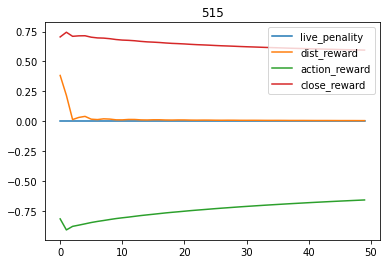

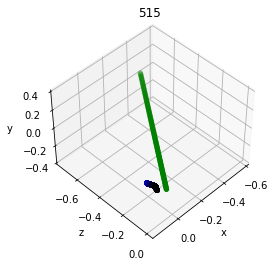

| eval  | E: 14 | S: 515 | R: -3.7474
| train | E: 15 | S: 515 | R: -2.1083 | D: 15.8 s | BR: -1.2606 | ALOSS: -5.1799 | CLOSS: 0.3884 | TLOSS: -0.9956 | TVAL: 0.8607 | AENT: -4.0000
| train | E: 16 | S: 565 | R: -35.6877 | D: 55.8 s | BR: -1.1849 | ALOSS: -5.3263 | CLOSS: 0.4549 | TLOSS: -1.0706 | TVAL: 0.8510 | AENT: -4.0000
| train | E: 17 | S: 615 | R: -56.2660 | D: 26.6 s | BR: -1.1197 | ALOSS: -5.6175 | CLOSS: 0.4921 | TLOSS: -1.1680 | TVAL: 0.8384 | AENT: -4.0000
| train | E: 18 | S: 665 | R: -45.5634 | D: 28.6 s | BR: -1.1960 | ALOSS: -5.6827 | CLOSS: 0.5884 | TLOSS: -1.2601 | TVAL: 0.8260 | AENT: -4.0000
| train | E: 19 | S: 698 | R: -41.3389 | D: 17.6 s | BR: -1.1332 | ALOSS: -5.8541 | CLOSS: 0.5885 | TLOSS: -1.3426 | TVAL: 0.8159 | AENT: -4.0000
| train | E: 20 | S: 748 | R: -42.1436 | D: 29.9 s | BR: -1.1142 | ALOSS: -5.9860 | CLOSS: 0.7335 | TLOSS: -1.4232 | TVAL: 0.8059 | AENT: -4.0000
| train | E: 21 | S: 777 | R: -6.9986 | D: 15.6 s | BR: -1.1268 | ALOSS: -6.0659 | CLOS

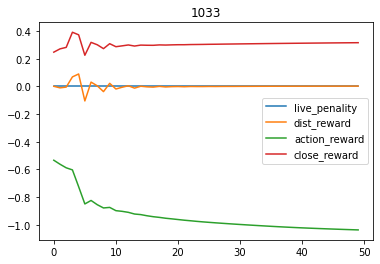

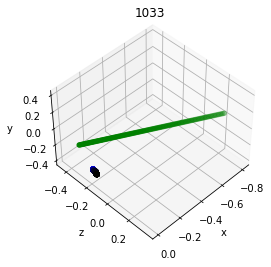

| eval  | E: 27 | S: 1033 | R: -31.5177
| train | E: 28 | S: 1033 | R: 0.0502 | D: 15.7 s | BR: -1.0012 | ALOSS: -6.9108 | CLOSS: 0.7148 | TLOSS: -1.9839 | TVAL: 0.7381 | AENT: -4.0000
| train | E: 29 | S: 1083 | R: -42.1652 | D: 52.9 s | BR: -0.9859 | ALOSS: -7.0204 | CLOSS: 0.8096 | TLOSS: -2.0529 | TVAL: 0.7295 | AENT: -4.0000
| train | E: 30 | S: 1133 | R: -42.8790 | D: 26.3 s | BR: -0.9760 | ALOSS: -7.1499 | CLOSS: 0.8062 | TLOSS: -2.1442 | TVAL: 0.7188 | AENT: -4.0000
| train | E: 31 | S: 1178 | R: -35.3650 | D: 23.8 s | BR: -1.0094 | ALOSS: -7.2419 | CLOSS: 0.6478 | TLOSS: -2.2169 | TVAL: 0.7088 | AENT: -4.0000
| train | E: 32 | S: 1228 | R: -28.2189 | D: 26.2 s | BR: -0.9818 | ALOSS: -7.3649 | CLOSS: 0.9078 | TLOSS: -2.3043 | TVAL: 0.6990 | AENT: -4.0000
| train | E: 33 | S: 1260 | R: -6.3995 | D: 17.1 s | BR: -0.9335 | ALOSS: -7.5959 | CLOSS: 0.9053 | TLOSS: -2.3730 | TVAL: 0.6907 | AENT: -4.0000
| train | E: 34 | S: 1292 | R: -4.2534 | D: 17.3 s | BR: -0.9595 | ALOSS: -7.5725

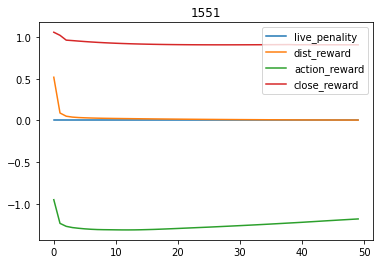

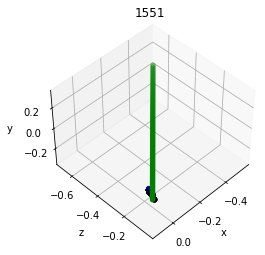

| eval  | E: 41 | S: 1551 | R: -15.5060
| train | E: 42 | S: 1551 | R: -12.4491 | D: 16.0 s | BR: -0.7941 | ALOSS: -8.6721 | CLOSS: 1.0620 | TLOSS: -2.8800 | TVAL: 0.6342 | AENT: -4.0000
| train | E: 43 | S: 1594 | R: -28.7950 | D: 49.3 s | BR: -0.8526 | ALOSS: -8.5574 | CLOSS: 1.0016 | TLOSS: -2.9162 | TVAL: 0.6276 | AENT: -4.0000
| train | E: 44 | S: 1644 | R: -37.9127 | D: 26.2 s | BR: -0.8243 | ALOSS: -8.7533 | CLOSS: 1.3416 | TLOSS: -2.9878 | TVAL: 0.6192 | AENT: -4.0000
| train | E: 45 | S: 1694 | R: -30.0915 | D: 27.1 s | BR: -0.7978 | ALOSS: -8.9397 | CLOSS: 1.0875 | TLOSS: -3.0763 | TVAL: 0.6103 | AENT: -4.0000
| train | E: 46 | S: 1735 | R: -15.7278 | D: 21.7 s | BR: -0.8062 | ALOSS: -8.9158 | CLOSS: 1.1629 | TLOSS: -3.1538 | TVAL: 0.6024 | AENT: -4.0000
| train | E: 47 | S: 1785 | R: -25.1951 | D: 26.5 s | BR: -0.7882 | ALOSS: -9.1020 | CLOSS: 1.0953 | TLOSS: -3.2279 | TVAL: 0.5945 | AENT: -4.0000
| train | E: 48 | S: 1818 | R: -9.1399 | D: 17.5 s | BR: -0.7705 | ALOSS: -9.1

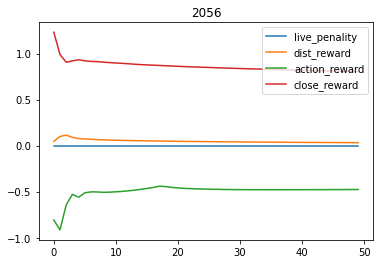

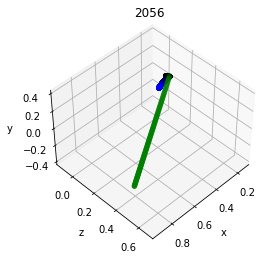

| eval  | E: 54 | S: 2056 | R: 20.6456
| train | E: 55 | S: 2056 | R: -16.8764 | D: 18.7 s | BR: -0.7167 | ALOSS: -9.8357 | CLOSS: 1.4260 | TLOSS: -3.6336 | TVAL: 0.5486 | AENT: -4.0000
| train | E: 56 | S: 2080 | R: 3.4097 | D: 41.7 s | BR: -0.7194 | ALOSS: -9.7337 | CLOSS: 1.6823 | TLOSS: -3.6564 | TVAL: 0.5440 | AENT: -4.0000
| train | E: 57 | S: 2130 | R: -26.3162 | D: 26.2 s | BR: -0.7200 | ALOSS: -9.7773 | CLOSS: 1.4912 | TLOSS: -3.7380 | TVAL: 0.5383 | AENT: -4.0000
| train | E: 58 | S: 2158 | R: 0.3712 | D: 16.0 s | BR: -0.7005 | ALOSS: -9.9816 | CLOSS: 1.5822 | TLOSS: -3.8134 | TVAL: 0.5324 | AENT: -4.0000
| train | E: 59 | S: 2186 | R: 1.6417 | D: 15.3 s | BR: -0.7345 | ALOSS: -10.1082 | CLOSS: 1.3848 | TLOSS: -3.8468 | TVAL: 0.5281 | AENT: -4.0000
| train | E: 60 | S: 2214 | R: 4.3874 | D: 15.2 s | BR: -0.7292 | ALOSS: -9.9856 | CLOSS: 1.4006 | TLOSS: -3.8920 | TVAL: 0.5239 | AENT: -4.0000
| train | E: 61 | S: 2247 | R: -12.9506 | D: 19.8 s | BR: -0.6758 | ALOSS: -10.2864 | 

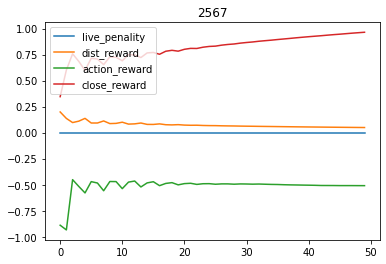

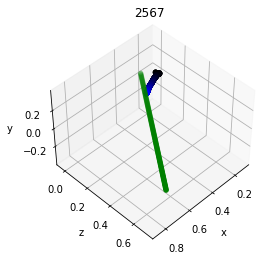

| eval  | E: 68 | S: 2567 | R: 18.7065
| train | E: 69 | S: 2567 | R: -26.7806 | D: 28.9 s | BR: -0.6658 | ALOSS: -10.6706 | CLOSS: 1.4782 | TLOSS: -4.4048 | TVAL: 0.4750 | AENT: -4.0000
| train | E: 70 | S: 2592 | R: -0.1411 | D: 40.5 s | BR: -0.6495 | ALOSS: -10.6352 | CLOSS: 1.3802 | TLOSS: -4.4269 | TVAL: 0.4700 | AENT: -4.0000
| train | E: 71 | S: 2615 | R: 1.4739 | D: 13.5 s | BR: -0.6509 | ALOSS: -10.5431 | CLOSS: 1.5648 | TLOSS: -4.5026 | TVAL: 0.4668 | AENT: -4.0000
| train | E: 72 | S: 2647 | R: -2.0745 | D: 17.0 s | BR: -0.6691 | ALOSS: -10.7321 | CLOSS: 1.5407 | TLOSS: -4.4756 | TVAL: 0.4631 | AENT: -4.0000
| train | E: 73 | S: 2678 | R: -4.4214 | D: 18.2 s | BR: -0.5862 | ALOSS: -11.1480 | CLOSS: 1.6776 | TLOSS: -4.5952 | TVAL: 0.4590 | AENT: -4.0000
| train | E: 74 | S: 2718 | R: -19.7561 | D: 20.9 s | BR: -0.6263 | ALOSS: -10.9824 | CLOSS: 1.7097 | TLOSS: -4.5585 | TVAL: 0.4544 | AENT: -4.0000
| train | E: 75 | S: 2744 | R: 2.0427 | D: 15.8 s | BR: -0.6163 | ALOSS: -10.8

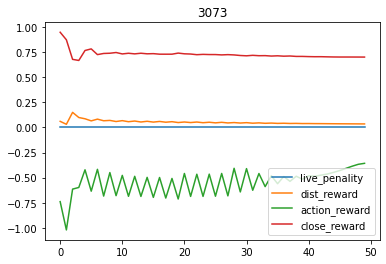

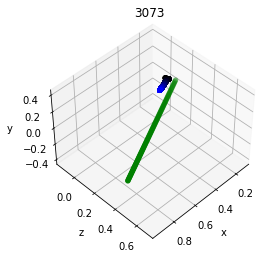

| eval  | E: 84 | S: 3073 | R: 11.6484
| train | E: 85 | S: 3073 | R: -16.6335 | D: 19.2 s | BR: -0.5442 | ALOSS: -11.2678 | CLOSS: 1.7632 | TLOSS: -5.0563 | TVAL: 0.4103 | AENT: -4.0000
| train | E: 86 | S: 3100 | R: 1.9083 | D: 41.4 s | BR: -0.5304 | ALOSS: -11.4415 | CLOSS: 1.5615 | TLOSS: -5.2023 | TVAL: 0.4066 | AENT: -4.0000
| train | E: 87 | S: 3142 | R: -23.6998 | D: 21.8 s | BR: -0.5600 | ALOSS: -11.3197 | CLOSS: 1.6578 | TLOSS: -5.2239 | TVAL: 0.4026 | AENT: -4.0000
| train | E: 88 | S: 3172 | R: 1.1313 | D: 16.0 s | BR: -0.5545 | ALOSS: -11.3958 | CLOSS: 1.3230 | TLOSS: -5.2615 | TVAL: 0.3985 | AENT: -4.0000
| train | E: 89 | S: 3222 | R: -26.9574 | D: 26.7 s | BR: -0.5375 | ALOSS: -11.3886 | CLOSS: 1.6946 | TLOSS: -5.2952 | TVAL: 0.3940 | AENT: -4.0000
| train | E: 90 | S: 3255 | R: -12.1997 | D: 19.8 s | BR: -0.5435 | ALOSS: -11.4423 | CLOSS: 1.6803 | TLOSS: -5.3415 | TVAL: 0.3894 | AENT: -4.0000
| train | E: 91 | S: 3283 | R: 1.2959 | D: 15.8 s | BR: -0.5373 | ALOSS: -11.

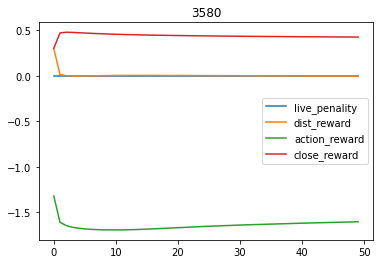

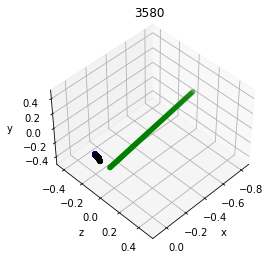

| eval  | E: 99 | S: 3580 | R: -59.6977
| train | E: 100 | S: 3580 | R: -3.8734 | D: 19.7 s | BR: -0.4982 | ALOSS: -11.6690 | CLOSS: 1.2805 | TLOSS: -5.7978 | TVAL: 0.3549 | AENT: -4.0000
| train | E: 101 | S: 3603 | R: 8.6771 | D: 39.5 s | BR: -0.5186 | ALOSS: -11.5689 | CLOSS: 1.5153 | TLOSS: -5.9593 | TVAL: 0.3519 | AENT: -4.0000
| train | E: 102 | S: 3630 | R: 3.2868 | D: 15.2 s | BR: -0.5399 | ALOSS: -11.4537 | CLOSS: 1.4491 | TLOSS: -5.8900 | TVAL: 0.3494 | AENT: -4.0000
| train | E: 103 | S: 3664 | R: -1.9295 | D: 17.9 s | BR: -0.5298 | ALOSS: -11.5118 | CLOSS: 1.2778 | TLOSS: -5.8858 | TVAL: 0.3463 | AENT: -4.0000
| train | E: 104 | S: 3699 | R: -2.6403 | D: 19.0 s | BR: -0.5282 | ALOSS: -11.5573 | CLOSS: 1.4041 | TLOSS: -5.9844 | TVAL: 0.3430 | AENT: -4.0000
| train | E: 105 | S: 3736 | R: 2.5286 | D: 20.9 s | BR: -0.4960 | ALOSS: -11.5848 | CLOSS: 1.3144 | TLOSS: -6.0762 | TVAL: 0.3394 | AENT: -4.0000
| train | E: 106 | S: 3775 | R: -6.0251 | D: 20.9 s | BR: -0.4981 | ALOSS: 

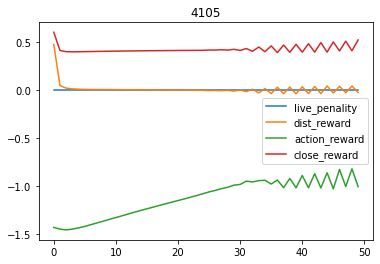

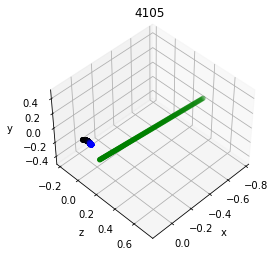

| eval  | E: 115 | S: 4105 | R: -34.1162
| train | E: 116 | S: 4105 | R: 2.0789 | D: 16.8 s | BR: -0.4843 | ALOSS: -11.4676 | CLOSS: 1.2461 | TLOSS: -6.6374 | TVAL: 0.3052 | AENT: -4.0000
| train | E: 117 | S: 4151 | R: -16.1497 | D: 53.3 s | BR: -0.4671 | ALOSS: -11.7848 | CLOSS: 1.2360 | TLOSS: -6.5436 | TVAL: 0.3019 | AENT: -4.0000
| train | E: 118 | S: 4196 | R: -10.3698 | D: 23.8 s | BR: -0.4432 | ALOSS: -11.3984 | CLOSS: 1.2638 | TLOSS: -6.5777 | TVAL: 0.2980 | AENT: -4.0000
| train | E: 119 | S: 4231 | R: -10.8073 | D: 18.9 s | BR: -0.4620 | ALOSS: -11.4841 | CLOSS: 1.1684 | TLOSS: -6.6307 | TVAL: 0.2946 | AENT: -4.0000
| train | E: 120 | S: 4256 | R: 10.0344 | D: 14.8 s | BR: -0.4777 | ALOSS: -11.2611 | CLOSS: 1.2798 | TLOSS: -6.6868 | TVAL: 0.2921 | AENT: -4.0000
| train | E: 121 | S: 4285 | R: -0.8588 | D: 15.5 s | BR: -0.4792 | ALOSS: -11.3781 | CLOSS: 1.1155 | TLOSS: -6.7752 | TVAL: 0.2899 | AENT: -4.0000
| train | E: 122 | S: 4314 | R: 4.5143 | D: 17.1 s | BR: -0.4293 | AL

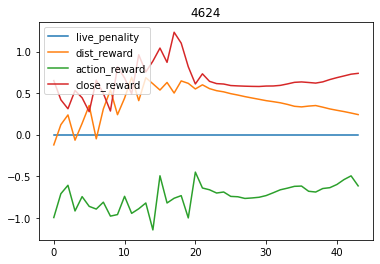

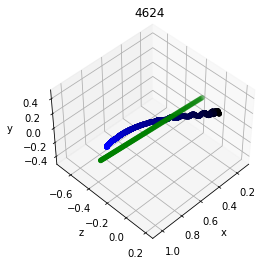

| eval  | E: 131 | S: 4624 | R: 13.3560
| train | E: 132 | S: 4624 | R: 6.4878 | D: 15.0 s | BR: -0.4173 | ALOSS: -11.6369 | CLOSS: 0.9029 | TLOSS: -7.2400 | TVAL: 0.2630 | AENT: -4.0000
| train | E: 133 | S: 4660 | R: 1.8830 | D: 45.0 s | BR: -0.4348 | ALOSS: -11.3625 | CLOSS: 0.8278 | TLOSS: -7.3078 | TVAL: 0.2606 | AENT: -4.0000
| train | E: 134 | S: 4688 | R: 7.0517 | D: 16.8 s | BR: -0.3740 | ALOSS: -11.4200 | CLOSS: 0.8831 | TLOSS: -7.0449 | TVAL: 0.2582 | AENT: -4.0000
| train | E: 135 | S: 4714 | R: 5.1283 | D: 14.6 s | BR: -0.3821 | ALOSS: -11.2242 | CLOSS: 0.9066 | TLOSS: -7.2678 | TVAL: 0.2562 | AENT: -4.0000
| train | E: 136 | S: 4739 | R: 6.5744 | D: 15.6 s | BR: -0.4228 | ALOSS: -11.0665 | CLOSS: 0.9075 | TLOSS: -7.1987 | TVAL: 0.2544 | AENT: -4.0000
| train | E: 137 | S: 4767 | R: 2.6635 | D: 15.6 s | BR: -0.4089 | ALOSS: -11.3427 | CLOSS: 0.9344 | TLOSS: -7.2883 | TVAL: 0.2525 | AENT: -4.0000
| train | E: 138 | S: 4792 | R: 8.6353 | D: 14.9 s | BR: -0.3513 | ALOSS: -11.

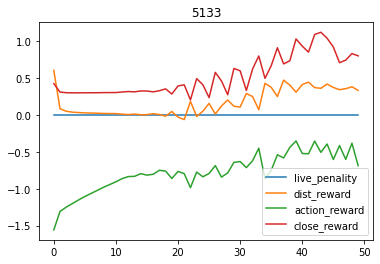

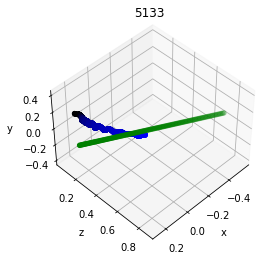

| eval  | E: 149 | S: 5133 | R: -3.5969
| train | E: 150 | S: 5133 | R: 7.4313 | D: 14.0 s | BR: -0.3266 | ALOSS: -11.3815 | CLOSS: 0.6468 | TLOSS: -7.8943 | TVAL: 0.2274 | AENT: -4.0000
| train | E: 151 | S: 5158 | R: 6.0432 | D: 40.4 s | BR: -0.3310 | ALOSS: -11.0985 | CLOSS: 0.7071 | TLOSS: -7.8162 | TVAL: 0.2257 | AENT: -4.0000
| train | E: 152 | S: 5195 | R: -15.6035 | D: 21.2 s | BR: -0.3401 | ALOSS: -11.2444 | CLOSS: 0.6786 | TLOSS: -7.7491 | TVAL: 0.2237 | AENT: -4.0000
| train | E: 153 | S: 5240 | R: -22.5660 | D: 23.8 s | BR: -0.3330 | ALOSS: -10.8182 | CLOSS: 0.7196 | TLOSS: -7.8310 | TVAL: 0.2211 | AENT: -4.0000
| train | E: 154 | S: 5275 | R: -13.0743 | D: 20.5 s | BR: -0.3534 | ALOSS: -10.9476 | CLOSS: 0.6051 | TLOSS: -7.7936 | TVAL: 0.2186 | AENT: -4.0000
| train | E: 155 | S: 5312 | R: -2.7435 | D: 19.8 s | BR: -0.3649 | ALOSS: -10.8651 | CLOSS: 0.6784 | TLOSS: -7.9791 | TVAL: 0.2164 | AENT: -4.0000
| train | E: 156 | S: 5355 | R: -6.6855 | D: 22.9 s | BR: -0.3570 | ALO

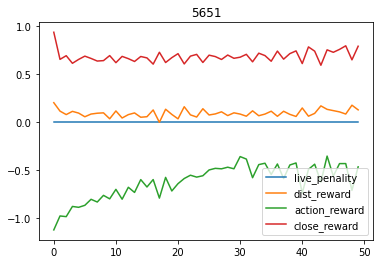

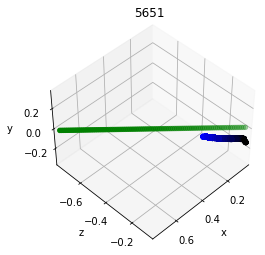

| eval  | E: 164 | S: 5651 | R: 7.5342
| train | E: 165 | S: 5651 | R: 8.6026 | D: 15.8 s | BR: -0.3309 | ALOSS: -10.6870 | CLOSS: 0.5486 | TLOSS: -8.1855 | TVAL: 0.1962 | AENT: -4.0000
| train | E: 166 | S: 5680 | R: 9.2377 | D: 42.5 s | BR: -0.3224 | ALOSS: -10.6710 | CLOSS: 0.5729 | TLOSS: -8.5322 | TVAL: 0.1946 | AENT: -4.0000
| train | E: 167 | S: 5698 | R: 10.6175 | D: 10.4 s | BR: -0.3130 | ALOSS: -10.4951 | CLOSS: 0.5067 | TLOSS: -8.3148 | TVAL: 0.1933 | AENT: -4.0000
| train | E: 168 | S: 5732 | R: 1.9120 | D: 19.2 s | BR: -0.3140 | ALOSS: -10.4940 | CLOSS: 0.5770 | TLOSS: -8.4623 | TVAL: 0.1918 | AENT: -4.0000
| train | E: 169 | S: 5764 | R: 1.8946 | D: 17.3 s | BR: -0.3124 | ALOSS: -10.2452 | CLOSS: 0.6016 | TLOSS: -8.4655 | TVAL: 0.1900 | AENT: -4.0000
| train | E: 170 | S: 5790 | R: 4.9050 | D: 16.0 s | BR: -0.3243 | ALOSS: -10.3994 | CLOSS: 0.5056 | TLOSS: -8.5267 | TVAL: 0.1885 | AENT: -4.0000
| train | E: 171 | S: 5819 | R: 7.9844 | D: 16.8 s | BR: -0.3297 | ALOSS: -10.

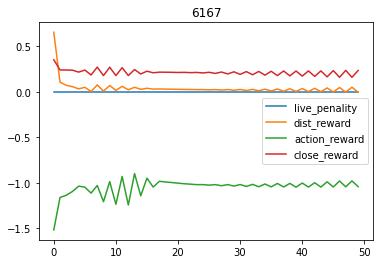

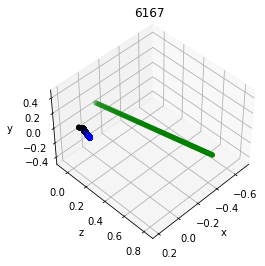

| eval  | E: 181 | S: 6167 | R: -39.4089
| train | E: 182 | S: 6167 | R: 1.3682 | D: 16.7 s | BR: -0.2808 | ALOSS: -9.9492 | CLOSS: 0.4002 | TLOSS: -8.7844 | TVAL: 0.1695 | AENT: -4.0000
| train | E: 183 | S: 6188 | R: 10.4984 | D: 41.9 s | BR: -0.2007 | ALOSS: -9.9499 | CLOSS: 0.4662 | TLOSS: -8.6954 | TVAL: 0.1682 | AENT: -4.0000
| train | E: 184 | S: 6228 | R: 2.1752 | D: 23.0 s | BR: -0.3119 | ALOSS: -9.6413 | CLOSS: 0.5068 | TLOSS: -8.8183 | TVAL: 0.1668 | AENT: -4.0000
| train | E: 185 | S: 6276 | R: -3.9440 | D: 25.4 s | BR: -0.2722 | ALOSS: -9.6188 | CLOSS: 0.4622 | TLOSS: -8.7565 | TVAL: 0.1647 | AENT: -4.0000
| train | E: 186 | S: 6308 | R: 1.2039 | D: 18.3 s | BR: -0.2506 | ALOSS: -9.7179 | CLOSS: 0.4396 | TLOSS: -9.0030 | TVAL: 0.1629 | AENT: -4.0000
| train | E: 187 | S: 6351 | R: -3.8966 | D: 22.4 s | BR: -0.3074 | ALOSS: -9.6373 | CLOSS: 0.4402 | TLOSS: -8.9080 | TVAL: 0.1611 | AENT: -4.0000
| train | E: 188 | S: 6376 | R: 8.7104 | D: 13.7 s | BR: -0.2995 | ALOSS: -9.369

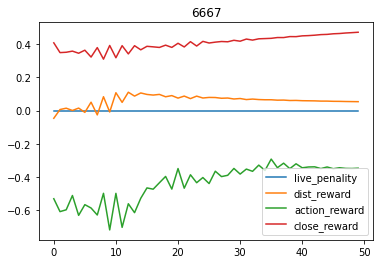

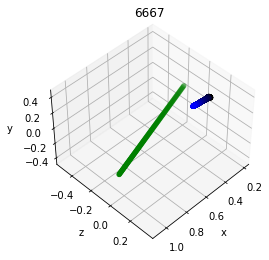

| eval  | E: 196 | S: 6667 | R: 1.4228
| train | E: 197 | S: 6667 | R: 11.4518 | D: 12.6 s | BR: -0.2887 | ALOSS: -9.1021 | CLOSS: 0.4945 | TLOSS: -9.0557 | TVAL: 0.1469 | AENT: -4.0000
| train | E: 198 | S: 6715 | R: -15.2096 | D: 55.3 s | BR: -0.2373 | ALOSS: -9.0713 | CLOSS: 0.4329 | TLOSS: -9.2779 | TVAL: 0.1455 | AENT: -4.0000
| train | E: 199 | S: 6745 | R: 5.1509 | D: 16.2 s | BR: -0.2560 | ALOSS: -9.1201 | CLOSS: 0.3593 | TLOSS: -9.0635 | TVAL: 0.1439 | AENT: -4.0000
| train | E: 200 | S: 6771 | R: 8.4441 | D: 15.1 s | BR: -0.2482 | ALOSS: -9.1847 | CLOSS: 0.3840 | TLOSS: -9.0935 | TVAL: 0.1428 | AENT: -4.0000
| train | E: 201 | S: 6817 | R: -6.1513 | D: 24.2 s | BR: -0.2362 | ALOSS: -9.0812 | CLOSS: 0.4493 | TLOSS: -9.1189 | TVAL: 0.1413 | AENT: -4.0000
| train | E: 202 | S: 6857 | R: 3.0759 | D: 22.4 s | BR: -0.2332 | ALOSS: -9.0017 | CLOSS: 0.4478 | TLOSS: -9.1798 | TVAL: 0.1396 | AENT: -4.0000
| train | E: 203 | S: 6899 | R: 1.1619 | D: 25.2 s | BR: -0.2609 | ALOSS: -8.8644

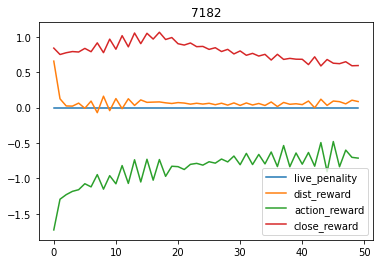

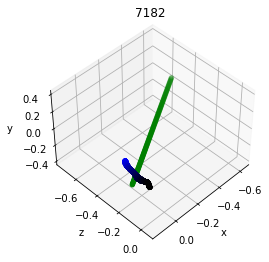

| eval  | E: 209 | S: 7182 | R: 0.5519
| train | E: 210 | S: 7182 | R: 2.2454 | D: 29.5 s | BR: -0.2658 | ALOSS: -8.6034 | CLOSS: 0.3617 | TLOSS: -9.3147 | TVAL: 0.1277 | AENT: -4.0000
| train | E: 211 | S: 7210 | R: 15.5308 | D: 41.6 s | BR: -0.2619 | ALOSS: -8.3843 | CLOSS: 0.4211 | TLOSS: -9.3907 | TVAL: 0.1264 | AENT: -4.0000
| train | E: 212 | S: 7246 | R: 10.0459 | D: 19.2 s | BR: -0.1939 | ALOSS: -8.7254 | CLOSS: 0.3664 | TLOSS: -9.3589 | TVAL: 0.1253 | AENT: -4.0000
| train | E: 213 | S: 7285 | R: -10.3034 | D: 20.9 s | BR: -0.2313 | ALOSS: -8.5472 | CLOSS: 0.3905 | TLOSS: -9.4287 | TVAL: 0.1240 | AENT: -4.0000
| train | E: 214 | S: 7335 | R: -25.2547 | D: 26.6 s | BR: -0.2281 | ALOSS: -8.4727 | CLOSS: 0.3734 | TLOSS: -9.5345 | TVAL: 0.1224 | AENT: -4.0000
| train | E: 215 | S: 7365 | R: 9.6261 | D: 16.2 s | BR: -0.2335 | ALOSS: -8.3756 | CLOSS: 0.4319 | TLOSS: -9.4393 | TVAL: 0.1211 | AENT: -4.0000
| train | E: 216 | S: 7405 | R: 5.4901 | D: 23.3 s | BR: -0.2519 | ALOSS: -8.28

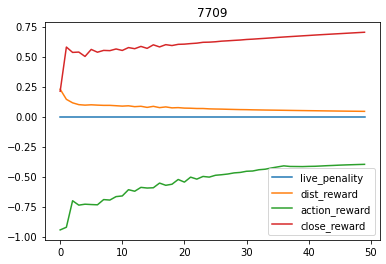

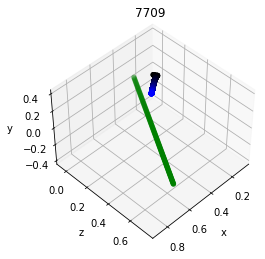

| eval  | E: 223 | S: 7709 | R: 7.3877
| train | E: 224 | S: 7709 | R: -12.6341 | D: 21.9 s | BR: -0.2073 | ALOSS: -8.0719 | CLOSS: 0.3748 | TLOSS: -9.4521 | TVAL: 0.1103 | AENT: -4.0000
| train | E: 225 | S: 7736 | R: 9.4502 | D: 41.9 s | BR: -0.2170 | ALOSS: -8.0938 | CLOSS: 0.3837 | TLOSS: -9.4646 | TVAL: 0.1093 | AENT: -4.0000
| train | E: 226 | S: 7773 | R: -8.0109 | D: 19.8 s | BR: -0.2184 | ALOSS: -8.1374 | CLOSS: 0.3514 | TLOSS: -9.5748 | TVAL: 0.1083 | AENT: -4.0000
| train | E: 227 | S: 7805 | R: 7.4682 | D: 17.7 s | BR: -0.2080 | ALOSS: -8.0279 | CLOSS: 0.3180 | TLOSS: -9.6529 | TVAL: 0.1073 | AENT: -4.0000
| train | E: 228 | S: 7844 | R: -7.6897 | D: 20.6 s | BR: -0.2149 | ALOSS: -7.9279 | CLOSS: 0.3627 | TLOSS: -9.5223 | TVAL: 0.1062 | AENT: -4.0000
| train | E: 229 | S: 7880 | R: -4.8524 | D: 19.0 s | BR: -0.2110 | ALOSS: -7.8961 | CLOSS: 0.3507 | TLOSS: -9.6326 | TVAL: 0.1051 | AENT: -4.0000
| train | E: 230 | S: 7907 | R: 7.9854 | D: 14.8 s | BR: -0.2043 | ALOSS: -7.847

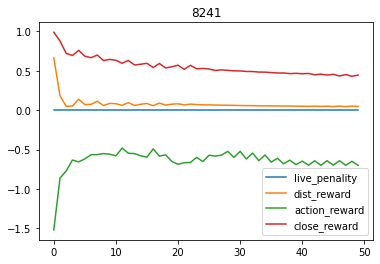

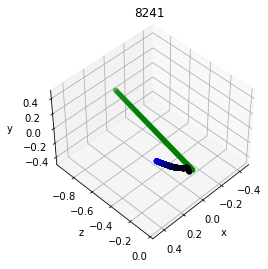

| eval  | E: 239 | S: 8241 | R: -0.2335
| train | E: 240 | S: 8241 | R: 7.6472 | D: 20.5 s | BR: -0.2054 | ALOSS: -7.3659 | CLOSS: 0.2978 | TLOSS: -9.3639 | TVAL: 0.0953 | AENT: -4.0000
| train | E: 241 | S: 8291 | R: -4.8588 | D: 56.3 s | BR: -0.1710 | ALOSS: -7.5542 | CLOSS: 0.2931 | TLOSS: -9.6601 | TVAL: 0.0942 | AENT: -4.0000
| train | E: 242 | S: 8318 | R: 14.6231 | D: 16.0 s | BR: -0.1936 | ALOSS: -7.3547 | CLOSS: 0.3501 | TLOSS: -9.5723 | TVAL: 0.0932 | AENT: -4.0000
| train | E: 243 | S: 8348 | R: 12.2775 | D: 16.4 s | BR: -0.1857 | ALOSS: -7.4779 | CLOSS: 0.3029 | TLOSS: -9.6369 | TVAL: 0.0925 | AENT: -4.0000
| train | E: 244 | S: 8379 | R: -1.4187 | D: 18.6 s | BR: -0.1895 | ALOSS: -7.2538 | CLOSS: 0.3180 | TLOSS: -9.6235 | TVAL: 0.0917 | AENT: -4.0000
| train | E: 245 | S: 8407 | R: 10.7577 | D: 15.5 s | BR: -0.1700 | ALOSS: -7.3587 | CLOSS: 0.3136 | TLOSS: -9.5315 | TVAL: 0.0910 | AENT: -4.0000
| train | E: 246 | S: 8444 | R: 4.9969 | D: 19.8 s | BR: -0.2031 | ALOSS: -7.11

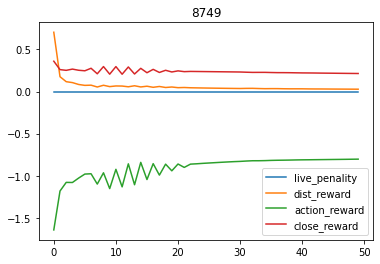

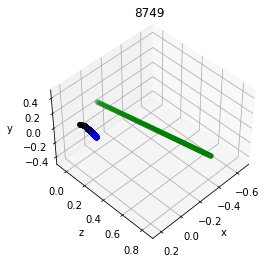

| eval  | E: 253 | S: 8749 | R: -30.5043
| train | E: 254 | S: 8749 | R: 10.0045 | D: 21.7 s | BR: -0.1830 | ALOSS: -6.9688 | CLOSS: 0.2869 | TLOSS: -9.7834 | TVAL: 0.0831 | AENT: -4.0000
| train | E: 255 | S: 8788 | R: 1.4283 | D: 49.6 s | BR: -0.1685 | ALOSS: -7.1137 | CLOSS: 0.2778 | TLOSS: -9.5157 | TVAL: 0.0822 | AENT: -4.0000
| train | E: 256 | S: 8823 | R: 8.5470 | D: 18.8 s | BR: -0.1795 | ALOSS: -6.8539 | CLOSS: 0.3001 | TLOSS: -9.5811 | TVAL: 0.0814 | AENT: -4.0000
| train | E: 257 | S: 8851 | R: 12.7786 | D: 15.3 s | BR: -0.1496 | ALOSS: -6.8736 | CLOSS: 0.2541 | TLOSS: -9.6732 | TVAL: 0.0807 | AENT: -4.0000
| train | E: 258 | S: 8899 | R: -3.5701 | D: 25.7 s | BR: -0.1988 | ALOSS: -6.8478 | CLOSS: 0.3122 | TLOSS: -9.7322 | TVAL: 0.0799 | AENT: -4.0000
| train | E: 259 | S: 8947 | R: -7.6230 | D: 25.4 s | BR: -0.1826 | ALOSS: -6.8370 | CLOSS: 0.2970 | TLOSS: -9.5296 | TVAL: 0.0789 | AENT: -4.0000
| train | E: 260 | S: 8984 | R: -4.5614 | D: 19.4 s | BR: -0.1843 | ALOSS: -6.9

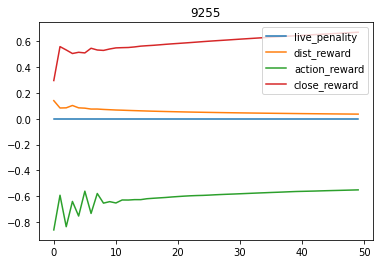

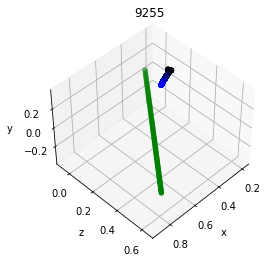

| eval  | E: 267 | S: 9255 | R: 1.9775
| train | E: 268 | S: 9255 | R: 9.9555 | D: 15.6 s | BR: -0.1623 | ALOSS: -6.5238 | CLOSS: 0.2567 | TLOSS: -9.3173 | TVAL: 0.0724 | AENT: -4.0000
| train | E: 269 | S: 9287 | R: 8.0912 | D: 44.4 s | BR: -0.1798 | ALOSS: -6.4881 | CLOSS: 0.3030 | TLOSS: -9.5947 | TVAL: 0.0719 | AENT: -4.0000
| train | E: 270 | S: 9313 | R: 15.4050 | D: 14.4 s | BR: -0.1759 | ALOSS: -6.4014 | CLOSS: 0.2598 | TLOSS: -9.3707 | TVAL: 0.0713 | AENT: -4.0000
| train | E: 271 | S: 9335 | R: 14.2323 | D: 13.3 s | BR: -0.1500 | ALOSS: -6.3898 | CLOSS: 0.2732 | TLOSS: -9.3455 | TVAL: 0.0708 | AENT: -4.0000
| train | E: 272 | S: 9368 | R: 14.2699 | D: 17.9 s | BR: -0.1567 | ALOSS: -6.6758 | CLOSS: 0.2347 | TLOSS: -9.6695 | TVAL: 0.0703 | AENT: -4.0000
| train | E: 273 | S: 9397 | R: 10.0214 | D: 17.2 s | BR: -0.1765 | ALOSS: -6.4613 | CLOSS: 0.2565 | TLOSS: -9.2867 | TVAL: 0.0698 | AENT: -4.0000
| train | E: 274 | S: 9432 | R: -7.6186 | D: 18.8 s | BR: -0.1855 | ALOSS: -6.442

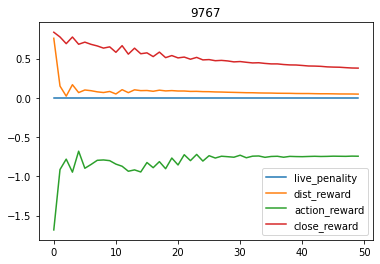

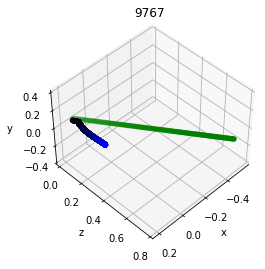

| eval  | E: 284 | S: 9767 | R: -9.9919
| train | E: 285 | S: 9767 | R: 12.9372 | D: 13.3 s | BR: -0.1347 | ALOSS: -6.1777 | CLOSS: 0.2510 | TLOSS: -9.2301 | TVAL: 0.0632 | AENT: -4.0000
| train | E: 286 | S: 9794 | R: 9.2763 | D: 40.8 s | BR: -0.1342 | ALOSS: -6.1933 | CLOSS: 0.2490 | TLOSS: -9.3798 | TVAL: 0.0628 | AENT: -4.0000
| train | E: 287 | S: 9816 | R: 12.7065 | D: 12.6 s | BR: -0.1673 | ALOSS: -6.2040 | CLOSS: 0.2729 | TLOSS: -9.4210 | TVAL: 0.0624 | AENT: -4.0000
| train | E: 288 | S: 9849 | R: 3.8863 | D: 19.7 s | BR: -0.1188 | ALOSS: -6.1619 | CLOSS: 0.2185 | TLOSS: -9.3556 | TVAL: 0.0619 | AENT: -4.0000
| train | E: 289 | S: 9878 | R: 16.9112 | D: 17.2 s | BR: -0.1634 | ALOSS: -6.2224 | CLOSS: 0.2533 | TLOSS: -8.9509 | TVAL: 0.0614 | AENT: -4.0000
| train | E: 290 | S: 9905 | R: 6.0389 | D: 15.0 s | BR: -0.1625 | ALOSS: -6.1086 | CLOSS: 0.2607 | TLOSS: -9.0915 | TVAL: 0.0610 | AENT: -4.0000
| train | E: 291 | S: 9933 | R: 12.9489 | D: 15.1 s | BR: -0.1626 | ALOSS: -6.271

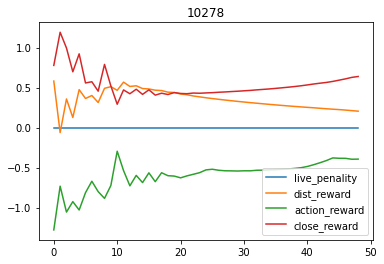

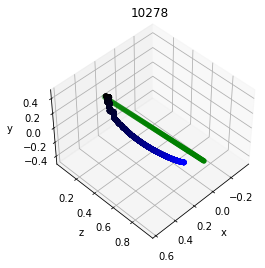

| eval  | E: 301 | S: 10278 | R: 13.9729
| train | E: 302 | S: 10278 | R: -1.9806 | D: 22.6 s | BR: -0.1169 | ALOSS: -5.9899 | CLOSS: 0.2669 | TLOSS: -9.0305 | TVAL: 0.0555 | AENT: -4.0000
| train | E: 303 | S: 10305 | R: 14.2952 | D: 40.7 s | BR: -0.1145 | ALOSS: -5.9927 | CLOSS: 0.2140 | TLOSS: -9.0089 | TVAL: 0.0550 | AENT: -4.0000
| train | E: 304 | S: 10334 | R: 10.6673 | D: 17.3 s | BR: -0.1097 | ALOSS: -5.9910 | CLOSS: 0.2074 | TLOSS: -8.7086 | TVAL: 0.0546 | AENT: -4.0000
| train | E: 305 | S: 10359 | R: 12.9690 | D: 14.0 s | BR: -0.1169 | ALOSS: -5.8007 | CLOSS: 0.2865 | TLOSS: -8.6665 | TVAL: 0.0542 | AENT: -4.0000
| train | E: 306 | S: 10395 | R: 3.4797 | D: 20.5 s | BR: -0.1124 | ALOSS: -5.8064 | CLOSS: 0.2237 | TLOSS: -8.9806 | TVAL: 0.0538 | AENT: -4.0000
| train | E: 307 | S: 10418 | R: 15.8912 | D: 12.8 s | BR: -0.1260 | ALOSS: -5.9411 | CLOSS: 0.2664 | TLOSS: -8.4517 | TVAL: 0.0534 | AENT: -4.0000
| train | E: 308 | S: 10450 | R: 18.0610 | D: 18.7 s | BR: -0.1035 | ALO

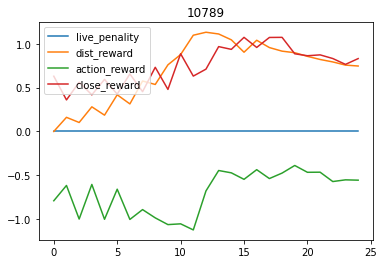

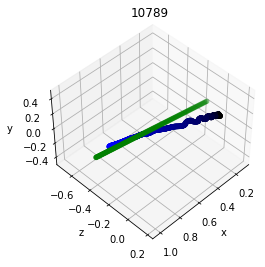

| eval  | E: 318 | S: 10789 | R: 18.5571
| train | E: 319 | S: 10789 | R: 4.9346 | D: 16.4 s | BR: -0.1478 | ALOSS: -5.7980 | CLOSS: 0.2473 | TLOSS: -8.6271 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 320 | S: 10811 | R: 15.2762 | D: 28.3 s | BR: -0.0845 | ALOSS: -5.7915 | CLOSS: 0.2484 | TLOSS: -8.1419 | TVAL: 0.0483 | AENT: -4.0000
| train | E: 321 | S: 10847 | R: 8.5603 | D: 21.3 s | BR: -0.0842 | ALOSS: -5.8686 | CLOSS: 0.2066 | TLOSS: -8.8166 | TVAL: 0.0480 | AENT: -4.0000
| train | E: 322 | S: 10883 | R: 1.7621 | D: 19.1 s | BR: -0.0687 | ALOSS: -5.6616 | CLOSS: 0.2553 | TLOSS: -8.2754 | TVAL: 0.0475 | AENT: -4.0000
| train | E: 323 | S: 10908 | R: 8.9093 | D: 15.0 s | BR: -0.1025 | ALOSS: -5.6464 | CLOSS: 0.2299 | TLOSS: -8.3135 | TVAL: 0.0472 | AENT: -4.0000
| train | E: 324 | S: 10936 | R: 14.5758 | D: 15.0 s | BR: -0.0719 | ALOSS: -5.6485 | CLOSS: 0.2930 | TLOSS: -8.7191 | TVAL: 0.0469 | AENT: -4.0000
| train | E: 325 | S: 10962 | R: 10.4550 | D: 15.3 s | BR: -0.0885 | ALOSS:

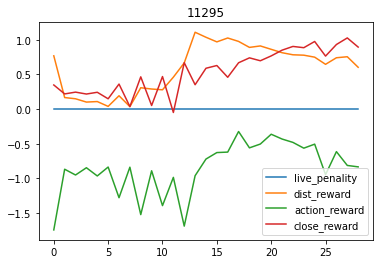

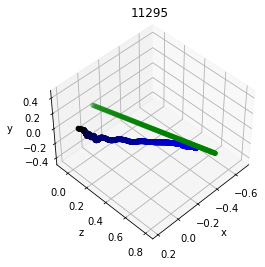

| eval  | E: 337 | S: 11295 | R: 8.0782
| train | E: 338 | S: 11295 | R: 1.2242 | D: 15.0 s | BR: -0.0742 | ALOSS: -5.6217 | CLOSS: 0.2114 | TLOSS: -8.1437 | TVAL: 0.0428 | AENT: -4.0000
| train | E: 339 | S: 11312 | R: 16.2168 | D: 26.2 s | BR: -0.0925 | ALOSS: -5.6426 | CLOSS: 0.2679 | TLOSS: -8.8453 | TVAL: 0.0426 | AENT: -4.0000
| train | E: 340 | S: 11338 | R: 13.1296 | D: 14.1 s | BR: -0.1281 | ALOSS: -5.6407 | CLOSS: 0.3171 | TLOSS: -7.9288 | TVAL: 0.0424 | AENT: -4.0000
| train | E: 341 | S: 11370 | R: -0.5474 | D: 18.8 s | BR: -0.0764 | ALOSS: -5.5431 | CLOSS: 0.2670 | TLOSS: -8.1287 | TVAL: 0.0421 | AENT: -4.0000
| train | E: 342 | S: 11392 | R: 12.0110 | D: 12.4 s | BR: -0.0487 | ALOSS: -5.8262 | CLOSS: 0.2219 | TLOSS: -7.3351 | TVAL: 0.0418 | AENT: -4.0000
| train | E: 343 | S: 11421 | R: -1.0298 | D: 15.8 s | BR: -0.0738 | ALOSS: -5.5374 | CLOSS: 0.2712 | TLOSS: -8.3303 | TVAL: 0.0415 | AENT: -4.0000
| train | E: 344 | S: 11444 | R: 17.7599 | D: 14.0 s | BR: -0.0645 | ALOS

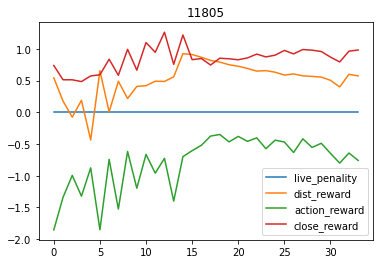

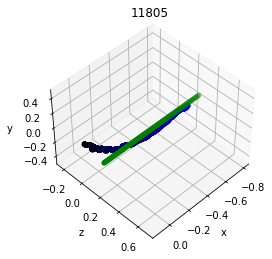

| eval  | E: 360 | S: 11805 | R: 19.3824
| train | E: 361 | S: 11805 | R: 9.9250 | D: 15.4 s | BR: -0.0276 | ALOSS: -5.9617 | CLOSS: 0.2524 | TLOSS: -7.5002 | TVAL: 0.0379 | AENT: -4.0000
| train | E: 362 | S: 11823 | R: 12.9560 | D: 29.9 s | BR: -0.0827 | ALOSS: -5.8498 | CLOSS: 0.3311 | TLOSS: -7.3056 | TVAL: 0.0377 | AENT: -4.0000
| train | E: 363 | S: 11848 | R: 14.3223 | D: 13.6 s | BR: -0.0755 | ALOSS: -5.6961 | CLOSS: 0.3328 | TLOSS: -7.2576 | TVAL: 0.0375 | AENT: -4.0000
| train | E: 364 | S: 11869 | R: 12.9367 | D: 12.0 s | BR: -0.0443 | ALOSS: -5.8784 | CLOSS: 0.2111 | TLOSS: -6.3707 | TVAL: 0.0373 | AENT: -4.0000
| train | E: 365 | S: 11913 | R: -27.7260 | D: 23.9 s | BR: -0.0421 | ALOSS: -5.7347 | CLOSS: 0.2760 | TLOSS: -7.0617 | TVAL: 0.0371 | AENT: -4.0000
| train | E: 366 | S: 11933 | R: 14.3540 | D: 11.2 s | BR: -0.0576 | ALOSS: -5.7587 | CLOSS: 0.2020 | TLOSS: -6.7114 | TVAL: 0.0368 | AENT: -4.0000
| train | E: 367 | S: 11949 | R: 12.7970 | D: 09.3 s | BR: -0.0492 | AL

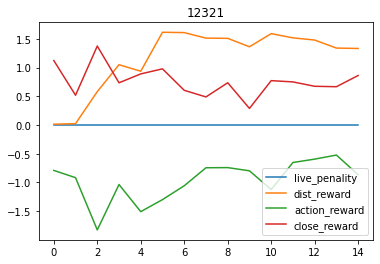

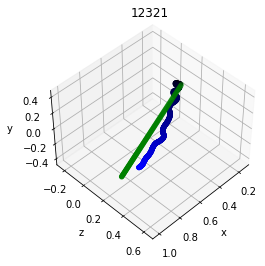

| eval  | E: 386 | S: 12321 | R: 14.4337
| train | E: 387 | S: 12321 | R: 11.5305 | D: 12.1 s | BR: -0.0061 | ALOSS: -5.8398 | CLOSS: 0.2458 | TLOSS: -6.1361 | TVAL: 0.0338 | AENT: -4.0000
| train | E: 388 | S: 12344 | R: 11.0685 | D: 23.2 s | BR: -0.0130 | ALOSS: -6.1440 | CLOSS: 0.2586 | TLOSS: -5.9225 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 389 | S: 12369 | R: 11.8284 | D: 15.1 s | BR: 0.0007 | ALOSS: -6.1234 | CLOSS: 0.2548 | TLOSS: -6.4804 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 390 | S: 12385 | R: 13.9177 | D: 09.7 s | BR: -0.0551 | ALOSS: -5.8696 | CLOSS: 0.2696 | TLOSS: -5.8995 | TVAL: 0.0333 | AENT: -4.0000
| train | E: 391 | S: 12413 | R: -3.8995 | D: 16.1 s | BR: -0.0650 | ALOSS: -5.8869 | CLOSS: 0.2197 | TLOSS: -5.7384 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 392 | S: 12431 | R: 16.8600 | D: 10.7 s | BR: -0.0013 | ALOSS: -6.0224 | CLOSS: 0.2720 | TLOSS: -5.8170 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 393 | S: 12449 | R: 12.2546 | D: 11.5 s | BR: 0.0042 | ALOS

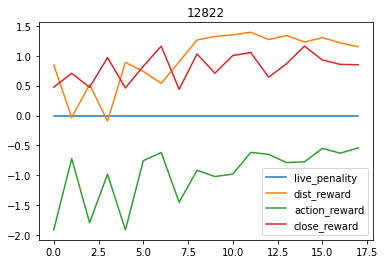

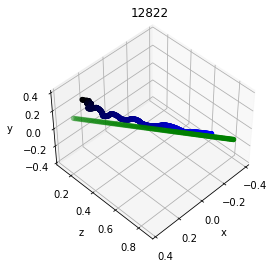

| eval  | E: 411 | S: 12822 | R: 14.1413
| train | E: 412 | S: 12822 | R: 8.8931 | D: 11.1 s | BR: -0.0149 | ALOSS: -6.1432 | CLOSS: 0.2922 | TLOSS: -4.5286 | TVAL: 0.0305 | AENT: -4.0000
| train | E: 413 | S: 12839 | R: 15.6353 | D: 21.3 s | BR: 0.0405 | ALOSS: -6.3529 | CLOSS: 0.2876 | TLOSS: -4.7704 | TVAL: 0.0304 | AENT: -4.0000
| train | E: 414 | S: 12856 | R: 12.3608 | D: 09.9 s | BR: -0.0201 | ALOSS: -6.2379 | CLOSS: 0.2466 | TLOSS: -5.0266 | TVAL: 0.0303 | AENT: -4.0000
| train | E: 415 | S: 12872 | R: 10.0303 | D: 09.4 s | BR: -0.0160 | ALOSS: -6.3572 | CLOSS: 0.2595 | TLOSS: -5.0081 | TVAL: 0.0302 | AENT: -4.0000
| train | E: 416 | S: 12888 | R: 14.3942 | D: 09.2 s | BR: 0.0406 | ALOSS: -6.2315 | CLOSS: 0.2310 | TLOSS: -4.5924 | TVAL: 0.0301 | AENT: -4.0000
| train | E: 417 | S: 12903 | R: 15.6335 | D: 09.1 s | BR: 0.0137 | ALOSS: -6.1802 | CLOSS: 0.2847 | TLOSS: -4.6387 | TVAL: 0.0300 | AENT: -4.0000
| train | E: 418 | S: 12917 | R: 15.6826 | D: 08.5 s | BR: 0.0108 | ALOSS: 

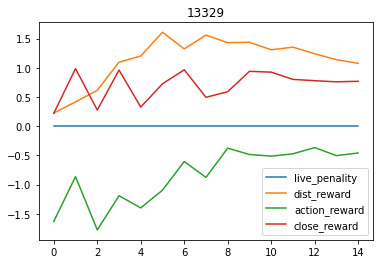

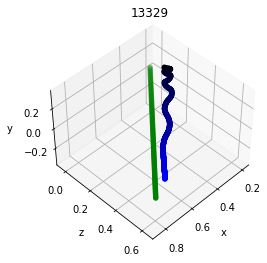

| eval  | E: 439 | S: 13329 | R: 14.9544
| train | E: 440 | S: 13329 | R: 13.6139 | D: 10.3 s | BR: -0.0395 | ALOSS: -6.2805 | CLOSS: 0.3370 | TLOSS: -3.9765 | TVAL: 0.0279 | AENT: -4.0000
| train | E: 441 | S: 13346 | R: 17.0904 | D: 20.5 s | BR: 0.0342 | ALOSS: -6.5790 | CLOSS: 0.2307 | TLOSS: -3.6812 | TVAL: 0.0279 | AENT: -4.0000
| train | E: 442 | S: 13364 | R: 12.6713 | D: 10.5 s | BR: 0.0300 | ALOSS: -6.7440 | CLOSS: 0.2562 | TLOSS: -3.2444 | TVAL: 0.0278 | AENT: -4.0000
| train | E: 443 | S: 13385 | R: 5.7757 | D: 12.1 s | BR: -0.0083 | ALOSS: -6.7620 | CLOSS: 0.2914 | TLOSS: -3.8967 | TVAL: 0.0277 | AENT: -4.0000
| train | E: 444 | S: 13405 | R: 17.0539 | D: 12.6 s | BR: 0.0091 | ALOSS: -6.6131 | CLOSS: 0.3223 | TLOSS: -4.5805 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 445 | S: 13424 | R: 13.1794 | D: 10.8 s | BR: 0.0323 | ALOSS: -6.5991 | CLOSS: 0.3003 | TLOSS: -4.0700 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 446 | S: 13440 | R: 15.0416 | D: 09.3 s | BR: 0.0326 | ALOSS: -

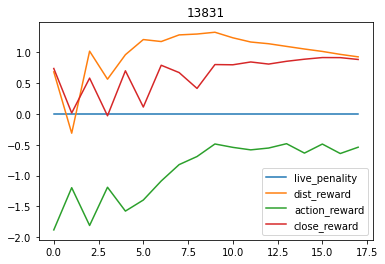

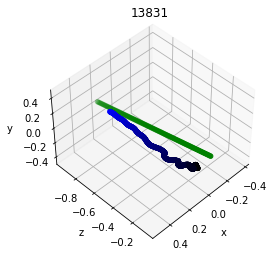

| eval  | E: 466 | S: 13831 | R: 12.8281
| train | E: 467 | S: 13831 | R: 15.8837 | D: 10.1 s | BR: 0.0309 | ALOSS: -7.0223 | CLOSS: 0.3236 | TLOSS: -2.8588 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 468 | S: 13852 | R: 8.6900 | D: 22.5 s | BR: 0.0031 | ALOSS: -7.0211 | CLOSS: 0.2433 | TLOSS: -2.4337 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 469 | S: 13870 | R: 14.8580 | D: 10.4 s | BR: 0.0885 | ALOSS: -7.0333 | CLOSS: 0.2875 | TLOSS: -2.5170 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 470 | S: 13886 | R: 16.4335 | D: 09.3 s | BR: 0.0229 | ALOSS: -7.1014 | CLOSS: 0.2822 | TLOSS: -2.1393 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 471 | S: 13914 | R: 1.4144 | D: 14.9 s | BR: 0.0723 | ALOSS: -7.0240 | CLOSS: 0.3013 | TLOSS: -2.6745 | TVAL: 0.0256 | AENT: -4.0000
| train | E: 472 | S: 13932 | R: 16.1007 | D: 10.4 s | BR: 0.0606 | ALOSS: -7.2879 | CLOSS: 0.2648 | TLOSS: -1.9845 | TVAL: 0.0256 | AENT: -4.0000
| train | E: 473 | S: 13948 | R: 12.4686 | D: 10.2 s | BR: 0.0553 | ALOSS: -6.9

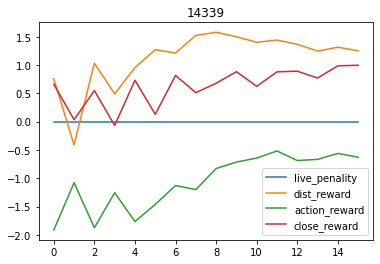

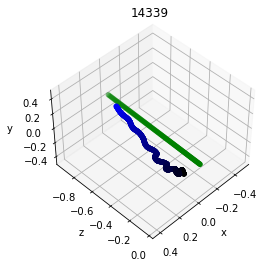

| eval  | E: 492 | S: 14339 | R: 11.0778
| train | E: 493 | S: 14339 | R: 11.1843 | D: 13.2 s | BR: 0.1024 | ALOSS: -7.2259 | CLOSS: 0.2816 | TLOSS: -1.9733 | TVAL: 0.0243 | AENT: -4.0000
| train | E: 494 | S: 14359 | R: 11.9493 | D: 21.0 s | BR: 0.0678 | ALOSS: -7.2388 | CLOSS: 0.2239 | TLOSS: -2.1698 | TVAL: 0.0242 | AENT: -4.0000
| train | E: 495 | S: 14374 | R: 13.8104 | D: 09.6 s | BR: 0.0873 | ALOSS: -7.1955 | CLOSS: 0.2563 | TLOSS: -1.3546 | TVAL: 0.0242 | AENT: -4.0000
| train | E: 496 | S: 14393 | R: 13.3790 | D: 11.2 s | BR: 0.0637 | ALOSS: -7.4391 | CLOSS: 0.2699 | TLOSS: -1.9472 | TVAL: 0.0241 | AENT: -4.0000
| train | E: 497 | S: 14418 | R: 5.9544 | D: 13.7 s | BR: 0.0766 | ALOSS: -7.2813 | CLOSS: 0.2453 | TLOSS: -1.8223 | TVAL: 0.0241 | AENT: -4.0000
| train | E: 498 | S: 14435 | R: 16.0363 | D: 10.0 s | BR: 0.0109 | ALOSS: -7.1047 | CLOSS: 0.2306 | TLOSS: -2.6896 | TVAL: 0.0240 | AENT: -4.0000
| train | E: 499 | S: 14452 | R: 15.2881 | D: 10.6 s | BR: 0.0578 | ALOSS: -7.

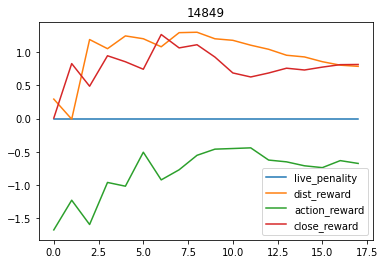

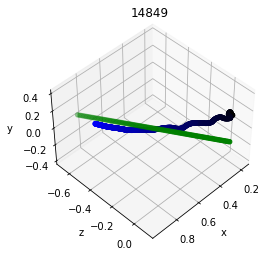

| eval  | E: 517 | S: 14849 | R: 17.0339
| train | E: 518 | S: 14849 | R: 3.4533 | D: 13.9 s | BR: 0.1417 | ALOSS: -7.3660 | CLOSS: 0.2440 | TLOSS: -1.1696 | TVAL: 0.0230 | AENT: -4.0000
| train | E: 519 | S: 14868 | R: 17.6280 | D: 21.4 s | BR: 0.0583 | ALOSS: -7.4690 | CLOSS: 0.2998 | TLOSS: -1.5584 | TVAL: 0.0230 | AENT: -4.0000
| train | E: 520 | S: 14884 | R: 14.8860 | D: 09.8 s | BR: 0.0211 | ALOSS: -7.3024 | CLOSS: 0.3282 | TLOSS: -0.5457 | TVAL: 0.0230 | AENT: -4.0000
| train | E: 521 | S: 14900 | R: 14.5596 | D: 10.3 s | BR: 0.0401 | ALOSS: -7.5067 | CLOSS: 0.2718 | TLOSS: -1.1000 | TVAL: 0.0229 | AENT: -4.0000
| train | E: 522 | S: 14918 | R: 17.6332 | D: 10.7 s | BR: 0.1170 | ALOSS: -7.5936 | CLOSS: 0.2230 | TLOSS: -1.6343 | TVAL: 0.0229 | AENT: -4.0000
| train | E: 523 | S: 14944 | R: 13.2454 | D: 14.5 s | BR: 0.0689 | ALOSS: -7.5493 | CLOSS: 0.2699 | TLOSS: -0.4858 | TVAL: 0.0229 | AENT: -4.0000
| train | E: 524 | S: 14966 | R: 13.2053 | D: 13.3 s | BR: 0.0927 | ALOSS: -7.

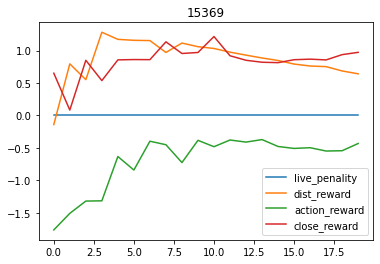

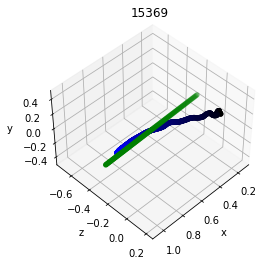

| eval  | E: 542 | S: 15369 | R: 20.3204
| train | E: 543 | S: 15369 | R: 12.5217 | D: 15.6 s | BR: 0.1157 | ALOSS: -7.6849 | CLOSS: 0.2738 | TLOSS: -0.5935 | TVAL: 0.0222 | AENT: -4.0000
| train | E: 544 | S: 15392 | R: 16.9167 | D: 24.4 s | BR: 0.1069 | ALOSS: -7.8506 | CLOSS: 0.2388 | TLOSS: -1.0687 | TVAL: 0.0222 | AENT: -4.0000
| train | E: 545 | S: 15414 | R: 21.2814 | D: 12.3 s | BR: 0.1360 | ALOSS: -7.5855 | CLOSS: 0.2591 | TLOSS: -1.1277 | TVAL: 0.0221 | AENT: -4.0000
| train | E: 546 | S: 15431 | R: 16.5869 | D: 09.8 s | BR: 0.1595 | ALOSS: -7.9056 | CLOSS: 0.2534 | TLOSS: -0.7407 | TVAL: 0.0221 | AENT: -4.0000
| train | E: 547 | S: 15449 | R: 12.1784 | D: 10.5 s | BR: 0.1203 | ALOSS: -7.5769 | CLOSS: 0.2581 | TLOSS: -1.3396 | TVAL: 0.0220 | AENT: -4.0000
| train | E: 548 | S: 15468 | R: 12.8282 | D: 10.9 s | BR: 0.0941 | ALOSS: -7.8193 | CLOSS: 0.2097 | TLOSS: -0.2756 | TVAL: 0.0220 | AENT: -4.0000
| train | E: 549 | S: 15485 | R: 15.5766 | D: 11.1 s | BR: 0.1019 | ALOSS: -8

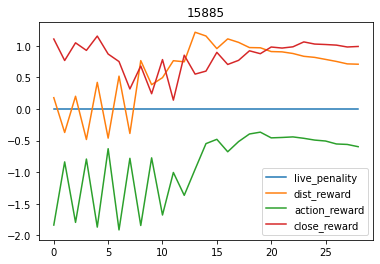

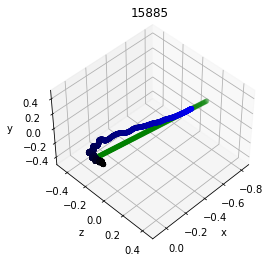

| eval  | E: 568 | S: 15885 | R: 15.8079
| train | E: 569 | S: 15885 | R: 19.6946 | D: 12.4 s | BR: 0.1269 | ALOSS: -8.0428 | CLOSS: 0.2125 | TLOSS: -0.0605 | TVAL: 0.0217 | AENT: -4.0000
| train | E: 570 | S: 15915 | R: 12.9560 | D: 34.4 s | BR: 0.1365 | ALOSS: -8.0802 | CLOSS: 0.2014 | TLOSS: -0.5286 | TVAL: 0.0216 | AENT: -4.0000
| train | E: 571 | S: 15938 | R: 14.3610 | D: 14.1 s | BR: 0.1305 | ALOSS: -8.1947 | CLOSS: 0.1997 | TLOSS: -0.3641 | TVAL: 0.0216 | AENT: -4.0000
| train | E: 572 | S: 15956 | R: 17.2622 | D: 10.4 s | BR: 0.1882 | ALOSS: -8.2575 | CLOSS: 0.2017 | TLOSS: -0.4614 | TVAL: 0.0216 | AENT: -4.0000
| train | E: 573 | S: 15974 | R: 16.3417 | D: 11.4 s | BR: 0.1739 | ALOSS: -8.0219 | CLOSS: 0.2006 | TLOSS: -0.4773 | TVAL: 0.0216 | AENT: -4.0000
| train | E: 574 | S: 15996 | R: 14.5883 | D: 12.2 s | BR: 0.1627 | ALOSS: -8.0266 | CLOSS: 0.2357 | TLOSS: -1.2048 | TVAL: 0.0215 | AENT: -4.0000
| train | E: 575 | S: 16017 | R: 20.8378 | D: 12.9 s | BR: 0.1286 | ALOSS: -8

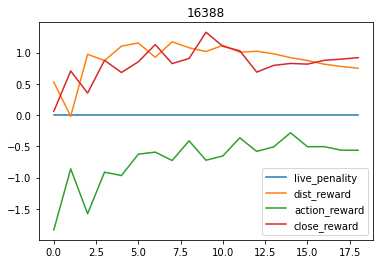

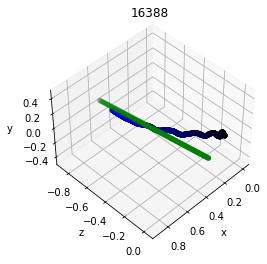

| eval  | E: 591 | S: 16388 | R: 18.9467
| train | E: 592 | S: 16388 | R: 18.9700 | D: 11.2 s | BR: 0.1189 | ALOSS: -7.9996 | CLOSS: 0.2038 | TLOSS: -0.3314 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 593 | S: 16410 | R: 22.7365 | D: 24.5 s | BR: 0.1083 | ALOSS: -8.3502 | CLOSS: 0.2118 | TLOSS: 0.5051 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 594 | S: 16430 | R: 9.9403 | D: 11.5 s | BR: 0.1522 | ALOSS: -8.3887 | CLOSS: 0.1772 | TLOSS: -0.1138 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 595 | S: 16449 | R: 19.5680 | D: 12.1 s | BR: 0.2084 | ALOSS: -8.1056 | CLOSS: 0.2031 | TLOSS: -0.3797 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 596 | S: 16473 | R: 9.0211 | D: 13.1 s | BR: 0.1366 | ALOSS: -8.4008 | CLOSS: 0.2070 | TLOSS: 0.2931 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 597 | S: 16495 | R: 18.9709 | D: 12.5 s | BR: 0.0795 | ALOSS: -8.2979 | CLOSS: 0.2267 | TLOSS: -1.1371 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 598 | S: 16514 | R: 17.5980 | D: 10.9 s | BR: 0.1491 | ALOSS: -8.142

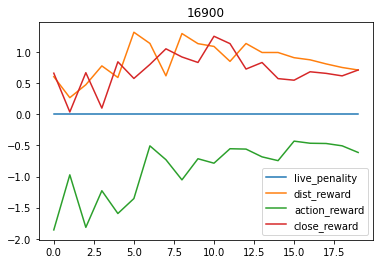

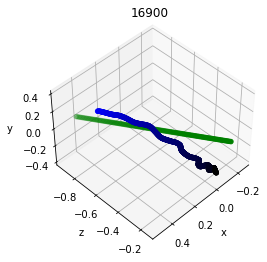

| eval  | E: 615 | S: 16900 | R: 13.8422
| train | E: 616 | S: 16900 | R: 20.9302 | D: 16.6 s | BR: 0.1390 | ALOSS: -8.3294 | CLOSS: 0.2478 | TLOSS: -0.7459 | TVAL: 0.0211 | AENT: -4.0000
| train | E: 617 | S: 16925 | R: 12.7943 | D: 26.6 s | BR: 0.1205 | ALOSS: -8.1936 | CLOSS: 0.2044 | TLOSS: 0.6152 | TVAL: 0.0211 | AENT: -4.0000
| train | E: 618 | S: 16950 | R: 6.3330 | D: 14.8 s | BR: 0.1863 | ALOSS: -8.2094 | CLOSS: 0.2066 | TLOSS: -0.6536 | TVAL: 0.0211 | AENT: -4.0000
| train | E: 619 | S: 16969 | R: 20.7000 | D: 11.0 s | BR: 0.1857 | ALOSS: -8.4207 | CLOSS: 0.2230 | TLOSS: -0.2662 | TVAL: 0.0211 | AENT: -4.0000
| train | E: 620 | S: 16988 | R: 20.3319 | D: 12.1 s | BR: 0.1120 | ALOSS: -8.2204 | CLOSS: 0.1995 | TLOSS: 0.5230 | TVAL: 0.0211 | AENT: -4.0000
| train | E: 621 | S: 17006 | R: 17.1234 | D: 10.7 s | BR: 0.1873 | ALOSS: -8.1394 | CLOSS: 0.1732 | TLOSS: -1.0710 | TVAL: 0.0211 | AENT: -4.0000
| train | E: 622 | S: 17030 | R: 22.8036 | D: 14.5 s | BR: 0.2037 | ALOSS: -8.25

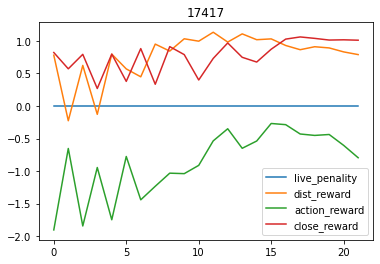

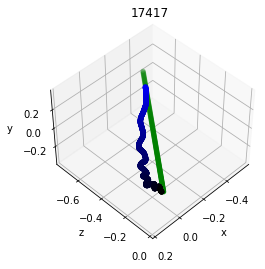

| eval  | E: 638 | S: 17417 | R: 15.3818
| train | E: 639 | S: 17417 | R: 15.2808 | D: 17.7 s | BR: 0.2130 | ALOSS: -8.4263 | CLOSS: 0.1724 | TLOSS: -0.4662 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 640 | S: 17436 | R: 18.2914 | D: 24.7 s | BR: 0.1743 | ALOSS: -8.5150 | CLOSS: 0.1866 | TLOSS: 0.1441 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 641 | S: 17455 | R: 19.4836 | D: 10.7 s | BR: 0.1959 | ALOSS: -8.5474 | CLOSS: 0.2231 | TLOSS: -0.2477 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 642 | S: 17476 | R: 19.9933 | D: 13.2 s | BR: 0.1129 | ALOSS: -8.4120 | CLOSS: 0.2222 | TLOSS: 0.1944 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 643 | S: 17500 | R: 16.5180 | D: 13.2 s | BR: 0.1694 | ALOSS: -8.4226 | CLOSS: 0.1779 | TLOSS: -0.5171 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 644 | S: 17521 | R: 13.9760 | D: 13.2 s | BR: 0.1758 | ALOSS: -8.4204 | CLOSS: 0.1784 | TLOSS: 0.6139 | TVAL: 0.0213 | AENT: -4.0000
| train | E: 645 | S: 17546 | R: 18.8498 | D: 13.6 s | BR: 0.1739 | ALOSS: -8.51

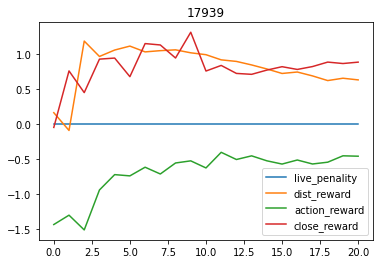

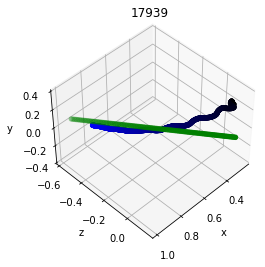

| eval  | E: 661 | S: 17939 | R: 19.7026
| train | E: 662 | S: 17939 | R: 14.1398 | D: 13.2 s | BR: 0.1831 | ALOSS: -8.6207 | CLOSS: 0.2328 | TLOSS: -0.3818 | TVAL: 0.0217 | AENT: -4.0000
| train | E: 663 | S: 17959 | R: 18.0506 | D: 24.5 s | BR: 0.1660 | ALOSS: -8.3238 | CLOSS: 0.2056 | TLOSS: 1.0728 | TVAL: 0.0217 | AENT: -4.0000
| train | E: 664 | S: 17977 | R: 15.1702 | D: 10.8 s | BR: 0.2132 | ALOSS: -8.5462 | CLOSS: 0.1720 | TLOSS: 1.6352 | TVAL: 0.0218 | AENT: -4.0000
| train | E: 665 | S: 17999 | R: 10.0226 | D: 12.1 s | BR: 0.1457 | ALOSS: -8.8178 | CLOSS: 0.1985 | TLOSS: -0.3357 | TVAL: 0.0219 | AENT: -4.0000
| train | E: 666 | S: 18022 | R: 21.0046 | D: 14.5 s | BR: 0.1976 | ALOSS: -8.6155 | CLOSS: 0.1932 | TLOSS: -0.4163 | TVAL: 0.0219 | AENT: -4.0000
| train | E: 667 | S: 18043 | R: 17.9481 | D: 12.0 s | BR: 0.1709 | ALOSS: -8.4917 | CLOSS: 0.2141 | TLOSS: 0.4717 | TVAL: 0.0218 | AENT: -4.0000
| train | E: 668 | S: 18064 | R: 17.8893 | D: 12.0 s | BR: 0.1745 | ALOSS: -8.33

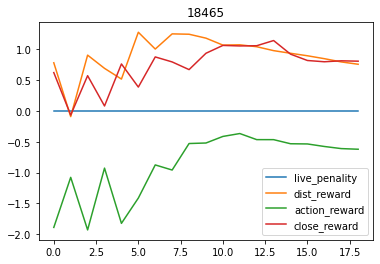

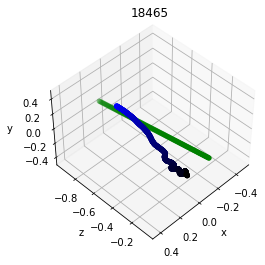

| eval  | E: 684 | S: 18465 | R: 14.5776
| train | E: 685 | S: 18465 | R: 8.4130 | D: 15.1 s | BR: 0.2238 | ALOSS: -8.4515 | CLOSS: 0.2023 | TLOSS: 0.1595 | TVAL: 0.0222 | AENT: -4.0000
| train | E: 686 | S: 18483 | R: 12.5576 | D: 22.2 s | BR: 0.2310 | ALOSS: -8.6115 | CLOSS: 0.1913 | TLOSS: 0.2033 | TVAL: 0.0222 | AENT: -4.0000
| train | E: 687 | S: 18504 | R: 21.8229 | D: 12.8 s | BR: 0.2072 | ALOSS: -8.6679 | CLOSS: 0.1808 | TLOSS: 0.5972 | TVAL: 0.0222 | AENT: -4.0000
| train | E: 688 | S: 18529 | R: 17.6292 | D: 13.7 s | BR: 0.2465 | ALOSS: -8.4690 | CLOSS: 0.1732 | TLOSS: 0.1331 | TVAL: 0.0223 | AENT: -4.0000
| train | E: 689 | S: 18549 | R: 17.2012 | D: 12.8 s | BR: 0.1891 | ALOSS: -8.5421 | CLOSS: 0.2152 | TLOSS: 1.1174 | TVAL: 0.0223 | AENT: -4.0000
| train | E: 690 | S: 18568 | R: 18.8739 | D: 11.3 s | BR: 0.2073 | ALOSS: -8.4676 | CLOSS: 0.1810 | TLOSS: -0.3018 | TVAL: 0.0224 | AENT: -4.0000
| train | E: 691 | S: 18592 | R: 7.3439 | D: 14.7 s | BR: 0.2064 | ALOSS: -8.7391 |

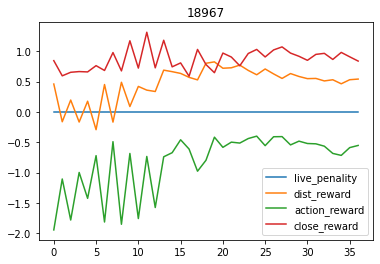

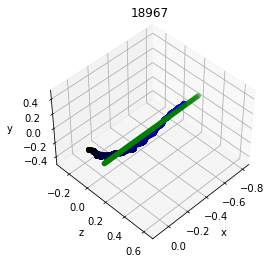

| eval  | E: 707 | S: 18967 | R: 18.8114
| train | E: 708 | S: 18967 | R: 18.5338 | D: 12.0 s | BR: 0.2395 | ALOSS: -8.6801 | CLOSS: 0.1808 | TLOSS: 0.6364 | TVAL: 0.0229 | AENT: -4.0000
| train | E: 709 | S: 18988 | R: 18.8106 | D: 33.3 s | BR: 0.2561 | ALOSS: -8.7103 | CLOSS: 0.1924 | TLOSS: -0.1766 | TVAL: 0.0229 | AENT: -4.0000
| train | E: 710 | S: 19013 | R: 21.4194 | D: 15.1 s | BR: 0.2523 | ALOSS: -8.5902 | CLOSS: 0.1758 | TLOSS: 0.3098 | TVAL: 0.0229 | AENT: -4.0000
| train | E: 711 | S: 19039 | R: 20.6342 | D: 14.4 s | BR: 0.2105 | ALOSS: -8.8910 | CLOSS: 0.1870 | TLOSS: 0.0682 | TVAL: 0.0229 | AENT: -4.0000
| train | E: 712 | S: 19062 | R: 20.7977 | D: 13.6 s | BR: 0.2728 | ALOSS: -8.8856 | CLOSS: 0.1753 | TLOSS: 0.2227 | TVAL: 0.0229 | AENT: -4.0000
| train | E: 713 | S: 19093 | R: 15.3396 | D: 16.7 s | BR: 0.2444 | ALOSS: -8.7357 | CLOSS: 0.1806 | TLOSS: 0.1546 | TVAL: 0.0230 | AENT: -4.0000
| train | E: 714 | S: 19118 | R: 2.8852 | D: 14.7 s | BR: 0.1831 | ALOSS: -8.8402 

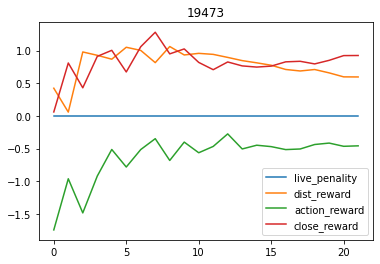

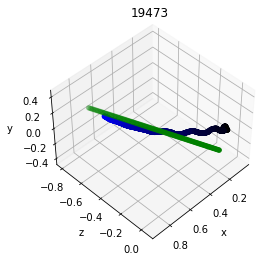

| eval  | E: 728 | S: 19473 | R: 21.4563
| train | E: 729 | S: 19473 | R: 21.3259 | D: 11.2 s | BR: 0.1907 | ALOSS: -8.7291 | CLOSS: 0.2105 | TLOSS: 0.0633 | TVAL: 0.0232 | AENT: -4.0000
| train | E: 730 | S: 19496 | R: 19.0913 | D: 27.7 s | BR: 0.2302 | ALOSS: -8.7551 | CLOSS: 0.1713 | TLOSS: 0.3270 | TVAL: 0.0233 | AENT: -4.0000
| train | E: 731 | S: 19525 | R: 13.9188 | D: 17.1 s | BR: 0.2297 | ALOSS: -8.7687 | CLOSS: 0.1738 | TLOSS: -0.0259 | TVAL: 0.0233 | AENT: -4.0000
| train | E: 732 | S: 19547 | R: 20.6600 | D: 12.2 s | BR: 0.2504 | ALOSS: -8.8138 | CLOSS: 0.1745 | TLOSS: 0.2816 | TVAL: 0.0233 | AENT: -4.0000
| train | E: 733 | S: 19566 | R: 11.2747 | D: 11.9 s | BR: 0.2358 | ALOSS: -8.9198 | CLOSS: 0.1835 | TLOSS: -0.3196 | TVAL: 0.0233 | AENT: -4.0000
| train | E: 734 | S: 19586 | R: 20.0910 | D: 11.1 s | BR: 0.2007 | ALOSS: -8.8510 | CLOSS: 0.1710 | TLOSS: -0.6955 | TVAL: 0.0233 | AENT: -4.0000
| train | E: 735 | S: 19609 | R: 22.2264 | D: 14.0 s | BR: 0.2173 | ALOSS: -8.73

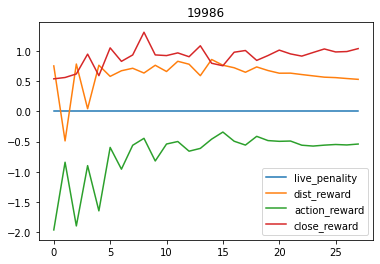

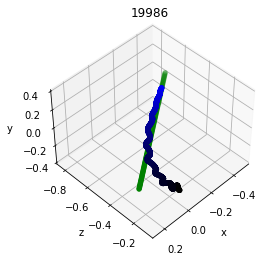

| eval  | E: 749 | S: 19986 | R: 22.6437
| train | E: 750 | S: 19986 | R: 21.0776 | D: 15.7 s | BR: 0.2110 | ALOSS: -8.8848 | CLOSS: 0.2108 | TLOSS: 0.4655 | TVAL: 0.0232 | AENT: -4.0000
| train | E: 751 | S: 20006 | R: 11.5932 | D: 26.8 s | BR: 0.2771 | ALOSS: -8.7176 | CLOSS: 0.1596 | TLOSS: -0.5596 | TVAL: 0.0233 | AENT: -4.0000
| train | E: 752 | S: 20026 | R: 11.6255 | D: 12.3 s | BR: 0.2381 | ALOSS: -8.6424 | CLOSS: 0.1725 | TLOSS: 0.0929 | TVAL: 0.0232 | AENT: -4.0000
| train | E: 753 | S: 20047 | R: 20.0155 | D: 12.0 s | BR: 0.2504 | ALOSS: -8.9695 | CLOSS: 0.1740 | TLOSS: 1.7792 | TVAL: 0.0233 | AENT: -4.0000
| train | E: 754 | S: 20070 | R: 19.2003 | D: 12.6 s | BR: 0.2311 | ALOSS: -8.7725 | CLOSS: 0.1830 | TLOSS: -0.4568 | TVAL: 0.0234 | AENT: -4.0000
| train | E: 755 | S: 20096 | R: 19.5698 | D: 14.2 s | BR: 0.2560 | ALOSS: -8.9808 | CLOSS: 0.1803 | TLOSS: 0.3775 | TVAL: 0.0233 | AENT: -4.0000
| train | E: 756 | S: 20119 | R: 20.8280 | D: 12.7 s | BR: 0.2287 | ALOSS: -8.847

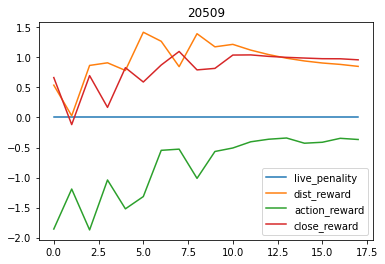

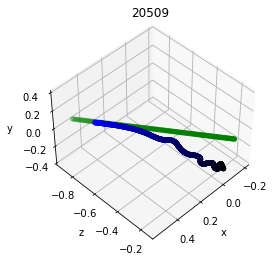

| eval  | E: 771 | S: 20509 | R: 16.9827
| train | E: 772 | S: 20509 | R: 17.5163 | D: 19.4 s | BR: 0.2685 | ALOSS: -8.8327 | CLOSS: 0.1714 | TLOSS: 0.0990 | TVAL: 0.0239 | AENT: -4.0000
| train | E: 773 | S: 20535 | R: 20.6752 | D: 25.6 s | BR: 0.2432 | ALOSS: -9.0630 | CLOSS: 0.1624 | TLOSS: 0.8135 | TVAL: 0.0240 | AENT: -4.0000
| train | E: 774 | S: 20565 | R: 14.7523 | D: 16.0 s | BR: 0.2471 | ALOSS: -8.8980 | CLOSS: 0.1655 | TLOSS: 0.5078 | TVAL: 0.0241 | AENT: -4.0000
| train | E: 775 | S: 20593 | R: 19.8127 | D: 15.4 s | BR: 0.2098 | ALOSS: -8.9034 | CLOSS: 0.1779 | TLOSS: 0.4459 | TVAL: 0.0241 | AENT: -4.0000
| train | E: 776 | S: 20616 | R: 10.0770 | D: 13.1 s | BR: 0.2544 | ALOSS: -8.9160 | CLOSS: 0.1788 | TLOSS: 1.0204 | TVAL: 0.0242 | AENT: -4.0000
| train | E: 777 | S: 20637 | R: 17.8219 | D: 11.5 s | BR: 0.2638 | ALOSS: -8.9265 | CLOSS: 0.1557 | TLOSS: -0.3561 | TVAL: 0.0243 | AENT: -4.0000
| train | E: 778 | S: 20663 | R: 12.5282 | D: 14.1 s | BR: 0.2649 | ALOSS: -8.9122

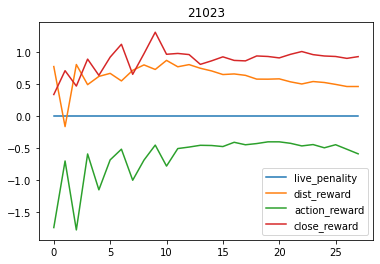

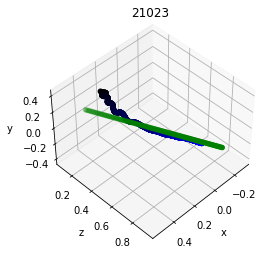

| eval  | E: 792 | S: 21023 | R: 24.2907
| train | E: 793 | S: 21023 | R: 13.2418 | D: 15.7 s | BR: 0.3103 | ALOSS: -9.0425 | CLOSS: 0.1615 | TLOSS: 0.1866 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 794 | S: 21050 | R: 21.6213 | D: 31.4 s | BR: 0.2724 | ALOSS: -9.1892 | CLOSS: 0.1691 | TLOSS: 0.0092 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 795 | S: 21074 | R: 16.1080 | D: 13.1 s | BR: 0.2237 | ALOSS: -9.0350 | CLOSS: 0.1950 | TLOSS: -0.0251 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 796 | S: 21094 | R: 16.8601 | D: 11.3 s | BR: 0.3133 | ALOSS: -8.9146 | CLOSS: 0.1510 | TLOSS: -0.3565 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 797 | S: 21120 | R: 22.4281 | D: 14.1 s | BR: 0.2548 | ALOSS: -9.0189 | CLOSS: 0.1665 | TLOSS: -0.2902 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 798 | S: 21146 | R: 23.3941 | D: 14.1 s | BR: 0.2955 | ALOSS: -9.0898 | CLOSS: 0.1520 | TLOSS: 0.1634 | TVAL: 0.0243 | AENT: -4.0000
| train | E: 799 | S: 21177 | R: 18.9693 | D: 17.0 s | BR: 0.2677 | ALOSS: -9.15

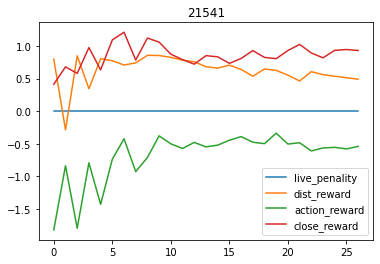

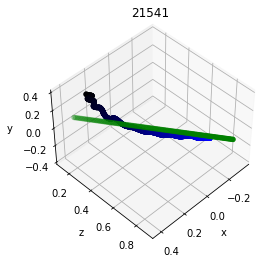

| eval  | E: 813 | S: 21541 | R: 21.8652
| train | E: 814 | S: 21541 | R: 14.3417 | D: 15.6 s | BR: 0.2825 | ALOSS: -8.9370 | CLOSS: 0.1534 | TLOSS: 0.4572 | TVAL: 0.0245 | AENT: -4.0000
| train | E: 815 | S: 21565 | R: 21.6282 | D: 29.2 s | BR: 0.2791 | ALOSS: -9.0144 | CLOSS: 0.1761 | TLOSS: -0.1505 | TVAL: 0.0246 | AENT: -4.0000
| train | E: 816 | S: 21587 | R: 20.4245 | D: 12.5 s | BR: 0.2674 | ALOSS: -8.8032 | CLOSS: 0.1752 | TLOSS: 1.1349 | TVAL: 0.0246 | AENT: -4.0000
| train | E: 817 | S: 21612 | R: 1.6342 | D: 13.7 s | BR: 0.3417 | ALOSS: -9.0773 | CLOSS: 0.1722 | TLOSS: 0.0344 | TVAL: 0.0247 | AENT: -4.0000
| train | E: 818 | S: 21631 | R: 13.9068 | D: 10.6 s | BR: 0.2659 | ALOSS: -9.1400 | CLOSS: 0.1671 | TLOSS: 0.0683 | TVAL: 0.0247 | AENT: -4.0000
| train | E: 819 | S: 21653 | R: 21.2213 | D: 11.9 s | BR: 0.2200 | ALOSS: -9.1013 | CLOSS: 0.1728 | TLOSS: 0.4318 | TVAL: 0.0247 | AENT: -4.0000
| train | E: 820 | S: 21677 | R: 20.0848 | D: 13.1 s | BR: 0.2455 | ALOSS: -9.2633 

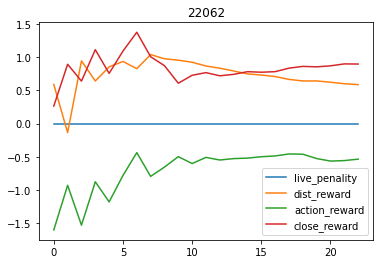

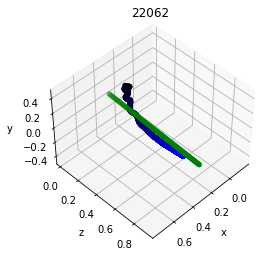

| eval  | E: 835 | S: 22062 | R: 20.1087
| train | E: 836 | S: 22062 | R: 21.8205 | D: 14.6 s | BR: 0.2824 | ALOSS: -9.2308 | CLOSS: 0.1516 | TLOSS: 0.4515 | TVAL: 0.0250 | AENT: -4.0000
| train | E: 837 | S: 22081 | R: 10.7518 | D: 25.1 s | BR: 0.2894 | ALOSS: -9.0592 | CLOSS: 0.2631 | TLOSS: -0.0335 | TVAL: 0.0250 | AENT: -4.0000
| train | E: 838 | S: 22101 | R: 18.1175 | D: 11.2 s | BR: 0.2865 | ALOSS: -9.1701 | CLOSS: 0.1739 | TLOSS: -0.1213 | TVAL: 0.0250 | AENT: -4.0000
| train | E: 839 | S: 22133 | R: 14.5724 | D: 16.9 s | BR: 0.2498 | ALOSS: -9.0710 | CLOSS: 0.1697 | TLOSS: 0.3299 | TVAL: 0.0250 | AENT: -4.0000
| train | E: 840 | S: 22165 | R: 16.7021 | D: 17.2 s | BR: 0.3101 | ALOSS: -8.9419 | CLOSS: 0.1513 | TLOSS: -0.0024 | TVAL: 0.0250 | AENT: -4.0000
| train | E: 841 | S: 22191 | R: 20.6981 | D: 14.2 s | BR: 0.2745 | ALOSS: -8.9437 | CLOSS: 0.1829 | TLOSS: -0.1509 | TVAL: 0.0250 | AENT: -4.0000
| train | E: 842 | S: 22215 | R: 21.1397 | D: 13.1 s | BR: 0.2676 | ALOSS: -9.0

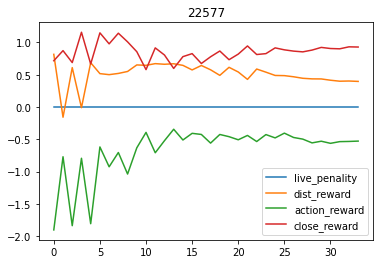

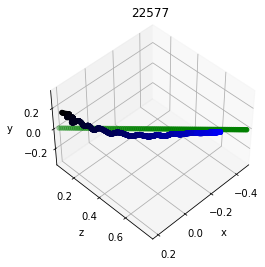

| eval  | E: 854 | S: 22577 | R: 23.7539
| train | E: 855 | S: 22577 | R: 16.6399 | D: 21.5 s | BR: 0.2933 | ALOSS: -9.1730 | CLOSS: 0.1677 | TLOSS: -0.2871 | TVAL: 0.0251 | AENT: -4.0000
| train | E: 856 | S: 22604 | R: 23.2879 | D: 39.4 s | BR: 0.2744 | ALOSS: -9.3704 | CLOSS: 0.1699 | TLOSS: 0.2033 | TVAL: 0.0251 | AENT: -4.0000
| train | E: 857 | S: 22625 | R: 20.8226 | D: 12.3 s | BR: 0.2395 | ALOSS: -9.1641 | CLOSS: 0.1950 | TLOSS: -0.1003 | TVAL: 0.0251 | AENT: -4.0000
| train | E: 858 | S: 22652 | R: 18.9551 | D: 15.6 s | BR: 0.2896 | ALOSS: -9.2844 | CLOSS: 0.1896 | TLOSS: 0.0306 | TVAL: 0.0251 | AENT: -4.0000
| train | E: 859 | S: 22680 | R: 15.4017 | D: 15.3 s | BR: 0.3166 | ALOSS: -9.3252 | CLOSS: 0.1485 | TLOSS: 0.1935 | TVAL: 0.0251 | AENT: -4.0000
| train | E: 860 | S: 22707 | R: 20.2281 | D: 14.7 s | BR: 0.2828 | ALOSS: -9.1051 | CLOSS: 0.1565 | TLOSS: -0.1226 | TVAL: 0.0252 | AENT: -4.0000
| train | E: 861 | S: 22739 | R: 17.1313 | D: 17.0 s | BR: 0.2897 | ALOSS: -9.14

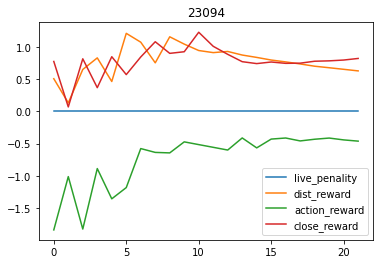

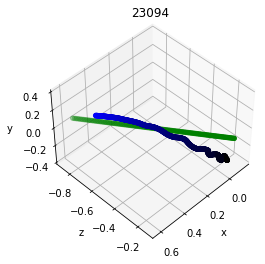

| eval  | E: 874 | S: 23094 | R: 18.3114
| train | E: 875 | S: 23094 | R: 18.7035 | D: 16.1 s | BR: 0.3388 | ALOSS: -9.2117 | CLOSS: 0.1608 | TLOSS: -0.3539 | TVAL: 0.0255 | AENT: -4.0000
| train | E: 876 | S: 23115 | R: 20.0263 | D: 24.4 s | BR: 0.3648 | ALOSS: -9.3904 | CLOSS: 0.1464 | TLOSS: -0.5147 | TVAL: 0.0254 | AENT: -4.0000
| train | E: 877 | S: 23138 | R: 17.9925 | D: 13.9 s | BR: 0.3291 | ALOSS: -9.1814 | CLOSS: 0.1561 | TLOSS: 0.2489 | TVAL: 0.0254 | AENT: -4.0000
| train | E: 878 | S: 23169 | R: 15.1257 | D: 16.5 s | BR: 0.2807 | ALOSS: -9.2146 | CLOSS: 0.1520 | TLOSS: 0.4641 | TVAL: 0.0254 | AENT: -4.0000
| train | E: 879 | S: 23189 | R: 17.6284 | D: 12.1 s | BR: 0.3123 | ALOSS: -9.2771 | CLOSS: 0.1435 | TLOSS: -0.0163 | TVAL: 0.0255 | AENT: -4.0000
| train | E: 880 | S: 23216 | R: 15.0900 | D: 16.2 s | BR: 0.3094 | ALOSS: -9.2316 | CLOSS: 0.1499 | TLOSS: -0.2791 | TVAL: 0.0254 | AENT: -4.0000
| train | E: 881 | S: 23236 | R: 21.1438 | D: 11.5 s | BR: 0.3309 | ALOSS: -9.2

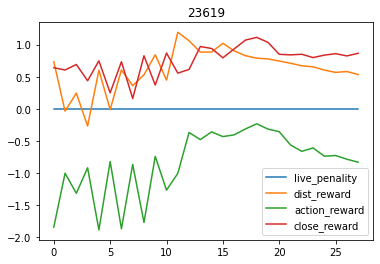

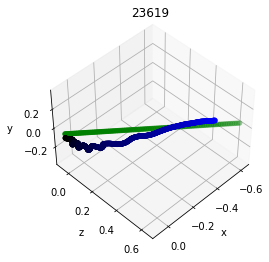

| eval  | E: 895 | S: 23619 | R: 15.0126
| train | E: 896 | S: 23619 | R: 23.3034 | D: 14.5 s | BR: 0.2797 | ALOSS: -9.0652 | CLOSS: 0.1653 | TLOSS: -0.1357 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 897 | S: 23646 | R: 22.0127 | D: 31.0 s | BR: 0.3336 | ALOSS: -9.3740 | CLOSS: 0.1720 | TLOSS: 0.3758 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 898 | S: 23673 | R: 20.7651 | D: 16.2 s | BR: 0.3330 | ALOSS: -9.1579 | CLOSS: 0.1600 | TLOSS: -0.1896 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 899 | S: 23693 | R: 13.8333 | D: 11.6 s | BR: 0.3062 | ALOSS: -9.3311 | CLOSS: 0.1655 | TLOSS: -0.1650 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 900 | S: 23720 | R: 10.7681 | D: 15.0 s | BR: 0.3359 | ALOSS: -9.1483 | CLOSS: 0.1516 | TLOSS: 0.3033 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 901 | S: 23749 | R: 17.9606 | D: 16.6 s | BR: 0.3111 | ALOSS: -9.4635 | CLOSS: 0.1345 | TLOSS: 0.0349 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 902 | S: 23776 | R: 19.1823 | D: 14.5 s | BR: 0.3061 | ALOSS: -9.43

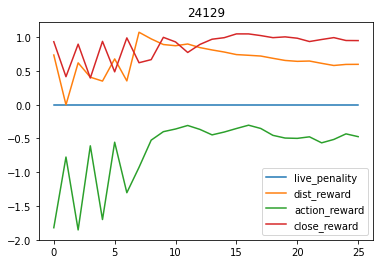

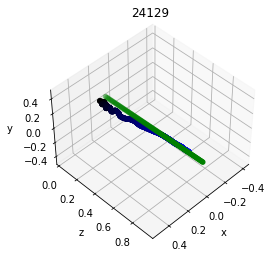

| eval  | E: 915 | S: 24129 | R: 23.0824
| train | E: 916 | S: 24129 | R: 17.9685 | D: 14.1 s | BR: 0.3199 | ALOSS: -9.3826 | CLOSS: 0.1780 | TLOSS: -0.0834 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 917 | S: 24156 | R: 22.1351 | D: 28.7 s | BR: 0.2685 | ALOSS: -9.2289 | CLOSS: 0.1599 | TLOSS: 0.6787 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 918 | S: 24182 | R: 15.2431 | D: 15.7 s | BR: 0.3375 | ALOSS: -9.3885 | CLOSS: 0.1420 | TLOSS: 0.2655 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 919 | S: 24211 | R: 19.2814 | D: 16.9 s | BR: 0.3210 | ALOSS: -9.2163 | CLOSS: 0.1491 | TLOSS: 0.4027 | TVAL: 0.0260 | AENT: -4.0000
| train | E: 920 | S: 24241 | R: 20.7016 | D: 16.3 s | BR: 0.3058 | ALOSS: -9.5729 | CLOSS: 0.1469 | TLOSS: -0.2464 | TVAL: 0.0260 | AENT: -4.0000
| train | E: 921 | S: 24265 | R: 15.7895 | D: 13.4 s | BR: 0.3319 | ALOSS: -9.2611 | CLOSS: 0.1365 | TLOSS: -0.1929 | TVAL: 0.0260 | AENT: -4.0000
| train | E: 922 | S: 24287 | R: 22.7672 | D: 12.5 s | BR: 0.3182 | ALOSS: -9.33

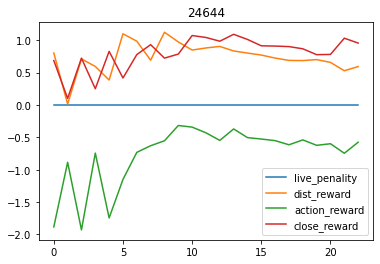

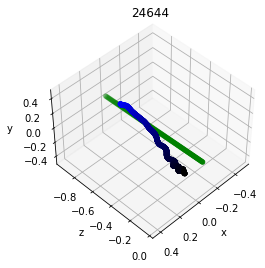

| eval  | E: 934 | S: 24644 | R: 18.0438
| train | E: 935 | S: 24644 | R: 18.5288 | D: 11.6 s | BR: 0.3121 | ALOSS: -9.5445 | CLOSS: 0.1430 | TLOSS: -0.4426 | TVAL: 0.0261 | AENT: -4.0000
| train | E: 936 | S: 24667 | R: 19.1588 | D: 27.8 s | BR: 0.3698 | ALOSS: -9.3600 | CLOSS: 0.1382 | TLOSS: -0.0454 | TVAL: 0.0260 | AENT: -4.0000
| train | E: 937 | S: 24688 | R: 19.7656 | D: 11.7 s | BR: 0.3406 | ALOSS: -9.5139 | CLOSS: 0.1639 | TLOSS: -0.1242 | TVAL: 0.0260 | AENT: -4.0000
| train | E: 938 | S: 24708 | R: 14.4709 | D: 11.2 s | BR: 0.3150 | ALOSS: -9.2491 | CLOSS: 0.1796 | TLOSS: -0.7529 | TVAL: 0.0260 | AENT: -4.0000
| train | E: 939 | S: 24737 | R: 21.5828 | D: 16.9 s | BR: 0.3063 | ALOSS: -9.6039 | CLOSS: 0.1442 | TLOSS: 0.0505 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 940 | S: 24760 | R: 22.3681 | D: 13.2 s | BR: 0.3316 | ALOSS: -9.1642 | CLOSS: 0.1473 | TLOSS: 0.5794 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 941 | S: 24788 | R: 24.8800 | D: 14.8 s | BR: 0.3487 | ALOSS: -9.5

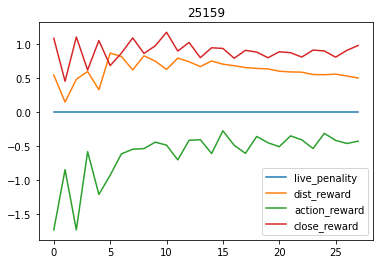

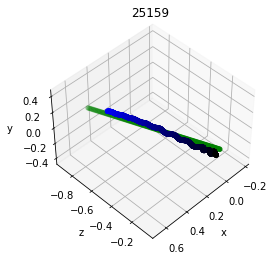

| eval  | E: 954 | S: 25159 | R: 24.9746
| train | E: 955 | S: 25159 | R: 17.5836 | D: 14.8 s | BR: 0.3505 | ALOSS: -9.4305 | CLOSS: 0.1392 | TLOSS: 1.0702 | TVAL: 0.0264 | AENT: -4.0000
| train | E: 956 | S: 25180 | R: 19.7682 | D: 28.3 s | BR: 0.3607 | ALOSS: -9.5240 | CLOSS: 0.1679 | TLOSS: -0.3074 | TVAL: 0.0264 | AENT: -4.0000
| train | E: 957 | S: 25205 | R: 21.2736 | D: 14.0 s | BR: 0.3290 | ALOSS: -9.5623 | CLOSS: 0.1347 | TLOSS: 0.8561 | TVAL: 0.0265 | AENT: -4.0000
| train | E: 958 | S: 25229 | R: 12.0122 | D: 14.5 s | BR: 0.3447 | ALOSS: -9.5484 | CLOSS: 0.1486 | TLOSS: -0.3426 | TVAL: 0.0265 | AENT: -4.0000
| train | E: 959 | S: 25260 | R: 18.5513 | D: 16.8 s | BR: 0.3324 | ALOSS: -9.5218 | CLOSS: 0.1755 | TLOSS: 0.1062 | TVAL: 0.0265 | AENT: -4.0000
| train | E: 960 | S: 25291 | R: 11.7282 | D: 18.8 s | BR: 0.3719 | ALOSS: -9.6111 | CLOSS: 0.1414 | TLOSS: 0.2301 | TVAL: 0.0265 | AENT: -4.0000
| train | E: 961 | S: 25310 | R: 17.8443 | D: 11.0 s | BR: 0.3585 | ALOSS: -9.373

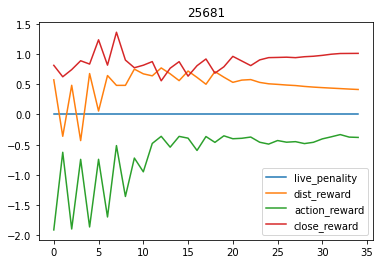

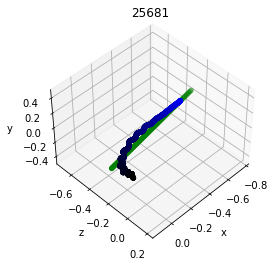

| eval  | E: 974 | S: 25681 | R: 24.7612
| train | E: 975 | S: 25681 | R: 22.1880 | D: 17.1 s | BR: 0.3327 | ALOSS: -9.5337 | CLOSS: 0.1587 | TLOSS: 0.5077 | TVAL: 0.0266 | AENT: -4.0000
| train | E: 976 | S: 25705 | R: 16.1649 | D: 33.3 s | BR: 0.3520 | ALOSS: -9.2496 | CLOSS: 0.1526 | TLOSS: -0.2496 | TVAL: 0.0267 | AENT: -4.0000
| train | E: 977 | S: 25732 | R: 19.5517 | D: 16.1 s | BR: 0.3074 | ALOSS: -9.5182 | CLOSS: 0.1545 | TLOSS: 0.1435 | TVAL: 0.0267 | AENT: -4.0000
| train | E: 978 | S: 25760 | R: 15.5760 | D: 15.2 s | BR: 0.3540 | ALOSS: -9.6611 | CLOSS: 0.1453 | TLOSS: -0.3385 | TVAL: 0.0267 | AENT: -4.0000
| train | E: 979 | S: 25792 | R: 26.6809 | D: 19.0 s | BR: 0.3424 | ALOSS: -9.4234 | CLOSS: 0.1691 | TLOSS: 0.3417 | TVAL: 0.0267 | AENT: -4.0000
| train | E: 980 | S: 25823 | R: 23.2769 | D: 16.6 s | BR: 0.3401 | ALOSS: -9.4919 | CLOSS: 0.1556 | TLOSS: 0.2170 | TVAL: 0.0267 | AENT: -4.0000
| train | E: 981 | S: 25856 | R: 24.5013 | D: 18.9 s | BR: 0.3766 | ALOSS: -9.261

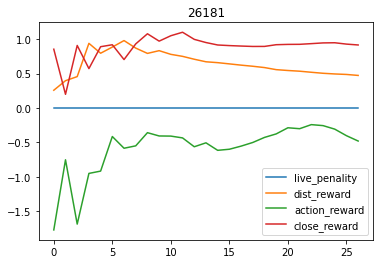

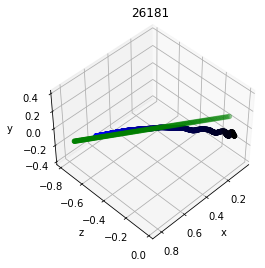

| eval  | E: 991 | S: 26181 | R: 25.7227
| train | E: 992 | S: 26181 | R: 20.4552 | D: 17.5 s | BR: 0.3821 | ALOSS: -9.6024 | CLOSS: 0.1361 | TLOSS: 0.5202 | TVAL: 0.0269 | AENT: -4.0000
| train | E: 993 | S: 26200 | R: 16.6956 | D: 27.0 s | BR: 0.3610 | ALOSS: -9.5282 | CLOSS: 0.1410 | TLOSS: 0.5005 | TVAL: 0.0269 | AENT: -4.0000
| train | E: 994 | S: 26226 | R: 25.6704 | D: 14.4 s | BR: 0.3957 | ALOSS: -9.4581 | CLOSS: 0.1431 | TLOSS: 0.6705 | TVAL: 0.0270 | AENT: -4.0000
| train | E: 995 | S: 26253 | R: 24.9498 | D: 15.4 s | BR: 0.3503 | ALOSS: -9.5651 | CLOSS: 0.1543 | TLOSS: -0.1904 | TVAL: 0.0271 | AENT: -4.0000
| train | E: 996 | S: 26282 | R: 18.3917 | D: 17.3 s | BR: 0.3635 | ALOSS: -9.4566 | CLOSS: 0.1344 | TLOSS: 0.9175 | TVAL: 0.0271 | AENT: -4.0000
| train | E: 997 | S: 26308 | R: 26.0907 | D: 15.2 s | BR: 0.3520 | ALOSS: -9.5344 | CLOSS: 0.1256 | TLOSS: -0.1257 | TVAL: 0.0272 | AENT: -4.0000
| train | E: 998 | S: 26334 | R: 23.4660 | D: 14.0 s | BR: 0.3471 | ALOSS: -9.538

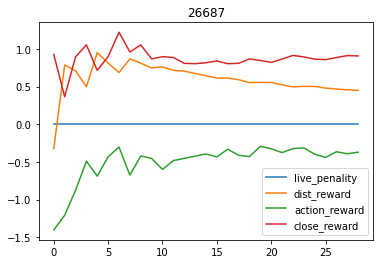

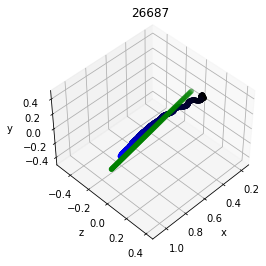

| eval  | E: 1011 | S: 26687 | R: 28.0937
| train | E: 1012 | S: 26687 | R: 17.2085 | D: 13.2 s | BR: 0.3366 | ALOSS: -9.6565 | CLOSS: 0.1349 | TLOSS: -0.2588 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 1013 | S: 26714 | R: 24.6657 | D: 32.9 s | BR: 0.3344 | ALOSS: -9.3303 | CLOSS: 0.1525 | TLOSS: 0.1873 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 1014 | S: 26751 | R: 19.1399 | D: 19.9 s | BR: 0.3323 | ALOSS: -9.7241 | CLOSS: 0.1444 | TLOSS: 0.3158 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 1015 | S: 26794 | R: 7.9547 | D: 23.9 s | BR: 0.3574 | ALOSS: -9.5491 | CLOSS: 0.1400 | TLOSS: -0.4603 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 1016 | S: 26824 | R: 20.4057 | D: 19.1 s | BR: 0.3975 | ALOSS: -9.5140 | CLOSS: 0.1333 | TLOSS: -0.0212 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 1017 | S: 26845 | R: 11.5676 | D: 15.7 s | BR: 0.3853 | ALOSS: -9.8243 | CLOSS: 0.1399 | TLOSS: -0.1261 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 1018 | S: 26870 | R: 21.7918 | D: 14.3 s | BR: 0.3998 | ALOS

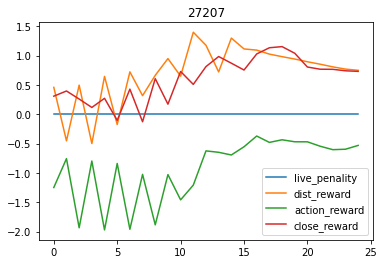

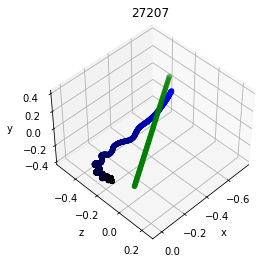

| eval  | E: 1029 | S: 27207 | R: 9.5970
| train | E: 1030 | S: 27207 | R: 18.6977 | D: 14.4 s | BR: 0.3427 | ALOSS: -9.4471 | CLOSS: 0.1300 | TLOSS: 0.1776 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 1031 | S: 27237 | R: 26.3231 | D: 36.1 s | BR: 0.3931 | ALOSS: -9.5068 | CLOSS: 0.1281 | TLOSS: 0.2527 | TVAL: 0.0277 | AENT: -4.0000
| train | E: 1032 | S: 27257 | R: 19.6324 | D: 12.6 s | BR: 0.4019 | ALOSS: -9.5266 | CLOSS: 0.1350 | TLOSS: 0.0335 | TVAL: 0.0277 | AENT: -4.0000
| train | E: 1033 | S: 27287 | R: 19.8226 | D: 16.9 s | BR: 0.3521 | ALOSS: -9.3467 | CLOSS: 0.1518 | TLOSS: 0.5397 | TVAL: 0.0278 | AENT: -4.0000
| train | E: 1034 | S: 27315 | R: 26.2588 | D: 17.0 s | BR: 0.3591 | ALOSS: -9.7415 | CLOSS: 0.1415 | TLOSS: -0.6455 | TVAL: 0.0278 | AENT: -4.0000
| train | E: 1035 | S: 27337 | R: 10.7715 | D: 12.5 s | BR: 0.3726 | ALOSS: -9.7143 | CLOSS: 0.1533 | TLOSS: 0.5817 | TVAL: 0.0278 | AENT: -4.0000
| train | E: 1036 | S: 27376 | R: 23.1498 | D: 23.0 s | BR: 0.3608 | ALOSS: 

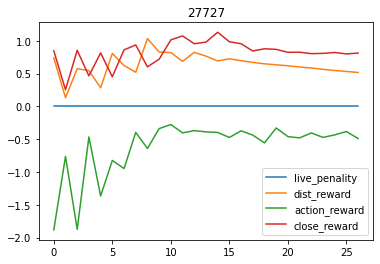

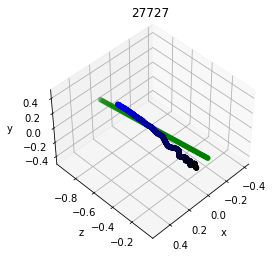

| eval  | E: 1047 | S: 27727 | R: 22.8652
| train | E: 1048 | S: 27727 | R: 27.1919 | D: 17.8 s | BR: 0.3831 | ALOSS: -9.6130 | CLOSS: 0.1199 | TLOSS: -0.1769 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1049 | S: 27754 | R: 26.9644 | D: 30.5 s | BR: 0.3916 | ALOSS: -9.7180 | CLOSS: 0.1145 | TLOSS: -0.0415 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1050 | S: 27782 | R: 22.2843 | D: 17.5 s | BR: 0.3671 | ALOSS: -9.5042 | CLOSS: 0.1623 | TLOSS: -0.4409 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1051 | S: 27818 | R: 20.2312 | D: 20.4 s | BR: 0.3864 | ALOSS: -9.5401 | CLOSS: 0.1424 | TLOSS: 0.4809 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1052 | S: 27842 | R: 21.3889 | D: 17.2 s | BR: 0.3994 | ALOSS: -9.6716 | CLOSS: 0.1290 | TLOSS: 0.0697 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1053 | S: 27875 | R: 10.0263 | D: 20.9 s | BR: 0.3739 | ALOSS: -9.6516 | CLOSS: 0.1289 | TLOSS: -0.4572 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1054 | S: 27898 | R: 23.0634 | D: 15.0 s | BR: 0.3857 | ALO

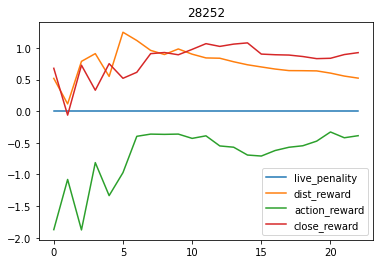

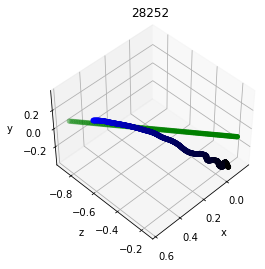

| eval  | E: 1066 | S: 28252 | R: 19.5840
| train | E: 1067 | S: 28252 | R: 20.5165 | D: 20.3 s | BR: 0.4201 | ALOSS: -9.6420 | CLOSS: 0.1286 | TLOSS: -0.0993 | TVAL: 0.0281 | AENT: -4.0000
| train | E: 1068 | S: 28282 | R: 26.3429 | D: 33.4 s | BR: 0.3713 | ALOSS: -9.6252 | CLOSS: 0.1432 | TLOSS: -0.1143 | TVAL: 0.0281 | AENT: -4.0000
| train | E: 1069 | S: 28307 | R: 22.7669 | D: 14.7 s | BR: 0.3667 | ALOSS: -9.3792 | CLOSS: 0.1426 | TLOSS: -0.0065 | TVAL: 0.0281 | AENT: -4.0000
| train | E: 1070 | S: 28343 | R: 23.5519 | D: 20.8 s | BR: 0.3623 | ALOSS: -9.6797 | CLOSS: 0.1281 | TLOSS: 0.4255 | TVAL: 0.0281 | AENT: -4.0000
| train | E: 1071 | S: 28367 | R: 18.4675 | D: 14.0 s | BR: 0.3625 | ALOSS: -9.6209 | CLOSS: 0.1567 | TLOSS: 0.5695 | TVAL: 0.0282 | AENT: -4.0000
| train | E: 1072 | S: 28390 | R: 13.7290 | D: 13.9 s | BR: 0.3837 | ALOSS: -9.6378 | CLOSS: 0.1188 | TLOSS: 0.3781 | TVAL: 0.0283 | AENT: -4.0000
| train | E: 1073 | S: 28425 | R: 18.2676 | D: 19.6 s | BR: 0.4123 | ALOS

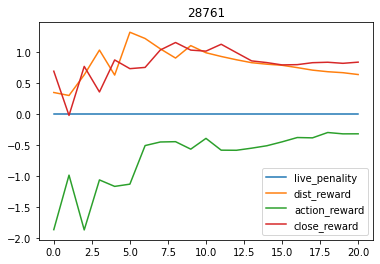

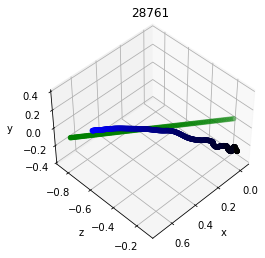

| eval  | E: 1084 | S: 28761 | R: 19.1384
| train | E: 1085 | S: 28761 | R: 16.5815 | D: 15.3 s | BR: 0.3578 | ALOSS: -9.7762 | CLOSS: 0.1486 | TLOSS: 0.0313 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1086 | S: 28785 | R: 22.6077 | D: 27.1 s | BR: 0.3965 | ALOSS: -9.7053 | CLOSS: 0.1359 | TLOSS: 0.4205 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1087 | S: 28812 | R: 24.0074 | D: 17.2 s | BR: 0.4079 | ALOSS: -9.6461 | CLOSS: 0.1233 | TLOSS: -0.5079 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1088 | S: 28853 | R: 17.1634 | D: 22.3 s | BR: 0.3883 | ALOSS: -9.7089 | CLOSS: 0.1168 | TLOSS: 0.0598 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1089 | S: 28880 | R: 20.4408 | D: 17.2 s | BR: 0.3889 | ALOSS: -9.6290 | CLOSS: 0.1101 | TLOSS: 0.1380 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1090 | S: 28907 | R: 22.6202 | D: 15.5 s | BR: 0.3961 | ALOSS: -9.8182 | CLOSS: 0.1225 | TLOSS: -0.1801 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1091 | S: 28935 | R: 27.0800 | D: 17.5 s | BR: 0.4002 | ALOSS

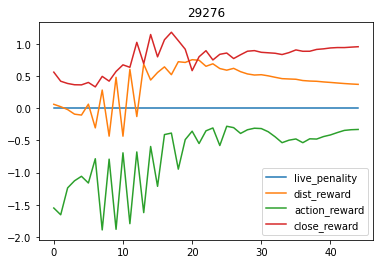

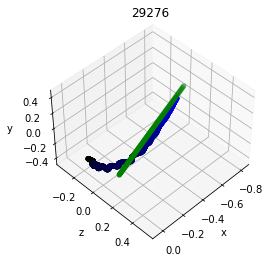

| eval  | E: 1102 | S: 29276 | R: 20.2167
| train | E: 1103 | S: 29276 | R: 23.0679 | D: 18.7 s | BR: 0.4172 | ALOSS: -9.7169 | CLOSS: 0.1119 | TLOSS: 0.2748 | TVAL: 0.0286 | AENT: -4.0000
| train | E: 1104 | S: 29314 | R: 13.9226 | D: 53.2 s | BR: 0.3989 | ALOSS: -9.8756 | CLOSS: 0.1139 | TLOSS: 0.3735 | TVAL: 0.0287 | AENT: -4.0000
| train | E: 1105 | S: 29340 | R: 22.3539 | D: 15.7 s | BR: 0.3882 | ALOSS: -9.7417 | CLOSS: 0.1174 | TLOSS: 0.3548 | TVAL: 0.0288 | AENT: -4.0000
| train | E: 1106 | S: 29365 | R: 21.1945 | D: 16.4 s | BR: 0.3402 | ALOSS: -9.6507 | CLOSS: 0.1191 | TLOSS: 0.2174 | TVAL: 0.0289 | AENT: -4.0000
| train | E: 1107 | S: 29389 | R: 23.3610 | D: 15.2 s | BR: 0.3852 | ALOSS: -9.4833 | CLOSS: 0.1105 | TLOSS: -0.2342 | TVAL: 0.0289 | AENT: -4.0000
| train | E: 1108 | S: 29416 | R: 10.0178 | D: 21.1 s | BR: 0.4177 | ALOSS: -9.7030 | CLOSS: 0.1057 | TLOSS: 0.2317 | TVAL: 0.0288 | AENT: -4.0000
| train | E: 1109 | S: 29440 | R: 24.0826 | D: 15.7 s | BR: 0.3748 | ALOSS:

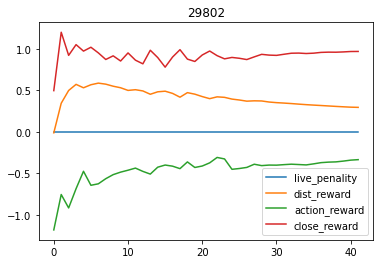

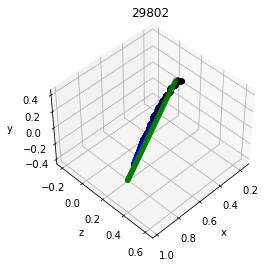

| eval  | E: 1121 | S: 29802 | R: 36.3486
| train | E: 1122 | S: 29802 | R: 18.7061 | D: 16.9 s | BR: 0.4002 | ALOSS: -9.5474 | CLOSS: 0.1286 | TLOSS: 0.0368 | TVAL: 0.0292 | AENT: -4.0000
| train | E: 1123 | S: 29831 | R: 23.2977 | D: 41.2 s | BR: 0.3640 | ALOSS: -9.7791 | CLOSS: 0.1160 | TLOSS: -0.2299 | TVAL: 0.0292 | AENT: -4.0000
| train | E: 1124 | S: 29859 | R: 24.0695 | D: 15.6 s | BR: 0.3517 | ALOSS: -9.8628 | CLOSS: 0.1274 | TLOSS: 0.2287 | TVAL: 0.0291 | AENT: -4.0000
| train | E: 1125 | S: 29884 | R: 13.4209 | D: 14.2 s | BR: 0.4124 | ALOSS: -9.7591 | CLOSS: 0.1265 | TLOSS: -0.3903 | TVAL: 0.0291 | AENT: -4.0000
| train | E: 1126 | S: 29910 | R: 24.9955 | D: 15.9 s | BR: 0.3788 | ALOSS: -9.9022 | CLOSS: 0.1229 | TLOSS: -0.1334 | TVAL: 0.0291 | AENT: -4.0000
| train | E: 1127 | S: 29948 | R: 22.4326 | D: 20.5 s | BR: 0.3687 | ALOSS: -9.7490 | CLOSS: 0.1221 | TLOSS: -0.2016 | TVAL: 0.0291 | AENT: -4.0000
| train | E: 1128 | S: 29978 | R: 16.4464 | D: 16.9 s | BR: 0.3906 | ALO

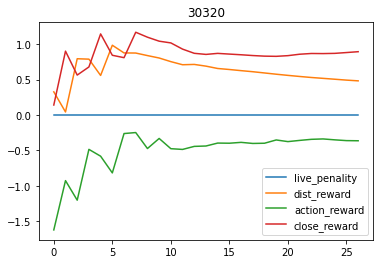

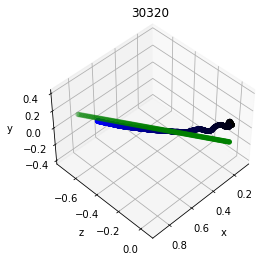

| eval  | E: 1139 | S: 30320 | R: 26.7656
| train | E: 1140 | S: 30320 | R: 24.2517 | D: 15.8 s | BR: 0.3641 | ALOSS: -9.9019 | CLOSS: 0.1419 | TLOSS: -0.4734 | TVAL: 0.0293 | AENT: -4.0000
| train | E: 1141 | S: 30349 | R: 27.0411 | D: 32.0 s | BR: 0.4106 | ALOSS: -10.0085 | CLOSS: 0.1063 | TLOSS: 0.3192 | TVAL: 0.0292 | AENT: -4.0000
| train | E: 1142 | S: 30375 | R: 22.4796 | D: 14.9 s | BR: 0.4019 | ALOSS: -9.5738 | CLOSS: 0.1203 | TLOSS: -0.0282 | TVAL: 0.0292 | AENT: -4.0000
| train | E: 1143 | S: 30404 | R: 15.2115 | D: 16.5 s | BR: 0.4059 | ALOSS: -10.0314 | CLOSS: 0.1085 | TLOSS: 0.6882 | TVAL: 0.0293 | AENT: -4.0000
| train | E: 1144 | S: 30453 | R: 14.4304 | D: 26.3 s | BR: 0.3947 | ALOSS: -9.5905 | CLOSS: 0.1072 | TLOSS: -0.1689 | TVAL: 0.0294 | AENT: -4.0000
| train | E: 1145 | S: 30476 | R: 19.0767 | D: 12.5 s | BR: 0.4226 | ALOSS: -9.7718 | CLOSS: 0.1638 | TLOSS: 0.5099 | TVAL: 0.0293 | AENT: -4.0000
| train | E: 1146 | S: 30509 | R: 23.0784 | D: 17.7 s | BR: 0.3510 | AL

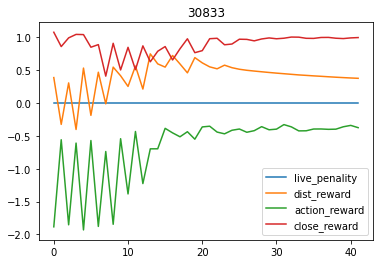

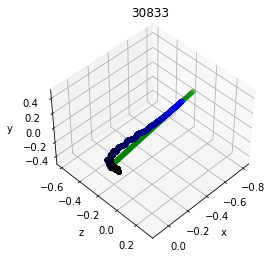

| eval  | E: 1157 | S: 30833 | R: 27.0966
| train | E: 1158 | S: 30833 | R: 23.9372 | D: 16.9 s | BR: 0.4071 | ALOSS: -9.9042 | CLOSS: 0.1319 | TLOSS: 0.1991 | TVAL: 0.0297 | AENT: -4.0000
| train | E: 1159 | S: 30872 | R: 29.4305 | D: 45.0 s | BR: 0.3873 | ALOSS: -9.8728 | CLOSS: 0.1042 | TLOSS: -0.2288 | TVAL: 0.0297 | AENT: -4.0000
| train | E: 1160 | S: 30900 | R: 10.2918 | D: 16.8 s | BR: 0.4599 | ALOSS: -9.8956 | CLOSS: 0.1003 | TLOSS: 0.0971 | TVAL: 0.0297 | AENT: -4.0000
| train | E: 1161 | S: 30929 | R: 28.0157 | D: 16.1 s | BR: 0.3888 | ALOSS: -9.6349 | CLOSS: 0.1060 | TLOSS: 0.0557 | TVAL: 0.0297 | AENT: -4.0000
| train | E: 1162 | S: 30974 | R: 14.0464 | D: 24.3 s | BR: 0.3918 | ALOSS: -9.6571 | CLOSS: 0.1020 | TLOSS: 0.0193 | TVAL: 0.0297 | AENT: -4.0000
| train | E: 1163 | S: 31002 | R: 8.5404 | D: 17.0 s | BR: 0.4142 | ALOSS: -9.9726 | CLOSS: 0.1300 | TLOSS: 0.0078 | TVAL: 0.0297 | AENT: -4.0000
| train | E: 1164 | S: 31029 | R: 29.0681 | D: 14.8 s | BR: 0.3415 | ALOSS: 

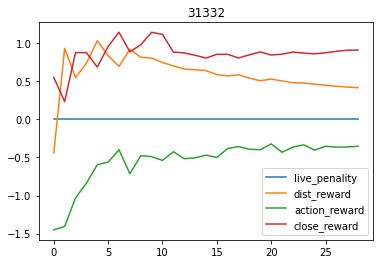

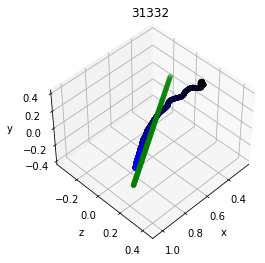

| eval  | E: 1174 | S: 31332 | R: 26.5035
| train | E: 1175 | S: 31332 | R: 16.8603 | D: 12.6 s | BR: 0.3783 | ALOSS: -9.8738 | CLOSS: 0.1290 | TLOSS: 0.6030 | TVAL: 0.0299 | AENT: -4.0000
| train | E: 1176 | S: 31361 | R: 26.0213 | D: 33.1 s | BR: 0.4236 | ALOSS: -9.8699 | CLOSS: 0.1266 | TLOSS: -0.4035 | TVAL: 0.0300 | AENT: -4.0000
| train | E: 1177 | S: 31385 | R: 20.1422 | D: 13.7 s | BR: 0.4176 | ALOSS: -9.6686 | CLOSS: 0.1146 | TLOSS: -0.0730 | TVAL: 0.0300 | AENT: -4.0000
| train | E: 1178 | S: 31413 | R: 26.3590 | D: 15.4 s | BR: 0.3863 | ALOSS: -9.6516 | CLOSS: 0.1326 | TLOSS: -0.0869 | TVAL: 0.0299 | AENT: -4.0000
| train | E: 1179 | S: 31440 | R: 20.8857 | D: 15.2 s | BR: 0.4417 | ALOSS: -9.9139 | CLOSS: 0.1203 | TLOSS: -0.1164 | TVAL: 0.0299 | AENT: -4.0000
| train | E: 1180 | S: 31470 | R: 28.3033 | D: 16.5 s | BR: 0.4172 | ALOSS: -9.8806 | CLOSS: 0.1092 | TLOSS: 0.3235 | TVAL: 0.0299 | AENT: -4.0000
| train | E: 1181 | S: 31497 | R: 24.8972 | D: 15.2 s | BR: 0.4067 | ALO

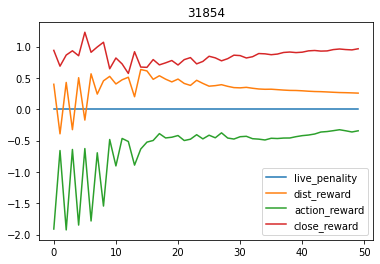

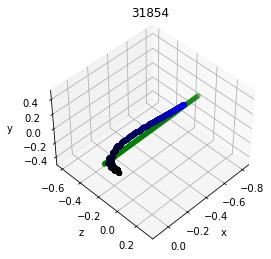

| eval  | E: 1192 | S: 31854 | R: 28.8407
| train | E: 1193 | S: 31854 | R: 25.7119 | D: 15.6 s | BR: 0.4355 | ALOSS: -10.1872 | CLOSS: 0.1094 | TLOSS: 0.4725 | TVAL: 0.0307 | AENT: -4.0000
| train | E: 1194 | S: 31877 | R: 20.2478 | D: 46.4 s | BR: 0.4055 | ALOSS: -9.6596 | CLOSS: 0.1248 | TLOSS: -0.0970 | TVAL: 0.0308 | AENT: -4.0000
| train | E: 1195 | S: 31902 | R: 22.4383 | D: 15.6 s | BR: 0.4049 | ALOSS: -9.7832 | CLOSS: 0.1424 | TLOSS: 0.4457 | TVAL: 0.0308 | AENT: -4.0000
| train | E: 1196 | S: 31927 | R: 9.3986 | D: 16.9 s | BR: 0.4062 | ALOSS: -10.0793 | CLOSS: 0.1245 | TLOSS: 0.0992 | TVAL: 0.0308 | AENT: -4.0000
| train | E: 1197 | S: 31955 | R: 22.0778 | D: 17.2 s | BR: 0.4276 | ALOSS: -9.8443 | CLOSS: 0.1257 | TLOSS: -0.0670 | TVAL: 0.0309 | AENT: -4.0000
| train | E: 1198 | S: 31979 | R: 23.9639 | D: 15.5 s | BR: 0.4166 | ALOSS: -9.7821 | CLOSS: 0.1098 | TLOSS: -0.4048 | TVAL: 0.0308 | AENT: -4.0000
| train | E: 1199 | S: 32012 | R: 25.8633 | D: 22.6 s | BR: 0.4288 | ALO

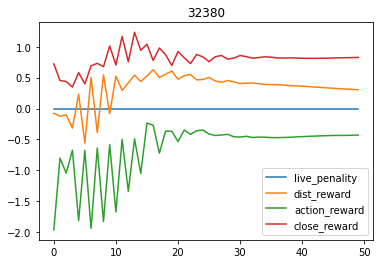

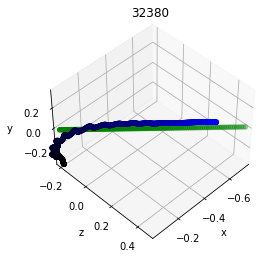

| eval  | E: 1210 | S: 32380 | R: 24.3811
| train | E: 1211 | S: 32380 | R: 25.3196 | D: 21.3 s | BR: 0.4337 | ALOSS: -9.8788 | CLOSS: 0.1063 | TLOSS: 0.1205 | TVAL: 0.0311 | AENT: -4.0000
| train | E: 1212 | S: 32409 | R: 23.2263 | D: 53.9 s | BR: 0.4116 | ALOSS: -9.6554 | CLOSS: 0.1111 | TLOSS: 0.0947 | TVAL: 0.0311 | AENT: -4.0000
| train | E: 1213 | S: 32445 | R: 20.3282 | D: 24.8 s | BR: 0.4442 | ALOSS: -9.8338 | CLOSS: 0.1197 | TLOSS: 0.2704 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 1214 | S: 32469 | R: 6.3955 | D: 16.7 s | BR: 0.4296 | ALOSS: -9.9201 | CLOSS: 0.1113 | TLOSS: 0.1783 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 1215 | S: 32497 | R: 21.4691 | D: 18.9 s | BR: 0.3823 | ALOSS: -9.9354 | CLOSS: 0.1136 | TLOSS: 0.1274 | TVAL: 0.0313 | AENT: -4.0000
| train | E: 1216 | S: 32523 | R: 23.6703 | D: 16.5 s | BR: 0.4226 | ALOSS: -9.8664 | CLOSS: 0.1743 | TLOSS: -0.1233 | TVAL: 0.0313 | AENT: -4.0000
| train | E: 1217 | S: 32545 | R: 17.9004 | D: 15.4 s | BR: 0.4473 | ALOSS: 

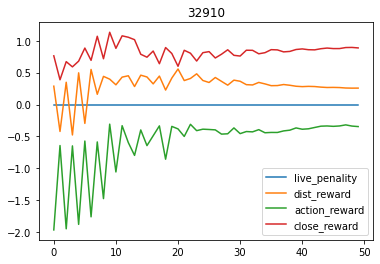

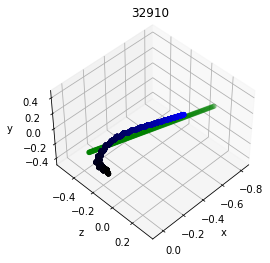

| eval  | E: 1227 | S: 32910 | R: 26.8892
| train | E: 1228 | S: 32910 | R: 22.5782 | D: 26.5 s | BR: 0.4509 | ALOSS: -9.8186 | CLOSS: 0.1170 | TLOSS: -0.3432 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 1229 | S: 32940 | R: 23.9816 | D: 55.7 s | BR: 0.4697 | ALOSS: -9.9340 | CLOSS: 0.0953 | TLOSS: -0.3035 | TVAL: 0.0311 | AENT: -4.0000
| train | E: 1230 | S: 32969 | R: 24.7065 | D: 19.7 s | BR: 0.4463 | ALOSS: -9.8681 | CLOSS: 0.1157 | TLOSS: -0.1658 | TVAL: 0.0310 | AENT: -4.0000
| train | E: 1231 | S: 32997 | R: 25.5238 | D: 17.6 s | BR: 0.4683 | ALOSS: -9.5324 | CLOSS: 0.1135 | TLOSS: -0.3265 | TVAL: 0.0310 | AENT: -4.0000
| train | E: 1232 | S: 33025 | R: 25.5997 | D: 20.4 s | BR: 0.4182 | ALOSS: -10.0487 | CLOSS: 0.1183 | TLOSS: 0.1474 | TVAL: 0.0309 | AENT: -4.0000
| train | E: 1233 | S: 33050 | R: 18.7597 | D: 16.9 s | BR: 0.4327 | ALOSS: -9.9130 | CLOSS: 0.1117 | TLOSS: -0.1005 | TVAL: 0.0309 | AENT: -4.0000
| train | E: 1234 | S: 33082 | R: 24.5778 | D: 22.6 s | BR: 0.4143 | A

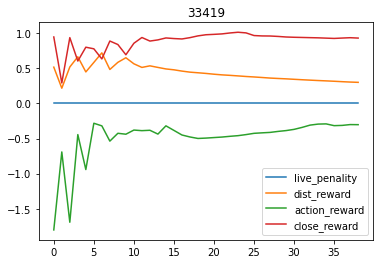

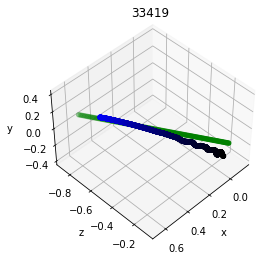

| eval  | E: 1244 | S: 33419 | R: 32.9416
| train | E: 1245 | S: 33419 | R: 20.0785 | D: 15.6 s | BR: 0.4178 | ALOSS: -10.0727 | CLOSS: 0.1070 | TLOSS: 0.4469 | TVAL: 0.0310 | AENT: -4.0000
| train | E: 1246 | S: 33442 | R: 20.9686 | D: 44.7 s | BR: 0.4366 | ALOSS: -10.0831 | CLOSS: 0.1051 | TLOSS: 0.0284 | TVAL: 0.0311 | AENT: -4.0000
| train | E: 1247 | S: 33481 | R: 20.1175 | D: 29.1 s | BR: 0.4252 | ALOSS: -9.9385 | CLOSS: 0.1212 | TLOSS: 0.0928 | TVAL: 0.0311 | AENT: -4.0000
| train | E: 1248 | S: 33502 | R: 14.8955 | D: 15.9 s | BR: 0.4215 | ALOSS: -9.8723 | CLOSS: 0.1366 | TLOSS: 0.3626 | TVAL: 0.0311 | AENT: -4.0000
| train | E: 1249 | S: 33530 | R: 24.5236 | D: 21.0 s | BR: 0.4226 | ALOSS: -9.8151 | CLOSS: 0.1303 | TLOSS: 0.4879 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 1250 | S: 33565 | R: 24.9560 | D: 24.6 s | BR: 0.4338 | ALOSS: -9.6717 | CLOSS: 0.1210 | TLOSS: 0.3134 | TVAL: 0.0313 | AENT: -4.0000
| train | E: 1251 | S: 33603 | R: 27.9063 | D: 30.5 s | BR: 0.4205 | ALOSS

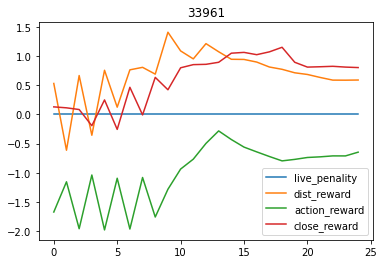

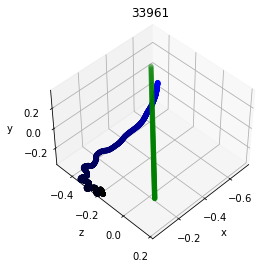

| eval  | E: 1262 | S: 33961 | R: 7.7400
| train | E: 1263 | S: 33961 | R: 25.3512 | D: 34.0 s | BR: 0.4333 | ALOSS: -10.0196 | CLOSS: 0.1115 | TLOSS: 0.1973 | TVAL: 0.0315 | AENT: -4.0000
| train | E: 1264 | S: 33987 | R: 23.8577 | D: 36.6 s | BR: 0.4369 | ALOSS: -9.9956 | CLOSS: 0.1161 | TLOSS: 0.2994 | TVAL: 0.0316 | AENT: -4.0000
| train | E: 1265 | S: 34033 | R: 23.1085 | D: 31.5 s | BR: 0.4157 | ALOSS: -9.9175 | CLOSS: 0.0978 | TLOSS: 0.1507 | TVAL: 0.0316 | AENT: -4.0000
| train | E: 1266 | S: 34068 | R: 20.2097 | D: 29.9 s | BR: 0.4507 | ALOSS: -9.7657 | CLOSS: 0.1231 | TLOSS: 0.0767 | TVAL: 0.0317 | AENT: -4.0000
| train | E: 1267 | S: 34090 | R: 18.3479 | D: 22.5 s | BR: 0.4076 | ALOSS: -9.8626 | CLOSS: 0.1409 | TLOSS: 0.5709 | TVAL: 0.0317 | AENT: -4.0000
| train | E: 1268 | S: 34115 | R: 22.1275 | D: 17.2 s | BR: 0.4270 | ALOSS: -9.9884 | CLOSS: 0.1135 | TLOSS: 0.2725 | TVAL: 0.0318 | AENT: -4.0000
| train | E: 1269 | S: 34142 | R: 24.7748 | D: 18.8 s | BR: 0.4527 | ALOSS: 

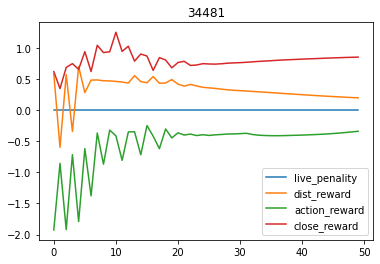

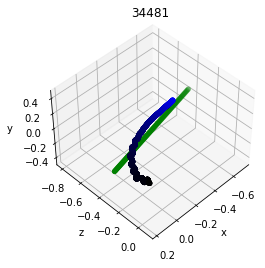

| eval  | E: 1279 | S: 34481 | R: 29.1825
| train | E: 1280 | S: 34481 | R: 24.5767 | D: 27.0 s | BR: 0.4193 | ALOSS: -9.9668 | CLOSS: 0.1100 | TLOSS: 0.5678 | TVAL: 0.0321 | AENT: -4.0000
| train | E: 1281 | S: 34507 | R: 17.5517 | D: 55.0 s | BR: 0.4516 | ALOSS: -10.0436 | CLOSS: 0.0956 | TLOSS: 0.0066 | TVAL: 0.0323 | AENT: -4.0000
| train | E: 1282 | S: 34545 | R: 22.2743 | D: 29.6 s | BR: 0.4409 | ALOSS: -9.9097 | CLOSS: 0.1059 | TLOSS: 0.0602 | TVAL: 0.0323 | AENT: -4.0000
| train | E: 1283 | S: 34573 | R: 22.9947 | D: 20.3 s | BR: 0.4180 | ALOSS: -10.0258 | CLOSS: 0.1124 | TLOSS: -0.3577 | TVAL: 0.0322 | AENT: -4.0000
| train | E: 1284 | S: 34608 | R: 21.5478 | D: 28.8 s | BR: 0.4547 | ALOSS: -9.9305 | CLOSS: 0.1137 | TLOSS: -0.1549 | TVAL: 0.0322 | AENT: -4.0000
| train | E: 1285 | S: 34633 | R: 20.5535 | D: 19.0 s | BR: 0.4186 | ALOSS: -10.0255 | CLOSS: 0.1222 | TLOSS: -0.0982 | TVAL: 0.0321 | AENT: -4.0000
| train | E: 1286 | S: 34672 | R: 18.6764 | D: 27.0 s | BR: 0.4503 | A

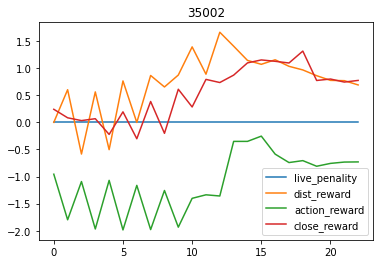

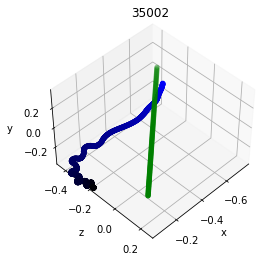

| eval  | E: 1296 | S: 35002 | R: 4.1111
| train | E: 1297 | S: 35002 | R: 21.4008 | D: 30.9 s | BR: 0.4723 | ALOSS: -10.0382 | CLOSS: 0.1166 | TLOSS: 0.1526 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 1298 | S: 35036 | R: 29.5366 | D: 42.5 s | BR: 0.4279 | ALOSS: -10.0771 | CLOSS: 0.1154 | TLOSS: -0.1426 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 1299 | S: 35073 | R: 28.2364 | D: 33.3 s | BR: 0.4325 | ALOSS: -10.0501 | CLOSS: 0.0953 | TLOSS: 0.1439 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 1300 | S: 35095 | R: 16.8827 | D: 20.6 s | BR: 0.4573 | ALOSS: -9.7389 | CLOSS: 0.1071 | TLOSS: -0.3265 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 1301 | S: 35122 | R: 14.4556 | D: 21.8 s | BR: 0.3987 | ALOSS: -10.0135 | CLOSS: 0.1297 | TLOSS: -0.1954 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 1302 | S: 35158 | R: 23.5431 | D: 31.6 s | BR: 0.4466 | ALOSS: -10.0962 | CLOSS: 0.1334 | TLOSS: 0.1231 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 1303 | S: 35195 | R: 23.1443 | D: 30.8 s | BR: 0.4491 | 

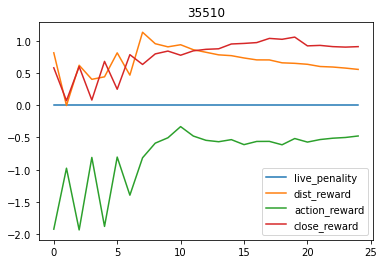

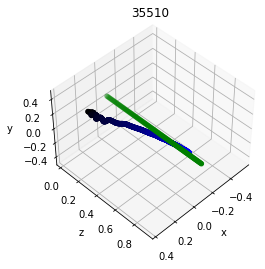

| eval  | E: 1312 | S: 35510 | R: 16.8740
| train | E: 1313 | S: 35510 | R: 20.6972 | D: 22.1 s | BR: 0.4235 | ALOSS: -10.0502 | CLOSS: 0.1452 | TLOSS: -0.0882 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1314 | S: 35533 | R: 17.0488 | D: 32.0 s | BR: 0.4295 | ALOSS: -9.8780 | CLOSS: 0.0925 | TLOSS: -0.0349 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1315 | S: 35571 | R: 22.1278 | D: 29.1 s | BR: 0.4425 | ALOSS: -10.1781 | CLOSS: 0.1080 | TLOSS: 0.0273 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1316 | S: 35610 | R: 22.5714 | D: 25.8 s | BR: 0.4685 | ALOSS: -9.9660 | CLOSS: 0.1120 | TLOSS: -0.0710 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1317 | S: 35648 | R: 26.2530 | D: 24.4 s | BR: 0.4285 | ALOSS: -10.3559 | CLOSS: 0.1194 | TLOSS: 0.1825 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1318 | S: 35685 | R: 29.9313 | D: 24.0 s | BR: 0.4414 | ALOSS: -10.0950 | CLOSS: 0.1165 | TLOSS: 0.2318 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1319 | S: 35717 | R: 24.2281 | D: 22.5 s | BR: 0.4450 | 

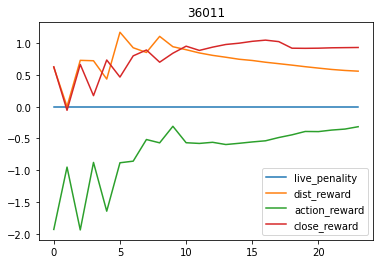

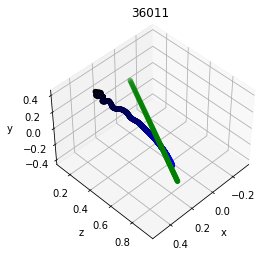

| eval  | E: 1327 | S: 36011 | R: 19.3700
| train | E: 1328 | S: 36011 | R: 23.5152 | D: 20.6 s | BR: 0.4575 | ALOSS: -10.3486 | CLOSS: 0.0939 | TLOSS: 0.0124 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 1329 | S: 36039 | R: 24.1092 | D: 33.8 s | BR: 0.4688 | ALOSS: -10.0133 | CLOSS: 0.1145 | TLOSS: 0.1260 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 1330 | S: 36060 | R: 20.3718 | D: 14.2 s | BR: 0.4219 | ALOSS: -10.1954 | CLOSS: 0.1045 | TLOSS: 0.2926 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 1331 | S: 36083 | R: 13.2854 | D: 16.9 s | BR: 0.4147 | ALOSS: -10.2768 | CLOSS: 0.1121 | TLOSS: -0.4536 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 1332 | S: 36120 | R: 28.4280 | D: 26.5 s | BR: 0.4466 | ALOSS: -9.9031 | CLOSS: 0.1048 | TLOSS: -0.1411 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 1333 | S: 36161 | R: 24.4040 | D: 35.5 s | BR: 0.4548 | ALOSS: -10.0500 | CLOSS: 0.1008 | TLOSS: 0.0793 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 1334 | S: 36192 | R: 25.0598 | D: 21.1 s | BR: 0.4646 | 

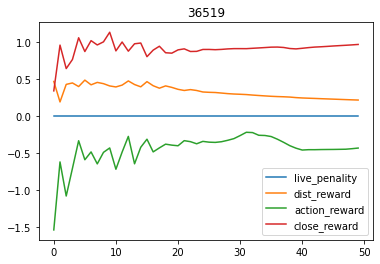

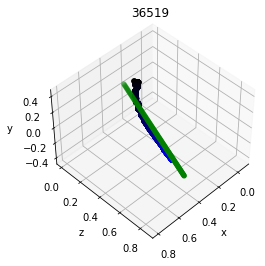

| eval  | E: 1343 | S: 36519 | R: 39.4284
| train | E: 1344 | S: 36519 | R: 28.9866 | D: 27.4 s | BR: 0.4349 | ALOSS: -9.9565 | CLOSS: 0.1232 | TLOSS: 0.0385 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 1345 | S: 36549 | R: 27.0957 | D: 54.6 s | BR: 0.4264 | ALOSS: -10.1713 | CLOSS: 0.1133 | TLOSS: 0.2715 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1346 | S: 36575 | R: 24.6674 | D: 21.7 s | BR: 0.4813 | ALOSS: -10.0184 | CLOSS: 0.0998 | TLOSS: -0.3485 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 1347 | S: 36613 | R: 23.3025 | D: 26.7 s | BR: 0.4499 | ALOSS: -10.0385 | CLOSS: 0.0994 | TLOSS: 0.0013 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1348 | S: 36648 | R: 25.2933 | D: 24.3 s | BR: 0.4564 | ALOSS: -10.1820 | CLOSS: 0.1005 | TLOSS: 0.3362 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 1349 | S: 36684 | R: 27.2546 | D: 26.3 s | BR: 0.4856 | ALOSS: -10.1367 | CLOSS: 0.0986 | TLOSS: 0.3968 | TVAL: 0.0332 | AENT: -4.0000
| train | E: 1350 | S: 36708 | R: 19.0826 | D: 17.0 s | BR: 0.4261 | A

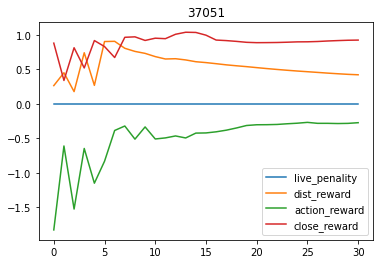

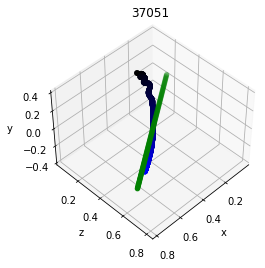

| eval  | E: 1359 | S: 37051 | R: 28.9355
| train | E: 1360 | S: 37051 | R: 13.6247 | D: 36.5 s | BR: 0.4579 | ALOSS: -9.8395 | CLOSS: 0.0991 | TLOSS: 0.2095 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 1361 | S: 37089 | R: 29.9463 | D: 52.1 s | BR: 0.4631 | ALOSS: -10.1863 | CLOSS: 0.0990 | TLOSS: -0.0943 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 1362 | S: 37130 | R: 22.3367 | D: 29.9 s | BR: 0.4597 | ALOSS: -9.9388 | CLOSS: 0.1370 | TLOSS: -0.2749 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 1363 | S: 37169 | R: 28.3890 | D: 26.0 s | BR: 0.4580 | ALOSS: -10.0784 | CLOSS: 0.1079 | TLOSS: 0.1671 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1364 | S: 37200 | R: 24.6544 | D: 21.0 s | BR: 0.4584 | ALOSS: -10.1729 | CLOSS: 0.1302 | TLOSS: -0.1676 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1365 | S: 37229 | R: 28.1584 | D: 20.7 s | BR: 0.4539 | ALOSS: -10.0669 | CLOSS: 0.1110 | TLOSS: 0.0584 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1366 | S: 37270 | R: 20.4130 | D: 32.9 s | BR: 0.4335 | 

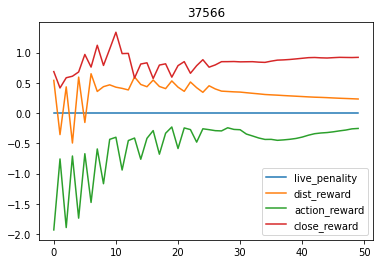

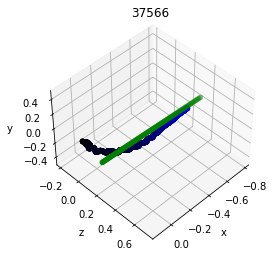

| eval  | E: 1374 | S: 37566 | R: 31.7910
| train | E: 1375 | S: 37566 | R: 20.9211 | D: 33.3 s | BR: 0.4305 | ALOSS: -9.9541 | CLOSS: 0.1262 | TLOSS: 0.0477 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1376 | S: 37596 | R: 23.4478 | D: 54.7 s | BR: 0.4170 | ALOSS: -9.9997 | CLOSS: 0.1037 | TLOSS: -0.2257 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1377 | S: 37618 | R: 14.6008 | D: 15.2 s | BR: 0.4193 | ALOSS: -10.3574 | CLOSS: 0.1173 | TLOSS: 0.1196 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1378 | S: 37655 | R: 26.4851 | D: 24.5 s | BR: 0.4849 | ALOSS: -10.1398 | CLOSS: 0.0986 | TLOSS: -0.0739 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1379 | S: 37683 | R: 21.8533 | D: 21.4 s | BR: 0.4940 | ALOSS: -10.0062 | CLOSS: 0.0846 | TLOSS: 0.2920 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1380 | S: 37714 | R: 23.8833 | D: 22.5 s | BR: 0.4601 | ALOSS: -10.1415 | CLOSS: 0.1149 | TLOSS: 0.0751 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1381 | S: 37739 | R: 17.7305 | D: 19.1 s | BR: 0.4104 | A

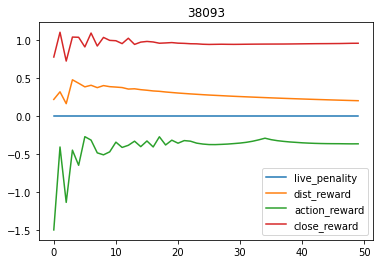

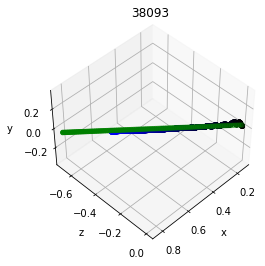

| eval  | E: 1391 | S: 38093 | R: 42.3579
| train | E: 1392 | S: 38093 | R: 12.0099 | D: 21.5 s | BR: 0.4717 | ALOSS: -10.1928 | CLOSS: 0.0928 | TLOSS: -0.0823 | TVAL: 0.0332 | AENT: -4.0000
| train | E: 1393 | S: 38123 | R: 10.1111 | D: 56.7 s | BR: 0.4583 | ALOSS: -10.0473 | CLOSS: 0.1085 | TLOSS: 0.5986 | TVAL: 0.0333 | AENT: -4.0000
| train | E: 1394 | S: 38146 | R: 20.9628 | D: 16.3 s | BR: 0.4589 | ALOSS: -10.1224 | CLOSS: 0.1279 | TLOSS: -0.0812 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1395 | S: 38185 | R: 28.2360 | D: 23.9 s | BR: 0.4826 | ALOSS: -10.0026 | CLOSS: 0.1359 | TLOSS: 0.2537 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1396 | S: 38224 | R: 24.6141 | D: 26.5 s | BR: 0.4141 | ALOSS: -10.1446 | CLOSS: 0.1038 | TLOSS: -0.1887 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1397 | S: 38257 | R: 27.2116 | D: 20.9 s | BR: 0.4822 | ALOSS: -10.1571 | CLOSS: 0.0943 | TLOSS: -0.1752 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1398 | S: 38289 | R: 28.3704 | D: 22.8 s | BR: 0.3925

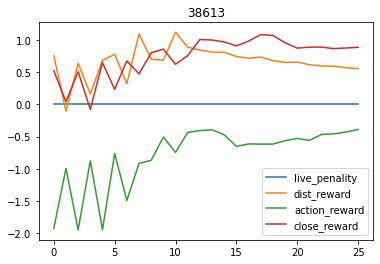

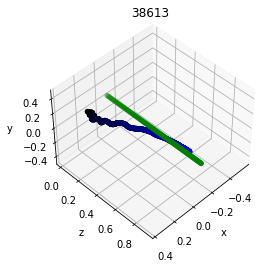

| eval  | E: 1407 | S: 38613 | R: 16.0478
| train | E: 1408 | S: 38613 | R: 22.2147 | D: 29.6 s | BR: 0.4702 | ALOSS: -10.0369 | CLOSS: 0.1007 | TLOSS: 0.1853 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 1409 | S: 38637 | R: 20.2807 | D: 33.6 s | BR: 0.4833 | ALOSS: -10.0675 | CLOSS: 0.1021 | TLOSS: -0.1946 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 1410 | S: 38677 | R: 23.2615 | D: 25.9 s | BR: 0.4734 | ALOSS: -10.0380 | CLOSS: 0.0996 | TLOSS: 0.2015 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 1411 | S: 38714 | R: 25.3464 | D: 26.5 s | BR: 0.4816 | ALOSS: -10.2272 | CLOSS: 0.1027 | TLOSS: 0.1140 | TVAL: 0.0337 | AENT: -4.0000
| train | E: 1412 | S: 38745 | R: 23.4174 | D: 20.9 s | BR: 0.5005 | ALOSS: -10.0087 | CLOSS: 0.1043 | TLOSS: 0.2193 | TVAL: 0.0337 | AENT: -4.0000
| train | E: 1413 | S: 38780 | R: 29.8190 | D: 25.5 s | BR: 0.4565 | ALOSS: -10.0279 | CLOSS: 0.1256 | TLOSS: 0.1351 | TVAL: 0.0338 | AENT: -4.0000
| train | E: 1414 | S: 38812 | R: 27.6419 | D: 25.0 s | BR: 0.4487 | 

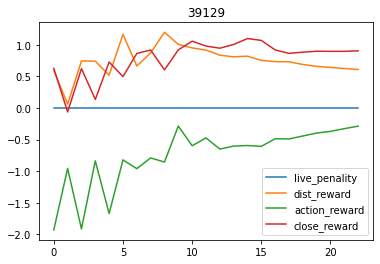

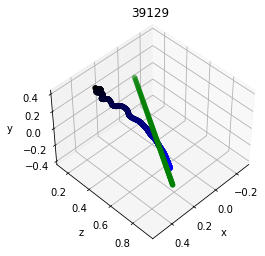

| eval  | E: 1423 | S: 39129 | R: 18.2867
| train | E: 1424 | S: 39129 | R: 22.4091 | D: 18.0 s | BR: 0.4472 | ALOSS: -10.2908 | CLOSS: 0.0952 | TLOSS: 0.3603 | TVAL: 0.0338 | AENT: -4.0000
| train | E: 1425 | S: 39165 | R: 20.2868 | D: 43.2 s | BR: 0.4291 | ALOSS: -10.3860 | CLOSS: 0.0957 | TLOSS: 0.1861 | TVAL: 0.0338 | AENT: -4.0000
| train | E: 1426 | S: 39196 | R: 27.1045 | D: 23.6 s | BR: 0.4726 | ALOSS: -10.1577 | CLOSS: 0.0939 | TLOSS: -0.3533 | TVAL: 0.0339 | AENT: -4.0000
| train | E: 1427 | S: 39219 | R: 12.0984 | D: 15.6 s | BR: 0.4809 | ALOSS: -10.1637 | CLOSS: 0.1194 | TLOSS: 0.0242 | TVAL: 0.0338 | AENT: -4.0000
| train | E: 1428 | S: 39256 | R: 21.8559 | D: 24.7 s | BR: 0.4800 | ALOSS: -9.8072 | CLOSS: 0.0982 | TLOSS: 0.1323 | TVAL: 0.0338 | AENT: -4.0000
| train | E: 1429 | S: 39281 | R: 21.9676 | D: 15.8 s | BR: 0.4869 | ALOSS: -10.1470 | CLOSS: 0.1145 | TLOSS: -0.0740 | TVAL: 0.0339 | AENT: -4.0000
| train | E: 1430 | S: 39324 | R: 20.3837 | D: 30.0 s | BR: 0.4927 | 

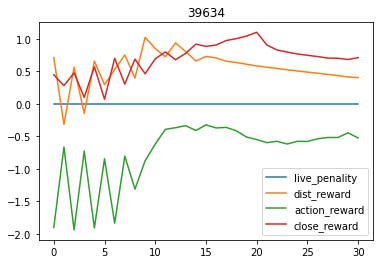

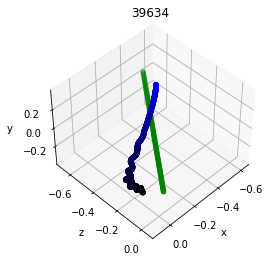

| eval  | E: 1438 | S: 39634 | R: 15.6593
| train | E: 1439 | S: 39634 | R: 24.0376 | D: 22.4 s | BR: 0.4454 | ALOSS: -9.9992 | CLOSS: 0.1071 | TLOSS: -0.0016 | TVAL: 0.0339 | AENT: -4.0000
| train | E: 1440 | S: 39658 | R: 20.7915 | D: 37.3 s | BR: 0.4457 | ALOSS: -10.2880 | CLOSS: 0.0961 | TLOSS: -0.0280 | TVAL: 0.0339 | AENT: -4.0000
| train | E: 1441 | S: 39680 | R: 13.8565 | D: 14.6 s | BR: 0.5036 | ALOSS: -10.0235 | CLOSS: 0.1113 | TLOSS: 0.7695 | TVAL: 0.0340 | AENT: -4.0000
| train | E: 1442 | S: 39719 | R: 24.5686 | D: 25.3 s | BR: 0.4781 | ALOSS: -10.1274 | CLOSS: 0.1017 | TLOSS: -0.1259 | TVAL: 0.0341 | AENT: -4.0000
| train | E: 1443 | S: 39755 | R: 29.4125 | D: 24.5 s | BR: 0.4840 | ALOSS: -10.2832 | CLOSS: 0.1018 | TLOSS: -0.1365 | TVAL: 0.0340 | AENT: -4.0000
| train | E: 1444 | S: 39785 | R: 17.9726 | D: 19.5 s | BR: 0.4599 | ALOSS: -10.1048 | CLOSS: 0.1036 | TLOSS: 0.0486 | TVAL: 0.0340 | AENT: -4.0000
| train | E: 1445 | S: 39829 | R: 24.0055 | D: 29.1 s | BR: 0.4679 

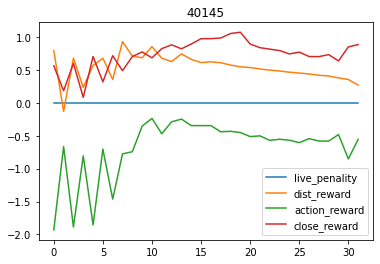

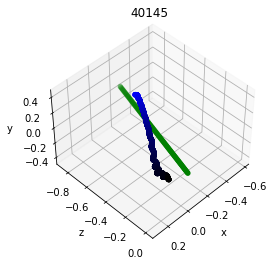

| eval  | E: 1454 | S: 40145 | R: 19.1200
| train | E: 1455 | S: 40145 | R: 22.4926 | D: 15.6 s | BR: 0.4723 | ALOSS: -9.9940 | CLOSS: 0.1031 | TLOSS: 0.1589 | TVAL: 0.0342 | AENT: -4.0000
| train | E: 1456 | S: 40169 | R: 18.4687 | D: 39.4 s | BR: 0.4737 | ALOSS: -10.1499 | CLOSS: 0.1027 | TLOSS: -0.1974 | TVAL: 0.0342 | AENT: -4.0000
| train | E: 1457 | S: 40206 | R: 27.0596 | D: 25.1 s | BR: 0.4608 | ALOSS: -10.3815 | CLOSS: 0.0958 | TLOSS: 0.0838 | TVAL: 0.0342 | AENT: -4.0000
| train | E: 1458 | S: 40243 | R: 28.2374 | D: 24.2 s | BR: 0.4715 | ALOSS: -10.0484 | CLOSS: 0.0980 | TLOSS: -0.2143 | TVAL: 0.0342 | AENT: -4.0000
| train | E: 1459 | S: 40270 | R: 21.5723 | D: 19.8 s | BR: 0.4593 | ALOSS: -10.3816 | CLOSS: 0.0875 | TLOSS: 0.4916 | TVAL: 0.0342 | AENT: -4.0000
| train | E: 1460 | S: 40301 | R: 26.8063 | D: 20.7 s | BR: 0.4618 | ALOSS: -10.1374 | CLOSS: 0.0969 | TLOSS: 0.5600 | TVAL: 0.0343 | AENT: -4.0000
| train | E: 1461 | S: 40322 | R: 13.4525 | D: 15.2 s | BR: 0.4455 | 

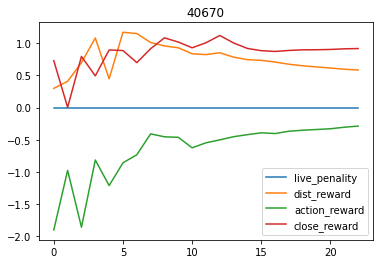

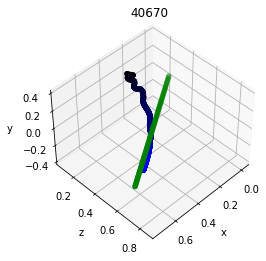

| eval  | E: 1471 | S: 40670 | R: 22.0111
| train | E: 1472 | S: 40670 | R: 27.2855 | D: 26.7 s | BR: 0.4650 | ALOSS: -10.2072 | CLOSS: 0.0901 | TLOSS: 0.1814 | TVAL: 0.0345 | AENT: -4.0000
| train | E: 1473 | S: 40693 | R: 19.1397 | D: 34.6 s | BR: 0.4853 | ALOSS: -10.1192 | CLOSS: 0.0969 | TLOSS: 0.5200 | TVAL: 0.0346 | AENT: -4.0000
| train | E: 1474 | S: 40723 | R: 18.6557 | D: 22.8 s | BR: 0.4545 | ALOSS: -10.2197 | CLOSS: 0.0989 | TLOSS: 0.0486 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1475 | S: 40761 | R: 24.5121 | D: 27.1 s | BR: 0.4808 | ALOSS: -10.1087 | CLOSS: 0.0985 | TLOSS: -0.1616 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1476 | S: 40805 | R: 24.7372 | D: 33.6 s | BR: 0.4948 | ALOSS: -10.0849 | CLOSS: 0.0823 | TLOSS: 0.3859 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1477 | S: 40836 | R: 26.8314 | D: 21.7 s | BR: 0.4916 | ALOSS: -9.9444 | CLOSS: 0.0964 | TLOSS: 0.3580 | TVAL: 0.0348 | AENT: -4.0000
| train | E: 1478 | S: 40861 | R: 21.5963 | D: 18.7 s | BR: 0.4791 | A

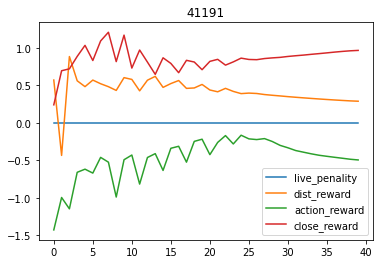

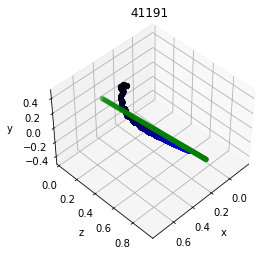

| eval  | E: 1487 | S: 41191 | R: 32.2652
| train | E: 1488 | S: 41191 | R: 17.4318 | D: 21.4 s | BR: 0.4480 | ALOSS: -10.2798 | CLOSS: 0.0998 | TLOSS: 0.5188 | TVAL: 0.0352 | AENT: -4.0000
| train | E: 1489 | S: 41220 | R: 26.4763 | D: 43.6 s | BR: 0.4446 | ALOSS: -10.3811 | CLOSS: 0.1037 | TLOSS: 0.0083 | TVAL: 0.0353 | AENT: -4.0000
| train | E: 1490 | S: 41243 | R: 17.8131 | D: 14.8 s | BR: 0.4451 | ALOSS: -10.4344 | CLOSS: 0.0914 | TLOSS: 0.0866 | TVAL: 0.0353 | AENT: -4.0000
| train | E: 1491 | S: 41283 | R: 21.1398 | D: 26.5 s | BR: 0.4719 | ALOSS: -10.2545 | CLOSS: 0.0912 | TLOSS: 0.2968 | TVAL: 0.0354 | AENT: -4.0000
| train | E: 1492 | S: 41309 | R: 23.3239 | D: 15.9 s | BR: 0.4664 | ALOSS: -10.1544 | CLOSS: 0.0921 | TLOSS: 0.1324 | TVAL: 0.0354 | AENT: -4.0000
| train | E: 1493 | S: 41336 | R: 22.2498 | D: 19.4 s | BR: 0.4985 | ALOSS: -10.0434 | CLOSS: 0.0851 | TLOSS: 0.2503 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 1494 | S: 41370 | R: 28.6934 | D: 20.5 s | BR: 0.4724 | A

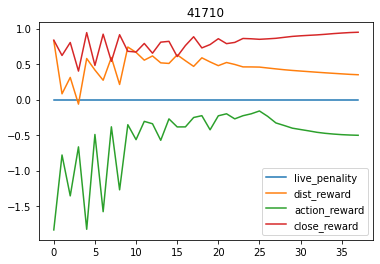

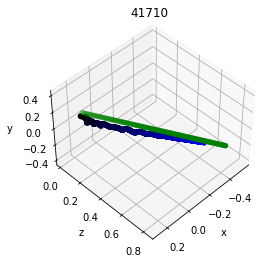

| eval  | E: 1503 | S: 41710 | R: 26.9512
| train | E: 1504 | S: 41710 | R: 19.2181 | D: 24.3 s | BR: 0.4956 | ALOSS: -10.2352 | CLOSS: 0.0984 | TLOSS: -0.2836 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 1505 | S: 41739 | R: 16.3816 | D: 46.2 s | BR: 0.5064 | ALOSS: -10.3417 | CLOSS: 0.0941 | TLOSS: 0.0602 | TVAL: 0.0354 | AENT: -4.0000
| train | E: 1506 | S: 41779 | R: 24.3209 | D: 31.4 s | BR: 0.5075 | ALOSS: -9.8681 | CLOSS: 0.1048 | TLOSS: 0.3584 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 1507 | S: 41816 | R: 30.7548 | D: 27.2 s | BR: 0.4930 | ALOSS: -10.0967 | CLOSS: 0.0945 | TLOSS: -0.1761 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1508 | S: 41851 | R: 21.3945 | D: 25.9 s | BR: 0.4719 | ALOSS: -10.0437 | CLOSS: 0.0986 | TLOSS: -0.0988 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1509 | S: 41886 | R: 27.0545 | D: 23.7 s | BR: 0.4668 | ALOSS: -10.0483 | CLOSS: 0.0889 | TLOSS: -0.1046 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 1510 | S: 41923 | R: 21.7779 | D: 26.7 s | BR: 0.4889 

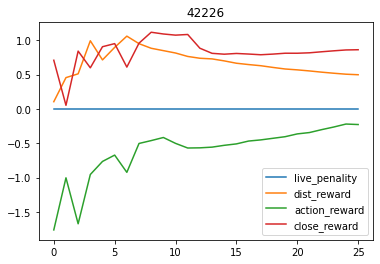

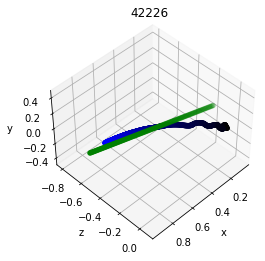

| eval  | E: 1519 | S: 42226 | R: 23.1598
| train | E: 1520 | S: 42226 | R: 31.1660 | D: 27.1 s | BR: 0.4960 | ALOSS: -10.2736 | CLOSS: 0.0952 | TLOSS: 0.1181 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1521 | S: 42255 | R: 19.3917 | D: 38.9 s | BR: 0.4856 | ALOSS: -10.2649 | CLOSS: 0.1138 | TLOSS: -0.1212 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1522 | S: 42299 | R: 19.3573 | D: 30.4 s | BR: 0.4997 | ALOSS: -10.1187 | CLOSS: 0.0876 | TLOSS: 0.0543 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1523 | S: 42323 | R: 11.8418 | D: 17.3 s | BR: 0.4823 | ALOSS: -10.1853 | CLOSS: 0.0829 | TLOSS: 0.2369 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1524 | S: 42368 | R: 24.6740 | D: 29.9 s | BR: 0.4649 | ALOSS: -10.1445 | CLOSS: 0.0902 | TLOSS: 0.1117 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1525 | S: 42412 | R: 27.8349 | D: 30.7 s | BR: 0.4683 | ALOSS: -10.2682 | CLOSS: 0.0908 | TLOSS: 0.1350 | TVAL: 0.0358 | AENT: -4.0000
| train | E: 1526 | S: 42451 | R: 22.0078 | D: 32.6 s | BR: 0.4858 | 

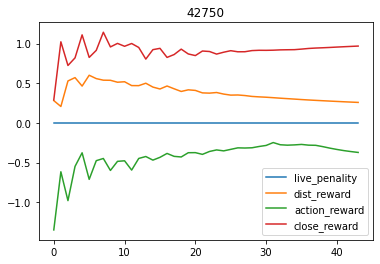

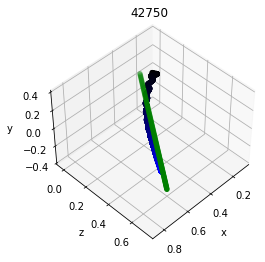

| eval  | E: 1534 | S: 42750 | R: 38.3132
| train | E: 1535 | S: 42750 | R: 25.0350 | D: 19.9 s | BR: 0.5105 | ALOSS: -10.0785 | CLOSS: 0.0916 | TLOSS: -0.2891 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 1536 | S: 42778 | R: 20.1989 | D: 50.2 s | BR: 0.5085 | ALOSS: -10.2000 | CLOSS: 0.0842 | TLOSS: 0.0441 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 1537 | S: 42812 | R: 27.4575 | D: 26.1 s | BR: 0.4613 | ALOSS: -10.1411 | CLOSS: 0.1129 | TLOSS: -0.0314 | TVAL: 0.0354 | AENT: -4.0000
| train | E: 1538 | S: 42844 | R: 14.0775 | D: 23.8 s | BR: 0.4865 | ALOSS: -10.2522 | CLOSS: 0.0802 | TLOSS: 0.2415 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 1539 | S: 42867 | R: 14.1484 | D: 17.1 s | BR: 0.4392 | ALOSS: -10.3703 | CLOSS: 0.1344 | TLOSS: 0.1074 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 1540 | S: 42897 | R: 23.4657 | D: 23.1 s | BR: 0.4928 | ALOSS: -10.1935 | CLOSS: 0.1013 | TLOSS: 0.2422 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1541 | S: 42930 | R: 26.7697 | D: 25.0 s | BR: 0.5052 |

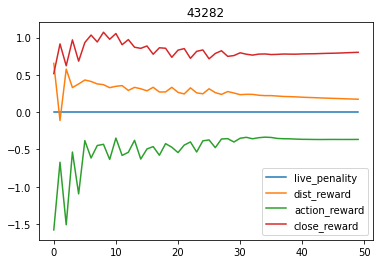

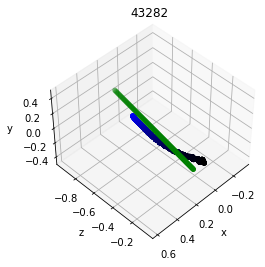

| eval  | E: 1550 | S: 43282 | R: 30.3545
| train | E: 1551 | S: 43282 | R: 18.8073 | D: 34.5 s | BR: 0.4880 | ALOSS: -10.3193 | CLOSS: 0.0894 | TLOSS: -0.0241 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1552 | S: 43324 | R: 24.6132 | D: 71.1 s | BR: 0.4819 | ALOSS: -10.1799 | CLOSS: 0.1220 | TLOSS: 0.0024 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1553 | S: 43345 | R: 12.6931 | D: 16.5 s | BR: 0.4757 | ALOSS: -10.1373 | CLOSS: 0.0863 | TLOSS: 0.0336 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1554 | S: 43370 | R: 22.7590 | D: 19.7 s | BR: 0.4788 | ALOSS: -10.0897 | CLOSS: 0.1191 | TLOSS: 0.0191 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1555 | S: 43409 | R: 34.2448 | D: 29.4 s | BR: 0.5144 | ALOSS: -10.0690 | CLOSS: 0.0923 | TLOSS: -0.1948 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 1556 | S: 43441 | R: 26.7301 | D: 23.4 s | BR: 0.4824 | ALOSS: -10.0138 | CLOSS: 0.0922 | TLOSS: -0.0371 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 1557 | S: 43491 | R: 25.0631 | D: 37.6 s | BR: 0.4748 

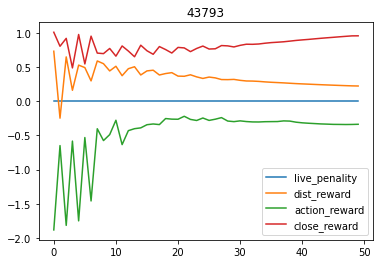

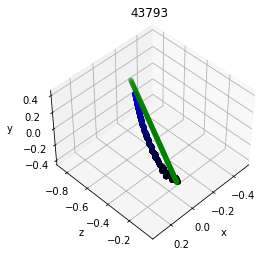

| eval  | E: 1565 | S: 43793 | R: 35.3172
| train | E: 1566 | S: 43793 | R: 23.4248 | D: 19.5 s | BR: 0.4931 | ALOSS: -10.3164 | CLOSS: 0.0857 | TLOSS: -0.1069 | TVAL: 0.0358 | AENT: -4.0000
| train | E: 1567 | S: 43825 | R: 15.4136 | D: 68.7 s | BR: 0.4739 | ALOSS: -10.2642 | CLOSS: 0.0814 | TLOSS: -0.3087 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 1568 | S: 43860 | R: 29.3051 | D: 25.7 s | BR: 0.4771 | ALOSS: -10.0032 | CLOSS: 0.0873 | TLOSS: 0.0913 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 1569 | S: 43901 | R: 35.8660 | D: 24.3 s | BR: 0.4934 | ALOSS: -10.1147 | CLOSS: 0.0854 | TLOSS: 0.1286 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 1570 | S: 43932 | R: 25.6966 | D: 23.6 s | BR: 0.4749 | ALOSS: -10.1557 | CLOSS: 0.1018 | TLOSS: 0.3988 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 1571 | S: 43968 | R: 19.6493 | D: 24.5 s | BR: 0.4924 | ALOSS: -10.1212 | CLOSS: 0.0960 | TLOSS: -0.1217 | TVAL: 0.0359 | AENT: -4.0000
| train | E: 1572 | S: 43994 | R: 11.0118 | D: 18.1 s | BR: 0.4632 

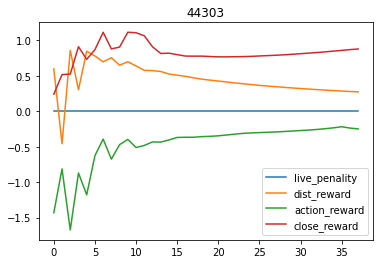

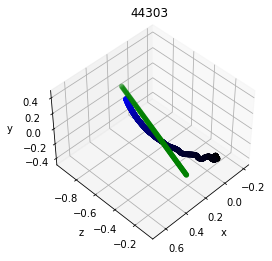

| eval  | E: 1580 | S: 44303 | R: 30.3391
| train | E: 1581 | S: 44303 | R: 16.1997 | D: 15.3 s | BR: 0.4865 | ALOSS: -10.2103 | CLOSS: 0.0771 | TLOSS: 0.4727 | TVAL: 0.0359 | AENT: -4.0000
| train | E: 1582 | S: 44336 | R: 21.7792 | D: 48.6 s | BR: 0.5104 | ALOSS: -10.4323 | CLOSS: 0.0849 | TLOSS: 0.1894 | TVAL: 0.0360 | AENT: -4.0000
| train | E: 1583 | S: 44372 | R: 16.9796 | D: 24.7 s | BR: 0.4765 | ALOSS: -10.2583 | CLOSS: 0.0974 | TLOSS: 0.1666 | TVAL: 0.0360 | AENT: -4.0000
| train | E: 1584 | S: 44399 | R: 26.4213 | D: 18.7 s | BR: 0.5012 | ALOSS: -9.9661 | CLOSS: 0.1054 | TLOSS: 0.4410 | TVAL: 0.0361 | AENT: -4.0000
| train | E: 1585 | S: 44430 | R: 27.9097 | D: 21.9 s | BR: 0.5308 | ALOSS: -10.2774 | CLOSS: 0.1171 | TLOSS: -0.4841 | TVAL: 0.0362 | AENT: -4.0000
| train | E: 1586 | S: 44460 | R: 25.2018 | D: 19.6 s | BR: 0.4890 | ALOSS: -10.0370 | CLOSS: 0.0932 | TLOSS: 0.2241 | TVAL: 0.0361 | AENT: -4.0000
| train | E: 1587 | S: 44482 | R: 19.0026 | D: 16.2 s | BR: 0.4594 | A

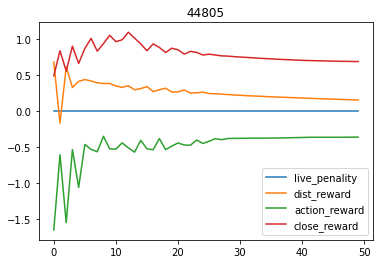

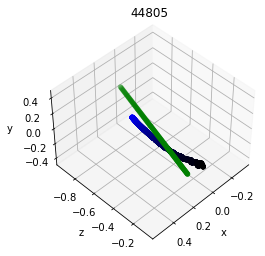

| eval  | E: 1596 | S: 44805 | R: 28.5163
| train | E: 1597 | S: 44805 | R: 27.8029 | D: 24.0 s | BR: 0.5097 | ALOSS: -10.4603 | CLOSS: 0.0997 | TLOSS: 0.0154 | TVAL: 0.0363 | AENT: -4.0000
| train | E: 1598 | S: 44845 | R: 15.6272 | D: 63.7 s | BR: 0.4813 | ALOSS: -10.2136 | CLOSS: 0.1024 | TLOSS: -0.3367 | TVAL: 0.0362 | AENT: -4.0000
| train | E: 1599 | S: 44877 | R: 12.1891 | D: 21.5 s | BR: 0.4928 | ALOSS: -10.2179 | CLOSS: 0.0850 | TLOSS: 0.1473 | TVAL: 0.0362 | AENT: -4.0000
| train | E: 1600 | S: 44903 | R: 16.7444 | D: 17.3 s | BR: 0.4551 | ALOSS: -10.3046 | CLOSS: 0.1018 | TLOSS: 0.3888 | TVAL: 0.0362 | AENT: -4.0000
| train | E: 1601 | S: 44944 | R: 28.0691 | D: 28.7 s | BR: 0.4909 | ALOSS: -10.1709 | CLOSS: 0.0856 | TLOSS: 0.0071 | TVAL: 0.0363 | AENT: -4.0000
| train | E: 1602 | S: 44969 | R: 12.9600 | D: 17.1 s | BR: 0.4778 | ALOSS: -10.4115 | CLOSS: 0.1098 | TLOSS: 0.3036 | TVAL: 0.0363 | AENT: -4.0000
| train | E: 1603 | S: 44999 | R: 26.5328 | D: 19.7 s | BR: 0.5142 | 

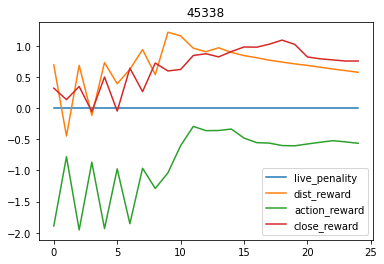

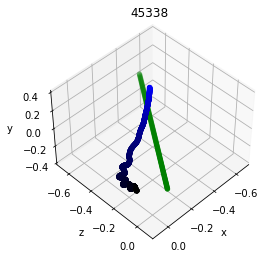

| eval  | E: 1613 | S: 45338 | R: 12.5990
| train | E: 1614 | S: 45338 | R: 31.4156 | D: 28.8 s | BR: 0.5123 | ALOSS: -10.1478 | CLOSS: 0.0842 | TLOSS: -0.0672 | TVAL: 0.0363 | AENT: -4.0000
| train | E: 1615 | S: 45368 | R: 26.7330 | D: 38.4 s | BR: 0.4782 | ALOSS: -10.3108 | CLOSS: 0.0843 | TLOSS: 0.2150 | TVAL: 0.0363 | AENT: -4.0000
| train | E: 1616 | S: 45403 | R: 27.8450 | D: 23.5 s | BR: 0.4705 | ALOSS: -10.1767 | CLOSS: 0.0827 | TLOSS: 0.0175 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 1617 | S: 45432 | R: 26.3370 | D: 26.0 s | BR: 0.4750 | ALOSS: -10.3922 | CLOSS: 0.0752 | TLOSS: 0.2003 | TVAL: 0.0363 | AENT: -4.0000
| train | E: 1618 | S: 45476 | R: 36.6408 | D: 34.0 s | BR: 0.4992 | ALOSS: -9.9850 | CLOSS: 0.0976 | TLOSS: 0.1019 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 1619 | S: 45514 | R: 18.6175 | D: 33.5 s | BR: 0.4779 | ALOSS: -10.2899 | CLOSS: 0.0865 | TLOSS: 0.3995 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 1620 | S: 45542 | R: 26.0465 | D: 22.3 s | BR: 0.5291 | A

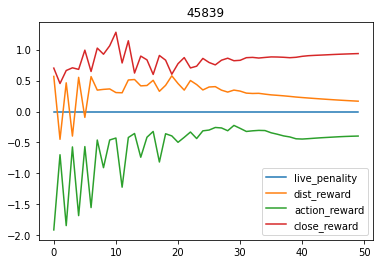

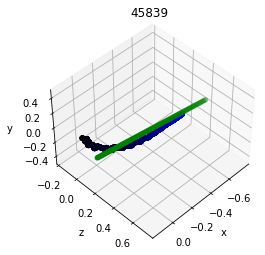

| eval  | E: 1627 | S: 45839 | R: 30.2088
| train | E: 1628 | S: 45839 | R: 25.5952 | D: 23.3 s | BR: 0.5249 | ALOSS: -10.1584 | CLOSS: 0.0817 | TLOSS: 0.0252 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 1629 | S: 45878 | R: 25.7942 | D: 63.1 s | BR: 0.5032 | ALOSS: -10.2473 | CLOSS: 0.0956 | TLOSS: 0.0878 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 1630 | S: 45898 | R: 8.3144 | D: 15.2 s | BR: 0.5151 | ALOSS: -10.2580 | CLOSS: 0.1050 | TLOSS: -0.3460 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 1631 | S: 45936 | R: 29.8379 | D: 27.8 s | BR: 0.4858 | ALOSS: -10.4729 | CLOSS: 0.0941 | TLOSS: -0.2354 | TVAL: 0.0366 | AENT: -4.0000
| train | E: 1632 | S: 45963 | R: 11.5454 | D: 19.5 s | BR: 0.4936 | ALOSS: -10.2212 | CLOSS: 0.0977 | TLOSS: -0.0180 | TVAL: 0.0366 | AENT: -4.0000
| train | E: 1633 | S: 45986 | R: 3.6574 | D: 16.1 s | BR: 0.4871 | ALOSS: -10.0680 | CLOSS: 0.1039 | TLOSS: 0.2106 | TVAL: 0.0366 | AENT: -4.0000
| train | E: 1634 | S: 46026 | R: 23.0818 | D: 27.8 s | BR: 0.4750 | 

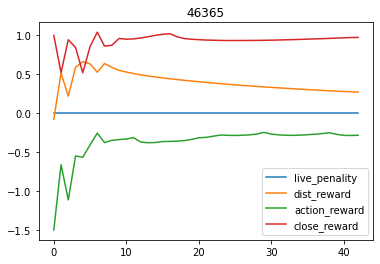

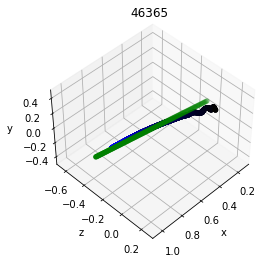

| eval  | E: 1644 | S: 46365 | R: 41.3058
| train | E: 1645 | S: 46365 | R: 11.6200 | D: 23.4 s | BR: 0.5186 | ALOSS: -10.1904 | CLOSS: 0.0836 | TLOSS: 0.3247 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 1646 | S: 46396 | R: 28.9693 | D: 56.4 s | BR: 0.5052 | ALOSS: -10.3176 | CLOSS: 0.1062 | TLOSS: -0.2369 | TVAL: 0.0370 | AENT: -4.0000
| train | E: 1647 | S: 46423 | R: 19.2915 | D: 23.0 s | BR: 0.5144 | ALOSS: -10.1539 | CLOSS: 0.0831 | TLOSS: 0.0729 | TVAL: 0.0370 | AENT: -4.0000
| train | E: 1648 | S: 46456 | R: 25.9229 | D: 25.4 s | BR: 0.4995 | ALOSS: -10.1162 | CLOSS: 0.0865 | TLOSS: -0.1284 | TVAL: 0.0370 | AENT: -4.0000
| train | E: 1649 | S: 46480 | R: 20.7293 | D: 17.1 s | BR: 0.4948 | ALOSS: -10.0295 | CLOSS: 0.1028 | TLOSS: -0.0164 | TVAL: 0.0370 | AENT: -4.0000
| train | E: 1650 | S: 46504 | R: 23.2669 | D: 19.9 s | BR: 0.4842 | ALOSS: -10.3372 | CLOSS: 0.0777 | TLOSS: 0.2095 | TVAL: 0.0370 | AENT: -4.0000
| train | E: 1651 | S: 46530 | R: 19.0649 | D: 20.1 s | BR: 0.4435 

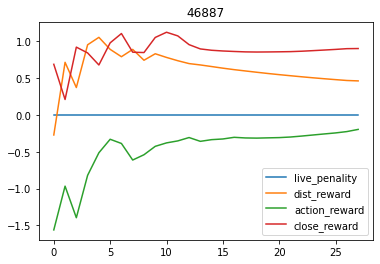

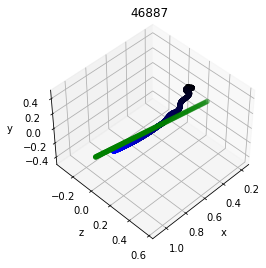

| eval  | E: 1660 | S: 46887 | R: 28.8247
| train | E: 1661 | S: 46887 | R: 26.3967 | D: 22.3 s | BR: 0.5213 | ALOSS: -10.3305 | CLOSS: 0.0886 | TLOSS: -0.0940 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 1662 | S: 46917 | R: 21.9057 | D: 37.3 s | BR: 0.4696 | ALOSS: -10.4737 | CLOSS: 0.0909 | TLOSS: -0.1232 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 1663 | S: 46944 | R: 23.9367 | D: 17.3 s | BR: 0.4857 | ALOSS: -10.1512 | CLOSS: 0.0915 | TLOSS: 0.4293 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 1664 | S: 46967 | R: 19.2396 | D: 14.8 s | BR: 0.5289 | ALOSS: -10.3922 | CLOSS: 0.0949 | TLOSS: 0.1344 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 1665 | S: 47000 | R: 27.8876 | D: 23.0 s | BR: 0.4877 | ALOSS: -10.5841 | CLOSS: 0.1024 | TLOSS: -0.0774 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 1666 | S: 47027 | R: 13.1097 | D: 18.7 s | BR: 0.4593 | ALOSS: -10.1626 | CLOSS: 0.0969 | TLOSS: 0.3992 | TVAL: 0.0366 | AENT: -4.0000
| train | E: 1667 | S: 47072 | R: 35.9795 | D: 27.4 s | BR: 0.4869 

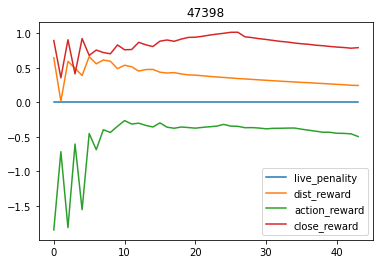

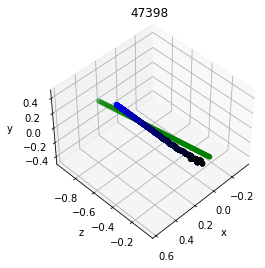

| eval  | E: 1676 | S: 47398 | R: 32.8099
| train | E: 1677 | S: 47398 | R: 18.8511 | D: 29.8 s | BR: 0.5300 | ALOSS: -10.0780 | CLOSS: 0.0908 | TLOSS: -0.1059 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 1678 | S: 47439 | R: 19.2747 | D: 54.5 s | BR: 0.5145 | ALOSS: -10.3755 | CLOSS: 0.0747 | TLOSS: -0.1115 | TVAL: 0.0368 | AENT: -4.0000
| train | E: 1679 | S: 47480 | R: 24.7194 | D: 28.5 s | BR: 0.4772 | ALOSS: -10.2819 | CLOSS: 0.0866 | TLOSS: 0.0330 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 1680 | S: 47513 | R: 27.8393 | D: 22.0 s | BR: 0.4914 | ALOSS: -10.2418 | CLOSS: 0.0827 | TLOSS: 0.2110 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 1681 | S: 47534 | R: 17.8465 | D: 16.1 s | BR: 0.4787 | ALOSS: -10.5241 | CLOSS: 0.0811 | TLOSS: -0.2480 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 1682 | S: 47558 | R: 22.6115 | D: 16.7 s | BR: 0.4939 | ALOSS: -10.2922 | CLOSS: 0.0892 | TLOSS: 0.1247 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 1683 | S: 47593 | R: 22.9008 | D: 25.8 s | BR: 0.5109 

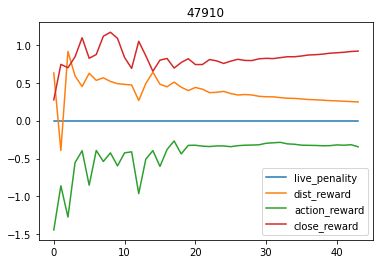

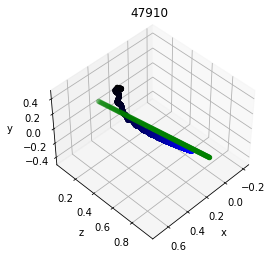

| eval  | E: 1691 | S: 47910 | R: 33.9525
| train | E: 1692 | S: 47910 | R: 22.5904 | D: 22.6 s | BR: 0.5048 | ALOSS: -10.2495 | CLOSS: 0.0838 | TLOSS: 0.0005 | TVAL: 0.0370 | AENT: -4.0000
| train | E: 1693 | S: 47952 | R: 23.6823 | D: 57.9 s | BR: 0.4942 | ALOSS: -10.3145 | CLOSS: 0.0919 | TLOSS: 0.1939 | TVAL: 0.0370 | AENT: -4.0000
| train | E: 1694 | S: 47986 | R: 25.9911 | D: 24.5 s | BR: 0.5031 | ALOSS: -10.1265 | CLOSS: 0.0900 | TLOSS: -0.4493 | TVAL: 0.0370 | AENT: -4.0000
| train | E: 1695 | S: 48030 | R: 33.5240 | D: 28.0 s | BR: 0.4976 | ALOSS: -10.3851 | CLOSS: 0.0861 | TLOSS: -0.0602 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 1696 | S: 48076 | R: 33.8993 | D: 33.1 s | BR: 0.5205 | ALOSS: -10.1364 | CLOSS: 0.0905 | TLOSS: 0.1584 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 1697 | S: 48108 | R: 21.5919 | D: 20.8 s | BR: 0.4904 | ALOSS: -10.4121 | CLOSS: 0.0846 | TLOSS: 0.4571 | TVAL: 0.0370 | AENT: -4.0000
| train | E: 1698 | S: 48154 | R: 26.0139 | D: 30.7 s | BR: 0.4746 |

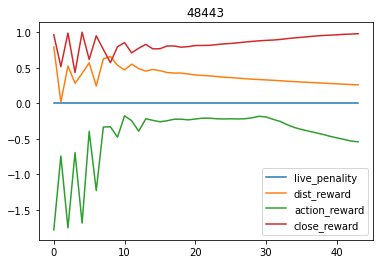

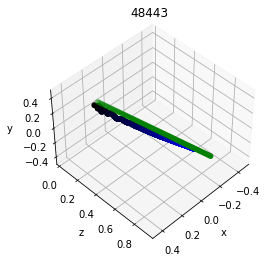

| eval  | E: 1705 | S: 48443 | R: 34.7211
| train | E: 1706 | S: 48443 | R: 19.1602 | D: 27.7 s | BR: 0.4986 | ALOSS: -10.5388 | CLOSS: 0.0920 | TLOSS: 0.3997 | TVAL: 0.0375 | AENT: -4.0000
| train | E: 1707 | S: 48477 | R: 28.5013 | D: 50.7 s | BR: 0.5406 | ALOSS: -9.9056 | CLOSS: 0.0986 | TLOSS: -0.0815 | TVAL: 0.0376 | AENT: -4.0000
| train | E: 1708 | S: 48515 | R: 32.3369 | D: 25.0 s | BR: 0.5063 | ALOSS: -9.9633 | CLOSS: 0.0927 | TLOSS: 0.4245 | TVAL: 0.0376 | AENT: -4.0000
| train | E: 1709 | S: 48563 | R: 23.1514 | D: 33.4 s | BR: 0.5062 | ALOSS: -10.3048 | CLOSS: 0.0925 | TLOSS: 0.1145 | TVAL: 0.0378 | AENT: -4.0000
| train | E: 1710 | S: 48599 | R: 24.9375 | D: 25.6 s | BR: 0.5137 | ALOSS: -10.3892 | CLOSS: 0.0859 | TLOSS: 0.1229 | TVAL: 0.0378 | AENT: -4.0000
| train | E: 1711 | S: 48633 | R: 20.4188 | D: 29.9 s | BR: 0.5139 | ALOSS: -10.3016 | CLOSS: 0.0714 | TLOSS: -0.4481 | TVAL: 0.0378 | AENT: -4.0000
| train | E: 1712 | S: 48660 | R: 25.7466 | D: 21.2 s | BR: 0.5079 | A

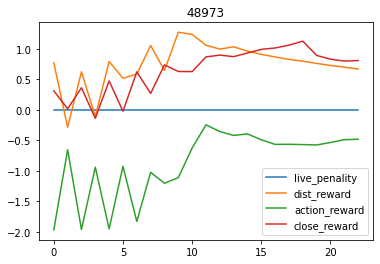

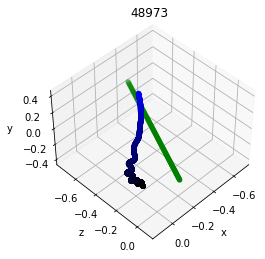

| eval  | E: 1719 | S: 48973 | R: 12.4971
| train | E: 1720 | S: 48973 | R: 38.6948 | D: 31.3 s | BR: 0.5227 | ALOSS: -10.3234 | CLOSS: 0.0748 | TLOSS: -0.0684 | TVAL: 0.0375 | AENT: -4.0000
| train | E: 1721 | S: 49005 | R: 26.5114 | D: 38.4 s | BR: 0.4929 | ALOSS: -10.2931 | CLOSS: 0.1028 | TLOSS: -0.1349 | TVAL: 0.0374 | AENT: -4.0000
| train | E: 1722 | S: 49047 | R: 24.4954 | D: 28.5 s | BR: 0.5197 | ALOSS: -10.2698 | CLOSS: 0.0750 | TLOSS: -0.0006 | TVAL: 0.0374 | AENT: -4.0000
| train | E: 1723 | S: 49077 | R: 14.2722 | D: 26.0 s | BR: 0.5068 | ALOSS: -10.1587 | CLOSS: 0.0963 | TLOSS: -0.1057 | TVAL: 0.0373 | AENT: -4.0000
| train | E: 1724 | S: 49111 | R: 17.0118 | D: 24.4 s | BR: 0.5088 | ALOSS: -10.1457 | CLOSS: 0.0992 | TLOSS: -0.1676 | TVAL: 0.0373 | AENT: -4.0000
| train | E: 1725 | S: 49141 | R: 27.8291 | D: 22.8 s | BR: 0.5093 | ALOSS: -10.4361 | CLOSS: 0.0881 | TLOSS: -0.5809 | TVAL: 0.0372 | AENT: -4.0000
| train | E: 1726 | S: 49185 | R: 26.0566 | D: 31.3 s | BR: 0.51

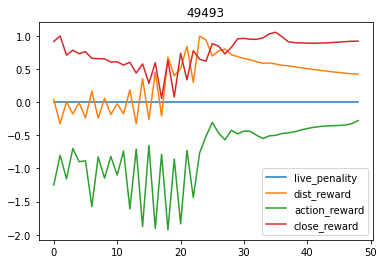

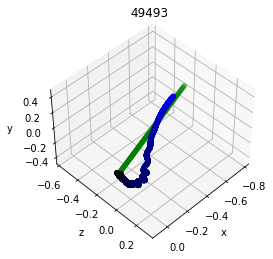

| eval  | E: 1735 | S: 49493 | R: 16.7048
| train | E: 1736 | S: 49493 | R: 22.2932 | D: 18.7 s | BR: 0.5210 | ALOSS: -10.1677 | CLOSS: 0.0815 | TLOSS: -0.0595 | TVAL: 0.0376 | AENT: -4.0000
| train | E: 1737 | S: 49528 | R: 32.8386 | D: 52.0 s | BR: 0.5369 | ALOSS: -10.2344 | CLOSS: 0.0733 | TLOSS: 0.1249 | TVAL: 0.0376 | AENT: -4.0000
| train | E: 1738 | S: 49556 | R: 13.5327 | D: 17.3 s | BR: 0.5069 | ALOSS: -10.3683 | CLOSS: 0.0990 | TLOSS: 0.1788 | TVAL: 0.0376 | AENT: -4.0000
| train | E: 1739 | S: 49581 | R: 12.6938 | D: 17.2 s | BR: 0.5809 | ALOSS: -10.1979 | CLOSS: 0.0878 | TLOSS: -0.0336 | TVAL: 0.0377 | AENT: -4.0000
| train | E: 1740 | S: 49610 | R: 21.9578 | D: 17.7 s | BR: 0.5342 | ALOSS: -10.2891 | CLOSS: 0.0872 | TLOSS: 0.0936 | TVAL: 0.0377 | AENT: -4.0000
| train | E: 1741 | S: 49637 | R: 18.6034 | D: 17.0 s | BR: 0.4941 | ALOSS: -10.3345 | CLOSS: 0.0866 | TLOSS: 0.3542 | TVAL: 0.0377 | AENT: -4.0000
| train | E: 1742 | S: 49679 | R: 25.1578 | D: 26.0 s | BR: 0.5196 |

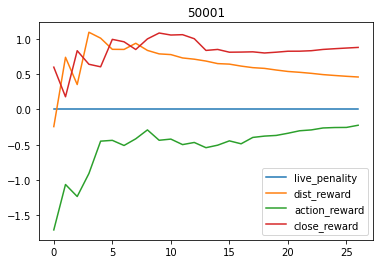

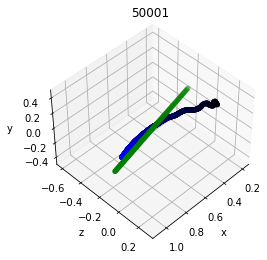

| eval  | E: 1750 | S: 50001 | R: 25.9016
| train | E: 1751 | S: 50001 | R: 15.7492 | D: 21.7 s | BR: 0.5289 | ALOSS: -10.2650 | CLOSS: 0.0748 | TLOSS: -0.4219 | TVAL: 0.0378 | AENT: -4.0000


In [27]:
while step < num_train_steps:
    samples = collect_traj()
    for sample in samples:
        obs,action,next_obs,reward,done = sample
        if done:
            logger.log('train/duration',time.time() - start_time, step)
            start_time = time.time()
            # evaluate agent periodically
            if step >=next_eval_steps:
                # save model
                agent.save(model_folder+"steps_{0}".format(step))
                logger.log('eval/episode', episode, step)
                next_eval_steps = step+eval_frequency
                evaluate()
            logger.log('train/episode_reward', episode_reward,step)
            episode_reward = 0
            episode += 1
            logger.log('train/episode', episode, step)
            logger.dump(step, save=True,ty='train')
        # run training update
        log_data = agent.train(gradient_steps,batch_size)
        logger.log_data(log_data,step)
        done = float(done)
        episode_reward += reward
        step += 1
        agent.replay_buffer.add(obs, action, reward, next_obs, done)

In [ ]:
torch.save({'buffer':agent.replay_buffer},model_folder+'buffer')
torch.save({'actor':agent.actor.state_dict()},model_folder+'actor')
agent.save(model_folder+'model')

In [ ]:
network_folder

## Evaluation and Test

In [ ]:
evaluate_save_fluid=False
evaluate_save_data=True

In [ ]:
def evaluate_traj(theta,dist):
        print("Evaluating episode  ...."+str(theta))
        obs = env.reset()
        env.set_task(theta,dist)
        ref_line = fl.debugLine()
        ref_line.vertices = [
                    env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
                ]
        fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")
        agent.reset()
        done = False
        episode_reward = 0
        infos = []
        while not done:
            with utils.eval_mode(agent):
                action = agent.act(obs, sample=False)
            if evaluate_save_data:
                obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
            else:
                obs, reward, done, info = env.step(action)
            infos.append(info)
            # video_recorder.record(env)
            episode_reward += reward
        print(episode_reward)
#         plot_infos(infos,title=str(theta))
        env.plot3d(title=str(theta))

In [ ]:
!./clean_visdata.sh
evaluate_traj(3.14,0.01)

In [ ]:
ref_line = fl.debugLine()
ref_line.vertices = [
            env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
        ]
fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")

In [ ]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [ ]:
%matplotlib notebook

In [ ]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

In [ ]:
# fluid_json = json_folder+'fluid_param_0.5.json'
# rigid_json = json_folder+'rigids_4_30_test.json'
# frame_skip = 100
from gym_fish.envs import FishEnv
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,frame_skip=frame_skip,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
               
                   )
env.plot3d()

In [ ]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_ss.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [ ]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
    dxyz = env.goal_pos-env.body_xyz
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='yellow',)
    ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
    fig.canvas.draw()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


# skeleton_dynamics.update()

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)

# skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)
env.simulator.mainDataFolderPath = store_folder+'/data/'
env.dataPath = {}
env.dataPath["fluid"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.fluidFolderName + '/').resolve())
env.dataPath["objects"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.objectsFolderName + '/').resolve())
env.dataPath["trajectory"] = str(Path(env.simulator.mainDataFolderPath + 'Trajectory/').resolve())
if not os.path.exists(env.simulator.mainDataFolderPath):
    os.makedirs(env.simulator.mainDataFolderPath)
for p in env.dataPath.values():
    if not os.path.exists(p):
        os.makedirs(p)



env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
actions= []
observations = []
vels = []
while True:
    if env.rigid_data.rigidWorld.time>50 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break 
    obs = env._get_obs()
    observations.append(obs)
    with utils.eval_mode(agent):
        action = agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    env.stepSave(action,save_objects=True,save_fluid=False,test_mode=True)
    
    rela_vec_to_goal = env.goal_pos-env.body_xyz
    dist_to_path = np.linalg.norm(rela_vec_to_goal-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir))
    env.proj_pt_world = env.goal_pos-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir)
    if np.linalg.norm(env.body_xyz-env.goal_pos)<0.3:
        t = t+dt
        env.goal_pos = traj.getPose(t).getPosition() 
        env.path_start  = env.body_xyz 
        env.path_dir = env.goal_pos-env.path_start
        env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
    plot_env(env,ax)
plt.close(fig)


In [ ]:
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),vels)
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),actions)
plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
# plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(observations),1),np.array(observations))
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),[ 0.1* np.sum(np.abs(a)**0.5) for a in actions])
plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.set_theta(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
    

actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    _,_,_,_=env.stepSave(action,save_objects=False,save_fluid=False)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()